# Detecting Campaign Financing Irregularities In The Brazilian 2018 Elections

The purpose of this project is to analyze data made available by different Brazilian government institutions and see whether it is possible to predict which candidates will be investigated for irregularities in their campaign financial activities 

## Python Libraries

In [169]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('dark_background')
#style.use('fivethirtyeight')
import seaborn as sns

from scipy.stats import skew
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc,  balanced_accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import plot_importance

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras.initializers import RandomUniform

import itertools
from bs4 import BeautifulSoup
import requests
from requests import get
import time
from selenium import webdriver
import pandas as pd
import re
import csv
from os import listdir
from os.path import isfile, join
import shutil
import pickle


from benfordslaw import benfordslaw
from unidecode import unidecode

## Helper Functions

In [2]:
def pickling(variable, filename, location='pickle_jar\\'):
    if location:
        filename =  location +  filename 
        
    #""" filename without .pickle """
    with open(filename+'.pickle', 'wb') as f:
        pickle.dump(variable, f, protocol=pickle.HIGHEST_PROTOCOL)
        return filename

def unpickling(fname, location='pickle_jar\\'):
    if location:
        fname =  location +  fname 
    with open(fname + '.pickle', 'rb') as file:
        response = pickle.load(file)
    return response

def content_graber(results):
    """Grabs and organizes scraped data
    Returns list containing the data"""
    text_results = []
    for item in results:
        text_results.append(item.text)
    return text_results

def start_browsers(n):
    """ Starts multiple PhantomJS browsers
    n: number of browsers to be started
    Returns n browsers
    """
    print('starting browsers...')
    browsers = [webdriver.PhantomJS() for i in range(n)]
    print('browsers started')
    return browsers

def url_generator(batch):
    """Generates a URL for each case in the batch
    Returns a list of URLs"""
    path = "http://consultapublicapje.tse.jus.br/detalhar-processo?pNumProcesso="
    urls = [path+process for process in batch]
    return urls

def slice_batch(starting_index, ending_index, selected_process_list,):
    """Takes in a list, and returns a slice (list) from it given the provided starting 
    and  ending positions"""
    batch = [selected_process_list[i] for i in range(starting_index, ending_index) if i <= len(selected_process_list)-1]
    return batch

def organize_process_info(processo):
    """Takes in the stored data of a court case as a list and returns it
    as a dictionary after cleaning and processing the data"""
    d = {}    
    if processo[1]:
        d['CPF'] = [', '.join(processo[1])]
        d['CNPJ'] = [', '.join(processo[2])]
        d['Processo'] = [processo[0]]
        columns = ['Fase Atual','Instância', 'Relator', 'Data da Autuação',
                  'Classe Judicial',  'Assunto Principal', 'Objeto']
        useful_info = processo[3][0].split('\n')
        col_indices = [useful_info.index(col) for col in columns if col in useful_info]
      
        for col in columns:
            i = useful_info.index(col)
           
            if (i+1 <= len(useful_info)-1):
                d[col] = [useful_info[i+1]]
            else:            
                continue
        return d
    else:
        d['Processo'] = processo[0]
        return d
    
def plot_confusion_matrix(y_hat_test, y_test,
                          normalize=False,
                          title='Confusion matrix',
                          ):
    
    "Plots the Confusion Matrix"
    
    cm=confusion_matrix(y_hat_test, y_test)
    classes=y_test.unique()
    cmap=plt.cm.Blues
    
    #Add Normalization Option
    if normalize:
        cm = cm/cm.sum()

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] >= thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Scraping, Loading and Cleaning Data

## Candidate Identifiers

In order to cross reference data from different files it is necessary to construct a table with all possible identification information about the candidates.

One important observation is that some individuals (as identified by their Social Security Number) appear more than once. Apparently some of them applied for candidacy for one position and later changed it, others  have had their first application for candidacy denied and later reapplied. 

This results in multiple "SQ_CANDIDATO" for a given SSN. 
Even though many datasets contained herein only provide the "SQ_CANDIDATO" as identification, the final data aggregates information by SSN

### 2018 Elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2018.zip

In [41]:
# loading csv (text format) of the list of candidacies
campaing_identifiers_2018_df = pd.read_csv(
    'fin_campanhas\\data\\CANDIDATOS\\consulta_cand_2018\\consulta_cand_2018_BRASIL.csv',
    sep=';', encoding='latin-1', error_bad_lines=False, dtype='str').loc[
    :,['NM_CANDIDATO', # candidate's name
       'NR_CPF_CANDIDATO', # social security number
       'SQ_CANDIDATO', # Arbitrary number used by the election watchdogs to identify the candidate 
       'CD_CARGO', # code that identifies the position a candidate is running for (ex: president, senador, etc)
       'DS_SITUACAO_CANDIDATURA', # describes the status of the candidacy (ex: "able", "not able", etc)
       'CD_TIPO_ELEICAO' # code for the type of election (ex: "Ordinary", "Extraordinary")
      ]]

# drop all candidacies that were not deemed "able"
campaing_identifiers_2018_df.drop(index=
campaing_identifiers_2018_df.loc[campaing_identifiers_2018_df['DS_SITUACAO_CANDIDATURA'] != 'APTO'].index, inplace=True)
campaing_identifiers_2018_df.drop(columns='DS_SITUACAO_CANDIDATURA', inplace=True)

# drop all candidacies that were not for ordinary elections
campaing_identifiers_2018_df.drop(index=
campaing_identifiers_2018_df.loc[campaing_identifiers_2018_df['CD_TIPO_ELEICAO'] != '2'].index, inplace=True)
campaing_identifiers_2018_df.drop(columns='CD_TIPO_ELEICAO', inplace=True)

# drops candidacies that show up with a clearly inexistent Social Security Number 
campaing_identifiers_2018_df.drop(
    index=campaing_identifiers_2018_df.loc[
        campaing_identifiers_2018_df['NR_CPF_CANDIDATO'] == '000000000-4'].index, 
    inplace=True)

# converts strings to unidecode format
campaing_identifiers_2018_df['NM_CANDIDATO'] = campaing_identifiers_2018_df['NM_CANDIDATO'].astype('str').apply(unidecode)
campaing_identifiers_2018_df.drop_duplicates(inplace=True)


# sets 'SQ_CANDIDATO' as the index since this field shows up in all other tables to be cross referenced
campaing_identifiers_2018_df.set_index('SQ_CANDIDATO', inplace=True, drop=True)

In [43]:
# builds a dictionary of SSN (CPF) and Campaigns' tax id (CNPJ) from the revenues dataset
CPF_CNPJ = pd.read_csv(
     'fin_campanhas\\data\\PRESTA_CONTAS\\prestacao_de_contas_eleitorais_candidatos_2018\\receitas_candidatos_2018_BRASIL.csv',
    sep=';', encoding='latin-1', error_bad_lines=False, dtype='str')[['NR_CPF_CANDIDATO','NR_CNPJ_PRESTADOR_CONTA',
                                                                     'CD_TIPO_ELEICAO',]]

CPF_CNPJ.drop(index=
              CPF_CNPJ.loc[CPF_CNPJ['CD_TIPO_ELEICAO'] != '2'].index, 
              inplace=True)

CPF_CNPJ.drop(columns='CD_TIPO_ELEICAO', inplace=True)
CPF_CNPJ.drop_duplicates(inplace=True)


cpf_cnpj_dict = dict()
for cpf in CPF_CNPJ['NR_CPF_CANDIDATO'].unique():
    cpf_cnpj_dict[cpf] = list(CPF_CNPJ.loc[CPF_CNPJ['NR_CPF_CANDIDATO'] == cpf,'NR_CNPJ_PRESTADOR_CONTA'].values)

pickling(cpf_cnpj_dict, 'cpf_cnpj_dict')


### 2014 Elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2014.zip

In [74]:
# loading csv (text format) of the list of candidacies
campaing_identifiers_2014_df = pd.read_csv(
    'fin_campanhas\\data\\CANDIDATOS\\consulta_cand_2014\\consulta_cand_2014_BRASIL.csv',
    sep=';', encoding='latin-1', error_bad_lines=False, dtype='str').loc[
    :,['NM_CANDIDATO','NR_CPF_CANDIDATO','SQ_CANDIDATO',
       'CD_CARGO', 
       'CD_TIPO_ELEICAO']]


# drop all candidacies that were not for ordinary elections
campaing_identifiers_2014_df.drop(index=
campaing_identifiers_2014_df.loc[campaing_identifiers_2014_df['CD_TIPO_ELEICAO'] != '2'].index, inplace=True)
campaing_identifiers_2014_df.drop(columns='CD_TIPO_ELEICAO', inplace=True)

# converts strings to unidecode format
campaing_identifiers_2014_df['NM_CANDIDATO'] = campaing_identifiers_2014_df['NM_CANDIDATO'].astype('str').apply(unidecode)


# drops candidacies that show up with a clearly inexistent Social Security Number 
campaing_identifiers_2014_df.drop_duplicates(subset=['NR_CPF_CANDIDATO', 'CD_CARGO', 'SQ_CANDIDATO'],inplace=True)
campaing_identifiers_2014_df.drop(
    index=campaing_identifiers_2014_df.loc[
        campaing_identifiers_2014_df['NR_CPF_CANDIDATO'] == '000000000-4'
    ].index, inplace=True)

# sets 'SQ_CANDIDATO' as the index since this field shows up in all other tables to be cross referenced
campaing_identifiers_2014_df.set_index('SQ_CANDIDATO', inplace=True, drop=True)

### 2010 Elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2010.zip

In [75]:
# For the 2010 elections, the data is broken down into multiple files. 

# columns names
columns = ['DATA_GERACAO','HORA_GERACAO', 'ANO_ELEICAO', 'NUM_TURNO', 'DESCRICAO_ELEICAO',
           'SIGLA_UF', 'SIGLA_UE', 'DESCRICAO_UE', 'CODIGO_CARGO', 'DESCRICAO_CARGO',
           'NOME_CANDIDATO', 'SEQUENCIAL_CANDIDATO', 'NUMERO_CANDIDATO', 'CPF_CANDIDATO', 
           'NOME_URNA_CANDIDATO', 'COD_SITUACAO_CANDIDATURA', 'DES_SITUACAO_CANDIDATURA',
           'NUMERO_PARTIDO', 'SIGLA_PARTIDO', 'NOME_PARTIDO', 'CODIGO_LEGENDA', 
           'SIGLA_LEGENDA', 'COMPOSICAO_LEGENDA', 'NOME_LEGENDA', 'CODIGO_OCUPACAO',
           'DESCRICAO_OCUPACAO', 'DATA_NASCIMENTO', 'NUM_TITULO_ELEITORAL_CANDIDATO', 
           'IDADE_DATA_ELEICAO', 'CODIGO_SEXO', 'DESCRICAO_SEXO', 'COD_GRAU_INSTRUCAO', 
           'DESCRICAO_GRAU_INSTRUCAO', 'CODIGO_ESTADO_CIVIL', 'DESCRICAO_ESTADO_CIVIL',
           'CODIGO_NACIONALIDADE', 'DESCRICAO_NACIONALIDADE', 'SIGLA_UF_NASCIMENTO',
           'CODIGO_MUNICIPIO_NASCIMENTO', 'NOME_MUNICIPIO_NASCIMENTO', 'DESPESA_MAX_CAMPANHA',
           'COD_SIT_TOT_TURNO', 'DESC_SIT_TOT_TURNO']

path = 'fin_campanhas\\data\\CANDIDATOS\\consulta_cand_2010\\'
folder_files = listdir(path)
csv_files = []

# loop to iterate through, store and concatenate them into a single dataframe
for file in folder_files:
    if file[:5] == 'consu':
        df = pd.read_csv(path + file, sep=';', encoding='latin-1',
                         names=columns, error_bad_lines=False, dtype='str')
    csv_files.append(df)
campaing_identifiers_2010_df = pd.concat(csv_files, ignore_index=True)
campaing_identifiers_2010_df = campaing_identifiers_2010_df.loc[:,['NOME_CANDIDATO','CPF_CANDIDATO',
                                                'SEQUENCIAL_CANDIDATO','CODIGO_CARGO']]


# renaming columns in order to remain consisting with other elections'
campaing_identifiers_2010_df.columns= ['NM_CANDIDATO', 'NR_CPF_CANDIDATO', 
                                      'SQ_CANDIDATO', 'CD_CARGO']

# converts strings to unidecode format
campaing_identifiers_2010_df['NM_CANDIDATO'] = campaing_identifiers_2010_df['NM_CANDIDATO'].astype('str').apply(unidecode)

# removing any candidacies listed with multiple names (minor differences in spelling)
campaing_identifiers_2010_df.drop_duplicates(subset=['NR_CPF_CANDIDATO', 'CD_CARGO', 'SQ_CANDIDATO'],inplace=True)

# drops candidacies that show up with a clearly inexistent Social Security Number 
campaing_identifiers_2010_df.drop(
    index=campaing_identifiers_2010_df.loc[
        campaing_identifiers_2010_df['NR_CPF_CANDIDATO'] == '000000000-4'
    ].index, inplace=True)
campaing_identifiers_2010_df['SQ_CANDIDATO'] = campaing_identifiers_2010_df['SQ_CANDIDATO'].astype('str')
campaing_identifiers_2010_df.set_index('SQ_CANDIDATO', inplace=True, drop=True)

## Election Results

### 2018 Elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/votacao_partido_munzona/votacao_partido_munzona_2018.zip

In [10]:
path = '\\Users\\felip\\flatiron-ds-course\\Data Science\\Capstone\\resultados\\'
folder = 'votacao_candidato_munzona_2018\\'
fname = 'votacao_candidato_munzona_2018_BRASIL.csv'

with open(path+folder+fname) as f:
    row_count = sum(1 for row in f) 
print(row_count)

9061049


In [11]:
# column names for the 2018 and 2014 datasets

columns_2014 = ['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
                'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO','DS_ELEICAO',
                'DT_ELEICAO','TP_ABRANGENCIA', 'SG_UF', 'SG_UE',  'NM_UE',
                'CD_MUNICIPIO','NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 
                'SQ_CANDIDATO', 'NR_CANDIDATO','NM_CANDIDATO', 'NM_URNA_CANDIDATO', 
                'NM_SOCIAL_CANDIDATO', 'CD_SITUACAO_CANDIDATURA', 'DS_SITUACAO_CANDIDATURA', 
                'CD_DETALHE_SITUACAO_CAND', 'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO', 
                'NR_PARTIDO','SG_PARTIDO', 'NM_PARTIDO',  'SQ_COLIGACAO',  'NM_COLIGACAO', 
                'DS_COMPOSICAO_COLIGACAO','CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO', 
                'ST_VOTO_EM_TRANSITO','QT_VOTOS_NOMINAIS']

resultados_2018_df = pd.DataFrame(columns=columns_2014)
nrows = 100000
skiprows = 0

# loop to load the file in parts (RAM management)
while skiprows < row_count:
    df = pd.read_csv(
        path+folder+fname, sep=";",  encoding='latin-1', engine='python', 
        error_bad_lines=False,  skiprows=skiprows, names=columns_2014, 
        dtype='str', nrows = nrows)
    
    resultados_2018_df = pd.concat([resultados_2018_df, df], axis=0)
    resultados_2018_df.reset_index(drop=True, inplace=True)
        
    if ((skiprows % 1000000 == 0) & (skiprows >1)):
        resultados_2018_df.to_json(('resultados_2018_'+str(int(skiprows/1000000))+'_json'))
        resultados_2018_df = pd.DataFrame(columns=columns_2014)
    skiprows += nrows

resultados_2018_df.to_json(('resultados_2018_'+str(int(skiprows/1000000)+1)+'_json'))
del resultados_2018_df, nrows, skiprows, df

In [12]:
# loading 2018 results to trim and join the dataframes
fnames = [fname for fname in listdir() if fname[:15] == 'resultados_2018']

resultados_2018_df = pd.DataFrame()
for fname in fnames:
    with open(fname) as f:
        d = json.load(f)
    del f
    df = pd.DataFrame(d)
    del d
    df = df.loc[:,['SQ_CANDIDATO','CD_TIPO_ELEICAO','QT_VOTOS_NOMINAIS', 'CD_CARGO', 'SG_UF', 
                    'CD_MUNICIPIO', 'NR_ZONA',
                   'DS_SITUACAO_CANDIDATURA', 
                    'TP_AGREMIACAO', 'NR_PARTIDO','NR_TURNO', 'CD_SIT_TOT_TURNO']
                   ]
    resultados_2018_df = pd.concat([resultados_2018_df, df])
    
resultados_2018_df.reset_index(inplace=True,drop=True )

for col in ['SQ_CANDIDATO', 'CD_CARGO', 'SG_UF', 'CD_MUNICIPIO', 'NR_ZONA',
           'DS_SITUACAO_CANDIDATURA','TP_AGREMIACAO', 'NR_PARTIDO', 'NR_TURNO',
           'CD_SIT_TOT_TURNO', 'CD_TIPO_ELEICAO']:
    resultados_2018_df[col] = resultados_2018_df[col].astype('category')
    

resultados_2018_df.to_json('resultados_2018_json')
del resultados_2018_df, df, fnames, fname, col

In [14]:
with open('resultados_2018_json') as f:
    d = json.load(f)
    
# keep only relevant columns
resultados_2018_df = pd.DataFrame(d)[['SQ_CANDIDATO', 'QT_VOTOS_NOMINAIS', 'CD_TIPO_ELEICAO']]
del d
del f

# drops results for election that are not ordinary
resultados_2018_df.drop(
    index=resultados_2018_df.loc[
        resultados_2018_df['CD_TIPO_ELEICAO'] != '2'].index, 
    inplace=True)

# imports the Social Security number from the candidacy identifiers dataframe
resultados_2018_df = resultados_2018_df.set_index('SQ_CANDIDATO', drop=True
                                                 ).join(
    campaing_identifiers_2018_df['NR_CPF_CANDIDATO'])
resultados_2018_df.reset_index(inplace=True, drop=True)

# drop a row that contains the column names instead of actual values
resultados_2018_df.drop(index=
                        resultados_2018_df.loc[
                            (resultados_2018_df['QT_VOTOS_NOMINAIS'] == 'QT_VOTOS_NOMINAIS')
                        ].index, inplace=True)

resultados_2018_df['QT_VOTOS_NOMINAIS'] = resultados_2018_df['QT_VOTOS_NOMINAIS'].astype('int') 

# sums up all the votes reported for each candidate (votes were reported per precinct)
resultados_2018_df = resultados_2018_df.groupby('NR_CPF_CANDIDATO').sum()
resultados_2018_df.reset_index(inplace=True, drop=False)
resultados_2018_df.set_index('NR_CPF_CANDIDATO', inplace=True, drop=True)
resultados_2018_df.fillna(value=0.0)

resultados_2018_df.to_json('resultados_2018_json')
del resultados_2018_df

### 2014 Elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2014.zip

In [17]:
path = '\\Users\\felip\\flatiron-ds-course\\Data Science\\Capstone\\resultados\\'
folder = 'votacao_candidato_munzona_2014\\'
fname = 'votacao_candidato_munzona_2014_BRASIL.csv'

with open(path+folder+fname) as f:
    row_count = sum(1 for row in f)
print(row_count)

7904226


In [18]:
resultados_2014_df = pd.DataFrame(columns=columns_2014)
nrows = 500000
skiprows = 0

# loop to load the file in parts (RAM management)
while skiprows < row_count:
    df = pd.read_csv(
        path+folder+fname, sep=";",  encoding='latin-1', engine='python', error_bad_lines=False, 
        skiprows=skiprows, names=columns_2014,
        nrows = nrows, dtype='str')
    
    resultados_2014_df = pd.concat([resultados_2014_df, df], axis=0)
    resultados_2014_df.reset_index(drop=True, inplace=True)
    
    if ((skiprows % 1500000 == 0) & (skiprows >1)):
        resultados_2014_df.to_json(('resultados_2014_'+str(int(skiprows/1500000))+'_json'))
        resultados_2014_df = pd.DataFrame(columns=columns_2014)
    skiprows += nrows

resultados_2014_df.to_json(('resultados_2014_'+str(int(skiprows/1500000)+1)+'_json'))
del resultados_2014_df, df

In [19]:
# loading 2014 results to trim it to only 'cargos' of the elected (dummies)

fnames = [fname for fname in listdir() if fname[:15] == 'resultados_2014']
resultados_2014_df = pd.DataFrame()

# loop to put parts together and shed unwanted information
for fname in fnames:
    with open(fname) as f:
        d = json.load(f)
    df = pd.DataFrame(d)
    del d
    
    # drops unwanted information
    filt_to_drop =((df['CD_SIT_TOT_TURNO'] == '4') | (df['CD_SIT_TOT_TURNO'] == '6') # 1 round results and unelected candidates
                   | (df['CD_TIPO_ELEICAO'] != '2') #  extraordinary elections
                   | (df['DS_SITUACAO_CANDIDATURA'] != 'APTO')) # "unable" candidacies
    indices_to_drop = df.loc[filt_to_drop].index
    df.drop(index=indices_to_drop, inplace=True)
    
    # keeps only SQ_CANDIDATO and the respective position elected for
    df = df.loc[:,['SQ_CANDIDATO','CD_CARGO']]
    df['SQ_CANDIDATO'] = df['SQ_CANDIDATO'].astype('str') 
    df['CD_CARGO'] = df['CD_CARGO'].astype('str') 
    df.drop_duplicates(inplace=True)
    df.set_index('SQ_CANDIDATO', inplace=True, drop=True)
    

    # creates dummy variables for CD_CARGO (position)
    df = pd.get_dummies(df, columns=['CD_CARGO'], dummy_na=True,
                             drop_first=True)
    resultados_2014_df = pd.concat([resultados_2014_df, df])

resultados_2014_df.reset_index(inplace=True, drop=False)
resultados_2014_df.drop_duplicates(inplace=True)
resultados_2014_df.set_index('SQ_CANDIDATO', inplace=True, drop=True)
resultados_2014_df.to_json('resultados_2014_json')
del resultados_2014_df, df, fnames

### 2010 Elections

In [20]:

columns_2010 = ['DATA_GERACAO','HORA_GERACAO','ANO_ELEICAO','NUM_TURNO','DESCRICAO_ELEICAO',
           'SIGLA_UF','SIGLA_UE','CODIGO_MUNICIPIO','NOME_MUNICIPIO','NUMERO_ZONA',
           'CODIGO_CARGO','NUMERO_CAND','SQ_CANDIDATO','NOME_CANDIDATO',
           'NOME_URNA_CANDIDATO','DESCRICAO_CARGO','COD_SIT_CAND_SUPERIOR',
           'DESC_SIT_CAND_SUPERIOR','CODIGO_SIT_CANDIDATO','DESC_SIT_CANDIDATO',
           'CODIGO_SIT_CAND_TOT','DESC_SIT_CAND_TOT','NUMERO_PARTIDO',
           'SIGLA_PARTIDO' ,'NOME_PARTIDO', 'SEQUENCIAL_LEGENDA', 'NOME_COLIGACAO',
                'COMPOSICAO_LEGENDA', 'TOTAL_VOTOS' ]



# this dataset in divided into multiple files, one for each state

path = '\\Users\\felip\\flatiron-ds-course\\Data Science\\Capstone\\resultados\\'
folder = 'votacao_candidato_munzona_2010\\'
filenames = [filename for filename in listdir(path+folder) if filename[:4] == 'vota']

# loops through the files and saves them as json files (RAM management)
resultados_2010_df = pd.DataFrame(columns=columns_2010)
for fname in filenames:  
    
    df = pd.read_csv(path+folder+fname, sep=";", names=columns_2010, 
                             encoding='latin-1', engine='python', 
                     error_bad_lines=False, dtype='str'
                    )

    resultados_2010_df = pd.concat([resultados_2010_df, df])
    resultados_2010_df.reset_index(inplace=True, drop=True)
    resultados_2010_df.to_json('resultados_2010_json_'+fname[-6:-4])
    
    resultados_2010_df = pd.DataFrame(columns=columns_2010)
del resultados_2010_df, df

In [22]:
# loading 2010 results to trim it to only 'cargos' of the elected candidates (dummies)
fnames = [fname for fname in listdir() if fname[:15] == 'resultados_2010']

resultados_2010_df = pd.DataFrame()
for fname in fnames:
    with open(fname) as f:
        d = json.load(f)
    df = pd.DataFrame(d)
    del d
    
    # drops unwanted entries
    filt_to_drop =( 
        # 1 round results and unelected candidates
        (df['CODIGO_SIT_CAND_TOT'] == '4') | (df['CODIGO_SIT_CAND_TOT'] == '6')
        # "unable" candidacies
        | (df['DESC_SIT_CAND_SUPERIOR'] != 'APTO'))
    
    indices_to_drop = df.loc[filt_to_drop].index
    df.drop(index=indices_to_drop, inplace=True)
    
    # slices the df to only SQ and the position ("cargo")
    df = df.loc[:,['SQ_CANDIDATO','CODIGO_CARGO']]
    df['SQ_CANDIDATO'] = df['SQ_CANDIDATO'].astype('str') 
    df['CODIGO_CARGO'] = df['CODIGO_CARGO'].astype('str') 
    df.drop_duplicates(inplace=True)
    df.set_index('SQ_CANDIDATO', inplace=True, drop=True)

    # converts the position ('CARGO') to dummies
    df = pd.get_dummies(df, columns=['CODIGO_CARGO'], dummy_na=True,
                             drop_first=True)
    resultados_2010_df = pd.concat([resultados_2010_df, df])

resultados_2010_df.reset_index(inplace=True, drop=False)
resultados_2010_df.drop_duplicates(inplace=True)
resultados_2010_df.set_index('SQ_CANDIDATO', inplace=True, drop=True)


resultados_2010_df.to_json('resultados_2010_json')
del resultados_2010_df, df, fnames

## Campaign Finances - 2018 Elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/prestacao_contas/prestacao_de_contas_eleitorais_candidatos_2018.zip

### Campaign Revenue

In [44]:
receitas_campanha_2018_df = pd.read_csv(
    'fin_campanhas\\data\\PRESTA_CONTAS\\prestacao_de_contas_eleitorais_candidatos_2018\\receitas_candidatos_2018_BRASIL.csv',
    sep=';', encoding='latin-1', error_bad_lines=False, dtype='str')


# corrects the Decimal and Thousands Separators from the Brazilian standard to the US/UK standard
receitas_campanha_2018_df['VR_RECEITA'] = receitas_campanha_2018_df['VR_RECEITA'].astype('str').str.replace('.', '')
receitas_campanha_2018_df['VR_RECEITA'] = receitas_campanha_2018_df['VR_RECEITA'].astype('str').str.replace(',', '.')
receitas_campanha_2018_df['VR_RECEITA'] = receitas_campanha_2018_df['VR_RECEITA'].astype('float')



# stores statistics of cashflows for each SSN
### standard deviation, mean, skew
relevant_cols = ['NR_CPF_CANDIDATO','VR_RECEITA']
rev_mean_df = pd.DataFrame(
    receitas_campanha_2018_df.loc[:,relevant_cols].groupby('NR_CPF_CANDIDATO'
                                                          ).mean())
rev_mean_df.columns = ['REV_mean']    

rev_std_df = pd.DataFrame(
    receitas_campanha_2018_df.loc[:,relevant_cols].groupby('NR_CPF_CANDIDATO'
                                                          ).std())
rev_std_df.columns = ['REV_std']

rev_skew_df = pd.DataFrame(
    receitas_campanha_2018_df.loc[:,relevant_cols].groupby('NR_CPF_CANDIDATO'
                                                          ).skew())
rev_skew_df.columns = ['REV_skew']

In [24]:
# runs a statistical test on the revenue numbers in order to access 
# whether they respect Benford's Law
rev_benf_dict = dict()
count = 0
for cpf in receitas_campanha_2018_df['NR_CPF_CANDIDATO'].unique():
    filt = receitas_campanha_2018_df['NR_CPF_CANDIDATO'].astype('str') == str(cpf)
    s = np.array(receitas_campanha_2018_df.loc[filt, 'VR_RECEITA'].values)
    bl = benfordslaw()
    results = bl.fit(s)
    
    # stores P value for under benford law
    rev_benf_dict[cpf] = results['P']
    count+=1
        
pickling(rev_benf_dict, 'rev_benf_dict')

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0259756, Tstat=17.425
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly d

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.95379e-24, Tstat=127.833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.139003, Tstat=12.2833
[benfordslaw] >[chi2] No anomaly detected. P=0.576659, Tstat=6.63333
[benfordslaw] >[chi2] Anomaly detected! P=1.38118e-08, Tstat=52.4444
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0002388, Tstat=29.7
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat

[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] Anomaly detected! P=0.0287503, Tstat=17.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.695643, Tstat=5.56667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.35749e-05, Tstat=35.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0148596, Tstat=19
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsla

[benfordslaw] >[chi2] Anomaly detected! P=0.00142792, Tstat=25.2175
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.14682e-05, Tstat=35.5227
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.331173, Tstat=9.13333
[benfordslaw] >[chi2] No anomaly detected. P=0.310246, Tstat=9.39286
[benfordslaw] >[chi2] Anomaly detected! P=0.0199068, Tstat=18.1814
[benfordslaw] >[chi2] No anomaly detected. P=0.420555, Tstat=8.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00556647, Tstat=21.6694
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1683.39
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.30457e-24, Tstat=129.674
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0357577, Tstat=16.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.339492, Tstat=9.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.783932, Tstat=4.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfords

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.917703, Tstat=3.25
[benfordslaw] >[chi2] No anomaly detected. P=0.339492, Tstat=9.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000640025, Tstat=27.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[ch

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.13643e-07, Tstat=47.6818
[benfordslaw] >[chi2] Anomaly detected! P=0.00823128, Tstat=20.619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00433439, Tstat=22.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.276919, Tstat=9.83333
[be

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0341619, Tstat=16.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.10528e-09, Tstat=55.7857
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.08527e-15, Tstat=88.1857
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.254088, Tstat=10.1583
[benfordslaw] >[chi2] No anomaly detected. P=0.0891426, Tstat=13.7278
[benfordslaw] >[chi2] Anomaly detected! P=0.00818793, Tstat=20.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.725083, Tstat=5.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.239686, Tstat=10.375


[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=0.934358, Tstat=3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] Anomaly detected! P=1.31822e-22, Tstat=121.939
[benfordslaw] >[chi2] No anomaly detected. P=0.222371, Tsta

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.349375, Tstat=8.91667
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.96563e-06, Tstat=38.9762
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.309309, Tstat=9.40476
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.242405, Tstat=10.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.68558e-05, Tstat=34.2333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.43555e-05, Tstat=36.4775
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00296164, Tstat=23.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.8966e-14, Tstat=80.4894
[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anomaly detected. P=0.853887, Tstat=4.03571
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.272e-06, Tstat=38.0814
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[ben

[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.483767, Tstat=7.5
[benfordslaw] >[chi2] Anomaly detected! P=4.9894e-08, Tstat=49.5487
[benfordslaw] >[chi2] No anomaly detected. P=0.107344, Tstat=13.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0487473, Tstat=15.

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0235916, Tstat=17.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benfordslaw] >[chi2] No anomaly detected. P=0.242405, Tstat=10.3333
[benfordslaw] >[chi2] Anomaly detected! P=4.59798e-15, Tstat=85.0887
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] Anomaly detected! P=2.67786e-05, Tstat=34.9964
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0389385, Tstat=16.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.169

[benfordslaw] >[chi2] Anomaly detected! P=0.0378501, Tstat=16.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.383177, Tstat=8.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2]

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0177749, Tstat=18.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No an

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.558357, Tstat=6.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00138259, Tstat=25.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anoma

[benfordslaw] >[chi2] Anomaly detected! P=6.54955e-23, Tstat=123.409
[benfordslaw] >[chi2] Anomaly detected! P=0.00136063, Tstat=25.3409
[benfordslaw] >[chi2] Anomaly detected! P=0.0387185, Tstat=16.2667
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.968e-23, Tstat=124.461
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=0.0100253, Tstat=20.0833
[benfordslaw] >[chi2] Anomaly detected! P=1.01468e-06, Tstat=42.6673
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Ts

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.689818, Tstat=5.61905
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.31877, Tstat=9.28571
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00784203, Tstat=20.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[c

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.871839, Tstat=3.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.104249, Tstat=13.2278
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] Anomaly detected! P=6.23e-09, Tstat=54.2298
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan


[benfordslaw] >[chi2] Anomaly detected! P=2.32139e-06, Tstat=40.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0124026, Tstat=19.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.334937, Tstat=9.08788
[benfordslaw] >[chi2] No anomaly detected. P=0.0947695, Tstat=13.5333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benford

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.576659, Tstat=6.63333
[benfordslaw] >[chi2] Anomaly detected! P=1.5756e-12, Tstat=72.4778
[benfordslaw] >[chi2] Anomaly detected! P=0.0276086, Tstat=17.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.40375e-08, Tstat=48.6548
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00153447, Tstat=25.0333
[benfordslaw] >[chi2] Anomaly detected! P=0.0212265, Tstat=18
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] Anomaly detected! P=0.0212265, Tstat=18
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tsta

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] Anomaly detected! P=8.71604e-05, Tstat=32.1609
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.00268e-34, Tstat=177.786
[benfordslaw] >[chi2] No anomaly detected. P=0.174945, Tstat=11.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0116735, Tstat=19.6667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfo

[benfordslaw] >[chi2] No anomaly detected. P=0.120746, Tstat=12.75
[benfordslaw] >[chi2] No anomaly detected. P=0.383177, Tstat=8.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0734804, Tstat=14.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.825867, Tstat=4.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0107429, Tstat=19.894

[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.49065e-09, Tstat=56.2776
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.302806, Tstat=9.4881
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.162712, Tstat=11.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[ben

[benfordslaw] >[chi2] No anomaly detected. P=0.430221, Tstat=8.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.754008, Tstat=5.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.344308, Tstat=8.97619
[benfordslaw] >[chi2] No anomaly detected. P=0.280389, Tstat=9.78571
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.120134, Tstat=12.7667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly det

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.174945, Tstat=11.5
[benfordslaw] >[chi2] Anomaly detected! P=1.59177e-23, Tstat=126.378
[benfordslaw] >[chi2] No anomaly detected. P=0.0734804, Tstat=14.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.124293, Tstat=12.6548
[benfordslaw] >[chi2] Anomaly detected! P=1.53395e-07, Tstat=46.9992
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.115533, Tstat=12.8944
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected!

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0585005, Tstat=15.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[c

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0230905, Tstat=17.7611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0423801, Tstat=16
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0250106, Tstat=17.5333
[benfordslaw] >[chi2] Anomaly detected! P=0.00319721, Tstat=23.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000125374, Tstat=31.2778
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=1.14858e-72, Tstat=358.884
[benfordslaw] >[chi2] Anomaly detected! P=0.0295482, Tstat=17.0543
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.643498, Tstat=6.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.30881, Tstat=9.

[benfordslaw] >[chi2] Anomaly detected! P=0.0419055, Tstat=16.0333
[benfordslaw] >[chi2] Anomaly detected! P=0.00742621, Tstat=20.897
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.73315, Tstat=5.22619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0284196, Tstat=17.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsla

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.420555, Tstat=8.13333
[benfordslaw] >[chi2] Anomaly detected! P=9.64395e-11, Tstat=63.4778
[benfordslaw] >[chi2] No anomaly detected. P=0.193083, Tstat=11.1548
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=0.106242, Tstat=13.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.55545e-65, Tstat=325.459
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] Anomaly detected! P=2.55184e-156, Tstat=748.515
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.420555, Tstat=8.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.158796, Tstat=11.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.181343, Tstat=11.375
[benfordslaw] 

[benfordslaw] >[chi2] No anomaly detected. P=0.394963, Tstat=8.40476
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0641928, Tstat=14.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00851346, Tstat=20.5278
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.736002, Tstat=5.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.13805e-12, Tstat=68.6457
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0242711, Tstat=17.619
[benfordslaw] >[chi2] Anomaly detected! P=0.0177749, Tstat=18.5
[benfordslaw] >[chi2] No anomaly detected. P=nan

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.587209, Tstat=6.53788
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000220797, Tstat=29.8929
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=8145.22
[benfordslaw] >[chi2] Anomaly detected! P=8.35837e-11, Tstat=63.7926
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benford

[benfordslaw] >[chi2] No anomaly detected. P=0.458264, Tstat=7.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.00655e-05, Tstat=34.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0287503, Tstat=17.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.180584, Tstat=11.3896
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.04779e-66, Tstat=329.589
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.158796, Tstat=11.8333
[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] No anomaly detected. P=0.331173, Tstat=9.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfords

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0288335, Tstat=17.125
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] Anomaly detected! P=0.0378501, Tstat=16.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No an

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.158796, Tstat=11.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.38439e-31, Tstat=161.605
[benfordslaw] >[chi2] Anomaly detected! P=0.0162554, Tstat=18.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.896587, Tstat=3.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.81181, Tstat=4.47619
[benfordslaw] >[chi2] Anomaly detected! P=0.0378501, Tstat=16.3333
[benfordslaw] >[chi2] No anomaly detected. P

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00349317, Tstat=22.9014
[benfordslaw] >[chi2] Anomaly detected! P=2.46867e-13, Tstat=76.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.24008e-15, Tstat=87.9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.82727e-05, Tstat=33.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw

[benfordslaw] >[chi2] Anomaly detected! P=7.76942e-14, Tstat=79
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00709072, Tstat=21.0214
[benfordslaw] >[chi2] Anomaly detected! P=0.00818793, Tstat=20.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00201458, Tstat=24.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00680155, Tstat=21.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.78049e-24, Tstat=128.901
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0116971, Tstat=19.6611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.11497e-10, Tstat=63.1583

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.159917, Tstat=11.8093
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00474708, Tstat=22.0927
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0225113, Tstat=17.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00244395, Tstat=23.8333
[benfordslaw] >[chi2] Anomaly detected! P=1.98387e-41, Tstat=211.893
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[ben

[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. 

[benfordslaw] >[chi2] Anomaly detected! P=0.0255153, Tstat=17.4762
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0754775, Tstat=14.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00102245, Tstat=26.0682
[benfordslaw] >[chi2] Anomaly detected! P=1.93099e-42, Tstat=216.685
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benf

[benfordslaw] >[chi2] Anomaly detected! P=0.0322604, Tstat=16.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.675212, Tstat=5.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.29732e-07, Tstat=44.6444
[benfordslaw] >[chi2] Anomaly detected! P=0.0194283, Tstat=18.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benford

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.767705, Tstat=4.90476
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.420555, Tstat=8.13333
[benfordslaw] 

[benfordslaw] >[chi2] No anomaly detected. P=0.107344, Tstat=13.1333
[benfordslaw] >[chi2] No anomaly detected. P=0.601327, Tstat=6.41071
[benfordslaw] >[chi2] No anomaly detected. P=0.249508, Tstat=10.2262
[benfordslaw] >[chi2] No anomaly detected. P=0.617256, Tstat=6.26786
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.383177, Tstat=8.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.258651, Tstat=10.0917
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.07574e-64, Tstat=317.41
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.813587, Tstat=4.45833
[benfordslaw] >[chi2] Anomaly detected! P=0.0103571, Tstat=19.9944
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000640025, Tstat=27.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.07795e-75, Tstat

[benfordslaw] >[chi2] No anomaly detected. P=0.522318, Tstat=7.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.554717, Tstat=6.83333
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.101361, Tstat=13.3182
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0360304, Tstat=16.4778
[benfordslaw] >[chi2] No anomaly detected. P=0.0990285, Tstat=13.3929
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tst

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.165099, Tstat=11.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000272455, Tstat=29.375
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi

[benfordslaw] >[chi2] No anomaly detected. P=0.460663, Tstat=7.72619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0464711, Tstat=15.7262
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.141795, Tstat=12.2167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.19759e-06, Tstat=40.8774
[benfordslaw] >[chi2] No anomaly detected. P=0.160353, Tstat=11.8
[benfordslaw] >[chi2] Anomaly detected! P=0.000118693, Tstat=31.4111
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, T

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.242405, Tstat=10.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.18445e-10, Tstat=61.6754
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[ch

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.3105e-100, Tstat=488.27
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0423801, Tstat=16
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] No anomaly detected. P=0.212024, Tstat=10.8214
[benfordslaw] >[chi2] No anomaly detected. P=0.247916, Tstat=10.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.939e-17, Tstat=95.8953
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=0.072695

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0734804, Tstat=14.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.040511, Tstat=16.1333
[benfordslaw] >[chi2] Anomaly detected! P=3.67998e-07, Tstat=45
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00615197, Tstat=21.4024
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benford

[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0245051, Tstat=17.5917
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.4498e-22, Tstat=118.954
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.554717, Tstat=6.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.417361, Tstat=8.16667
[

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00750355, Tstat=20.869
[benfordslaw] >[chi2] Anomaly detected! P=2.91193e-14, Tstat=81.1174
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.934358, Tstat=3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.276919, Tstat=9.83333
[benfordslaw

[benfordslaw] >[chi2] Anomaly detected! P=1.46549e-09, Tstat=57.4583
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.949054, Tstat=2.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] Anomaly detected! P=1.80575e-06, Tstat=41.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[ben

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.0604929, Tstat=14.9314
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.22876e-08, Tstat=48.1548
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] No anomaly detected. P=0.825867, Tstat=4.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benf

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0609526, Tstat=14.9083
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.25677, Tstat=10.119
[benfordslaw] >[ch

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] Anomaly detected! P=0.000190911, Tstat=30.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.20677e-34, Tstat=178.423
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.199684, Tstat=11.0357
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.162712, Tstat=11.75
[be

[benfordslaw] >[chi2] No anomaly detected. P=0.647232, Tstat=6
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.593257, Tstat=6.48333
[benfordslaw] >[chi2] Anomaly detected! P=0.00192549, Tstat=24.45
[benfordslaw] >[chi2] No anomaly detected. P=0.0954322, Tstat=13.5111
[benfordslaw] >[chi2] No anomaly detected. P=0.932248, Tstat=3.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.0500823, Tstat=15.5024
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] Anomaly detected! P=0.0219888, Tstat=17.9
[benfordslaw] >[chi2] Anomaly detected! P=0.001596, Tstat=24.9325
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.60366e-20, Tstat=108.538
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00680155, Tstat=21.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.90351e-09, Tstat=54
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.120746, Tstat=12.75
[benfordslaw] >[chi2] Anomaly detected! P=0.00372771, Tstat=22.7307
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.52127e-08, Tstat=48.619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.163845, Tstat=11.7262
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0212265, Tstat=18
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[b

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.85156e-21, Tstat=112.855
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000446552, Tstat=28.15
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benf

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.1179e-05, Tstat=34.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00213996, Tstat=24.1774
[benfordslaw] >[chi2] Anomaly detected! P=0.00434106, Tstat=22.3293
[benfordslaw] >[chi2] Anomaly detected! P=2.43239e-13, Tstat=76.5321
[benfordslaw] >[chi2] Anomaly detected! P=0.00267356, Tstat=23.6
[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.180048, Tstat=11.4
[benfordslaw] >[chi2] No anomaly detected. P=0.558357, Tstat=6.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0766991, Tstat=14.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.247916, Tstat=10.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.11057e-08, Tstat=49.4944
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.414182, Tstat=8.2
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000640025, Tstat=27.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan


[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.688227, Tstat=5.63333
[benfordslaw] >[chi2] No anomaly detected. P=0.558227, Tstat=6.80119
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00413395, Tstat=22.4583
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.44277e-21, Tsta

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0162554, Tstat=18.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.1019e-28, Tstat=146.802
[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw

[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.059e-13, Tstat=78.3309
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.55407e-14, Tstat=81.4
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfo

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=0.587713, Tstat=6.53333
[benfordslaw] >[chi2] No anomaly detected. P=0.475191, Tstat=7.58333
[benfordslaw] >[chi2] No anomaly detected. P=0.343704, Tstat=8.98333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.78429e-07, Tstat=43
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benf

[benfordslaw] >[chi2] Anomaly detected! P=0.0193137, Tstat=18.2667
[benfordslaw] >[chi2] Anomaly detected! P=0.000163254, Tstat=30.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00274292, Tstat=23.5333
[benfordslaw] >[chi2] Anomaly detected! P=4.62952e-55, Tstat=276.248
[benfordslaw] >[chi2] Anomaly detected! P=0.000194842, Tstat=30.2
[benfordslaw] >[chi2] No anomaly detected. P=0.253522, Tstat=10.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0186394, Tstat=18.3667
[benfordslaw] >[chi2] Anomaly detected! P=0.00433439, Tstat=22.3333
[benfordslaw] >[chi2] No anom

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0312272, Tstat=16.8944
[benfordslaw] >[chi2] Anomaly detected! P=2.1453e-06, Tstat=40.9333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000979191, Tstat=26.1778
[benfordslaw] >[chi2] Anomaly detected! P=1.36312e-05, Tstat=36.6
[benfordslaw] >[chi2] Anomaly detected! P=0.000277093, Tstat=29.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.974258, Tstat=2.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0262032

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0688273, Tstat=14.5357
[benfordslaw] >[chi2] No anomaly detected. P=0.063153, Tstat=14.8
[benfordslaw] >[chi2] No anomaly detected. P=0.647232, Tstat=6
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.203595, Tstat=10.9667
[benfordslaw] >[chi2] Anomaly detected! P=1.07432e-22, Tstat=122.369
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00171362, Tstat=24.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.242405, Tstat=10.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan

[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.398275, Tstat=8.36905
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.364311, Tstat=8.74444
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.533041, Tstat=7.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[ben

[benfordslaw] >[chi2] Anomaly detected! P=0.00289483, Tstat=23.3929
[benfordslaw] >[chi2] Anomaly detected! P=1.30594e-13, Tstat=77.8778
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] Anomaly detected! P=4.55565e-31, Tstat=162.607
[benfordslaw] >[chi2] No anomaly detected. P=0.0591455, Tstat=15
[benfordslaw] >[chi2] Anomaly detected! P=9.2892e-89, Tstat=434.128
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.70802e-06, Tstat=41.4624
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.03298e-11, Tstat=68.3778
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly 

[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.451386, Tstat=7.81861
[benfordslaw] >[chi2] No anomaly detected. P=0.0995819, Tstat=13.375
[benfordslaw] >[chi2] No anomaly detected. P=0.434538, Tstat=7.98907
[benfordslaw] >[chi2] No anomaly detected. P=0.72309, Tstat=5.31818
[benfordslaw] >[chi2] Anomaly detected! P=0.0378501, Tstat=16.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.158796, Tstat=11.8333
[benfordslaw] >[chi2] Anomaly detected! P=6.40173e-17, Tstat=94.2358
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=0.825867, Tstat=4.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.16989e-10, Tstat=58.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0212265, Tstat=18
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] N

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.35295, Tstat=8.875
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000133212, Tstat=31.13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.299318, Tstat=9.53333
[benfordslaw] >[chi2] No anomaly detected. P=0.283013, Tstat=9.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.917703, Tstat=3.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0783556, Tstat=14.1333
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] Anomaly detected! P=0.0276086, Tstat=17.25
[benfordslaw] >[chi2] No anomaly detected. P=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.349375, Tstat=8.91667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0591455, Tstat=15
[benfordslaw] >[chi2] Anomaly detected! P=2.72117e-07, Tstat=45.6909
[benfordslaw] >[chi2] Anomaly detected! P=1.36619e-05, Tstat=36.5947
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfordslaw] >[chi2] Anomaly detected! P=9.04743e-53, Tstat=265.461
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.42743e-31, Tstat=162.667
[benfordslaw] >[chi2] Anomaly detected! P=0.00252946, Tstat=23.744
[benfordslaw] >[chi2] Anomaly detected! P=0.0175527, Tstat=18.5353
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=4278.94
[benfordslaw] >[chi2] Anomaly detected! P=2.01304e-05, Tstat=35.6757
[benfordslaw] >[chi2] No ano

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.84353e-05, Tstat=33.1266
[benfordslaw] >[chi2] Anomaly detected! P=0.0122534, Tstat=19.5333
[benfordslaw] >[chi2] No anomaly detected. P=0.0777307, Tstat=14.1583
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.293238, Tstat=9.6131
[benfordslaw] >[chi2] No anomaly detected. P=0.193083, Tstat=11.1548
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Ts

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.339492, Tstat=9.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.833892, Tstat=4.25
[benfordslaw] >[chi2] No anomaly detected. P=0.142501, Tstat=12.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[b

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=0.0947695, Tstat=13.5333
[benfordslaw] >[chi2] Anomaly detected! P=9.2168e-12, Tstat=68.627
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.871839, Tstat=3.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.17472e-09, Tstat=55.125
[benfordslaw] >[chi2] No anomaly detected. P=0.174945, Tstat=11.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.783932, Tstat=4.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] No anomaly detected. P=0.314961, Tstat=9.33333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] No anomaly detected. P=0.854104, Tstat=4.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0754775, Tstat=14.25
[benfordslaw] >[chi2] No anomaly detected. P=0.944377, Tstat=2.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.686105, Tstat=5.65238
[benfordslaw] >[chi2] Anomaly detected! P=0.00521233, Tstat=21.8444
[benfordslaw] >[chi2] Anomaly detected! P=0.0357577, Tstat=16.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=na

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] Anomaly detected! P=1.63121e-06, Tstat=41.569
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] Anomaly detected! P=0.000194842, Tstat=30.2
[benfordslaw] >[chi2] No anomaly detected. P=0.0677719, Tstat=14.5833
[benfordslaw] >[chi2] No anomaly detected. P=0.589428, Tstat=6.51786
[benfordslaw] >[chi2] No anomaly detected. P=0.0857599, Tstat=13.85
[benfordslaw] >[chi2] No anomaly detected. P=0.120746, Tstat=12.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.25461e-16, Tstat=92.8
[benfordslaw] >[chi2] Anomaly detected! P=0.00162742, Tstat=24.8825
[benfordslaw] >[chi2] Anomaly detected! P=0.0271325, Tstat=17.3
[benfordslaw] >[chi2] Anomaly detected! P=3.13932e-27, Tstat=144.221
[benfordslaw] >[chi2] Anomaly detected! P=0.0357577, Tstat=16.5
[benfordslaw] >[chi2] Anomaly detected! P=4.51892e-45, Tstat=229.132
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[be

[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.747817, Tstat=5.09091
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0559846, Tstat=15.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00976613, Tstat=20.1548
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.699344, Tstat=5.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.77373e-05, Tstat=35.9762
[benfordslaw] >[chi2] Anomaly detected! P=1.68208e-18, Tstat=101.978
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.474338, Tstat=7.59167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] No anomaly detected. P=0.0671631, Tstat=14.6111
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0253039, Tstat=17.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0129387, Tstat=19.3833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw]

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.284244, Tstat=9.73333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.388243, Tstat=8.47778
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anom

[benfordslaw] >[chi2] Anomaly detected! P=9.10223e-11, Tstat=63.605
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.934358, Tstat=3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anom

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.160725, Tstat=11.7921
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0335109, Tstat=16.6894
[benfordslaw] >[chi2] Anomaly detected! P=0.00902645, Tstat=20.369
[benfordslaw] >[chi2] Anomaly detected! P=0.00523416, Tstat=21.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.84598e-05, Tstat=34.8512
[benfordslaw] >[chi2] Anomaly detected! P=2.96072e-08, Tstat=50.7278
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, T

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.451105, Tstat=7.82143
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] Anomaly detected! P=3.50887e-14, Tstat=80.7154
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.628569, Tstat=6.16667
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] Anomaly detected! P=1.11097e-05, Tstat=37.0833
[benfordslaw] >[chi2] Anomaly detected! P=0.000269708, Ts

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] No anomaly detected. P=0.501132, Tstat=7.33333
[benfordslaw] >[chi2] Anomaly detected! P=0.00188849, Tstat=24.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.279345, Tstat=9.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.56904e-143, Tstat=687.468
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00305767, Tstat=23.25
[benfordslaw] >[chi2] Anomaly detected! P=0.0361674, Tstat

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.33508e-08, Tstat=49.8667
[benfordslaw] >[chi2] No anomaly detected. P=0.934358, Tstat=3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.754008, Tstat=5.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.430221, Tstat=8.03333
[benfordsl

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.185273, Tstat=11.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.371933, Tstat=8.65833
[benfordslaw] >[chi2] Anomaly detected! P=4.35788e-07, Tstat=44.6123
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfo

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000184531, Tstat=30.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw

[benfordslaw] >[chi2] Anomaly detected! P=0.000108328, Tstat=31.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0479392, Tstat=15.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0591455, Tstat=15
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00680155, Tstat=21.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0109853, Tstat=19.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0423801, Tstat=16
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0501221, Tstat=15.5
[benfordslaw] >[chi2] Anomaly detected! P=1.58239e-51, Tstat=259.605
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0566041, Tstat=15.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.949054, Tstat=2.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=na

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.134465, Tstat=12.3942
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.89919, Tstat=3.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.65834e-07, Tstat=45.0135
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0479392, Tstat=15.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0328202, Tstat=16.75
[benfordslaw] >[chi2] No anomaly detected. P=0.0822009, Tstat=13.9833
[benfordslaw] >[chi2] Anomaly detected! P=5.48784e-34, Tstat=176.538
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] Anomaly detected! P=5.46556e-09, Tstat=54.5227
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.15666e-10, Tstat=61.7037
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.13833e-27, Tstat=144

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.371191, Tstat=8.66667
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0614541, Tstat=14.8833
[benfordslaw] >[chi2] Anomaly detected! P=0.00491587, Tstat=22
[benfordslaw] >[chi2] No anomaly detected. P=0.283013, Tstat=9.75
[benfordslaw] >[chi2] No anomaly detected. P=0.076057, Tstat=14.2262
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan


[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] Anomaly detected! P=6.20662e-07, Tstat=43.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0219938, Tstat=17.8994
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=0.199818, Tstat=11.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.775232, Tstat=4.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0383277, T

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0225113, Tstat=17.8333
[benfordslaw] >[chi2] Anomaly detected! P=7.75226e-07, Tstat=43.2881
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0885188, Tstat=13.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0265156, Tstat=17.366
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0766991, Tstat=14.2
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.276919, Tstat=9.83333
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsl

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00112153, Tstat=25.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.314961, Tstat=9.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.68823e-18, Tstat=100.983
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0141659, Tstat=19.1327
[ben

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] Anomaly detected! P=0.00171362, Tstat=24.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No an

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.184143, Tstat=11.3214
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.313636, Tstat=9.35
[benfordslaw] >[chi2] No anomaly detected. P=0.470081, Tstat=7.63333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0287503, Tstat=17.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benf

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.566442, Tstat=6.72619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=0.103532, Tstat=13.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00540066, Tstat=21.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.59405, Tstat=6.47619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.14815, Tstat=12.069
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[be

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0666796, Tstat=14.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.100884, Tstat=13.3333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No a

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.11784e-08, Tstat=50.6111
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0124026, Tstat=19.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23318, Tstat=10.4762
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.878946, Tstat=3.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfords

[benfordslaw] >[chi2] No anomaly detected. P=0.522318, Tstat=7.13333
[benfordslaw] >[chi2] No anomaly detected. P=0.303729, Tstat=9.47619
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] Anomaly detected! P=0.0127723, Tstat=19.419
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.453247, Tstat=7.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=na

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.802245, Tstat=4.57143
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] Anomaly detected! P=3.5836e-43, Tstat=220.148
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[c

[benfordslaw] >[chi2] Anomaly detected! P=0.0061465, Tstat=21.4048
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0357577, Tstat=16.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0047738, Tstat=22.0778
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.80782e-06, Tstat=41.3307
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=0.373314, Tstat=8.64286
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.772028, Tstat=4.86382
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.469111, Tstat=7.64286
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=0.194258, Tstat=11.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00408203, Tstat=22.4917
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.050215, Tstat=15.4944
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00508854, Tstat=21.9083
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0734804, Tstat=14.3333
[benfordslaw] >[chi2] Anomaly detected! P=0.00394248, Tstat=22.5833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[b

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.699344, Tstat=5.53333
[benfordslaw] >[chi2] No anomaly detected. P=0.266701, Tstat=9.97619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.199818, Tstat=11.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13694, Tstat=12.3333
[benfordslaw] >[chi2] Anomaly detected! P=1.16862e-11, Tstat=68.108
[benfordslaw] >[chi2] No anomaly detected. P=0.308374, Tstat=9.41667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.996123, Tstat=1.25
[benfordslaw] >[chi2] Anomaly detected! P=7.44272e-08, Tstat=48.6

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.871839, Tstat=3.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] No anomaly detected. P=0.81181, Tstat=4.47619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.328432, Tstat=9.16667
[benfordslaw] >[chi2] No anomaly detected. P=0.0688804, Tstat=14.5333
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=na

[benfordslaw] >[chi2] Anomaly detected! P=4.57719e-26, Tstat=138.628
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00680155, Tstat=21.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=0.000619115, Tstat=27.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.308374, Tstat=9.41667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsl

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.88073e-06, Tstat=41.2389
[benfordslaw] >[chi2] No anomaly detected. P=0.859265, Tstat=3.97619
[benfordslaw] >[chi2] No anomaly detected. P=0.42591, Tstat=8.07778
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[

[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.160353, Tstat=11.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00406915, Tstat=22.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.15094e-07, Tstat=43.1725
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=0.783932, Tstat=4.75
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.70387e-16, Tstat=88.6583
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.643498, Tstat=6.03333
[benfordslaw] >[chi2] Anomaly detected! P=4.46245e-06, Tstat=39.2262
[benfordslaw] >[chi2] No anomaly detected. P=0.647232, Tstat=6
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.949054, Tstat=2.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat

[benfordslaw] >[chi2] No anomaly detected. P=0.700447, Tstat=5.52339
[benfordslaw] >[chi2] Anomaly detected! P=0.0144823, Tstat=19.0714
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.63293e-26, Tstat=140.78
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0987712, Tstat=13.4012
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00039143, Tstat=28.4778
[benfordslaw] >[chi2] Anomaly detected! P=0.000828625, Tstat=26.6
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0357577, Tstat=16.5
[benfordslaw] >[chi2] No anomaly detected. P=0.0717238, Tstat=14.4083
[benfordslaw] >[chi2] No anomaly detec

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.183518, Tstat=11.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.229568, Tstat=10.5333
[benfordslaw] >[chi2] Anomaly detected! P=5.34193e-18, Tstat=99.5236
[benfordslaw] >[chi2] Anomaly detected! P=0.00737212, Tstat=20.9167
[benfordslaw] >[chi2] Anomaly detected! P=0.00657024, Tstat=21.2262
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0378501, Tstat=16.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0451195, Tstat=15.8141
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.754008, Tstat=5.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benford

[benfordslaw] >[chi2] No anomaly detected. P=0.199818, Tstat=11.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0344419, Tstat=16.6095
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00613193, Tstat=21.4111
[benfordslaw] >[chi2] No anomaly detected. P=0.348154, Tstat=8.93095
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.533041, Tstat=7.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.79595, Tstat=4.63333
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly 

[benfordslaw] >[chi2] No anomaly detected. P=0.359448, Tstat=8.8
[benfordslaw] >[chi2] No anomaly detected. P=0.363823, Tstat=8.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.169027, Tstat=11.619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0896916, Tstat=13.7083
[benfordslaw] >[chi2] Anomaly detected! P=0.000992777, Tstat=26.1429
[benfordslaw] >[chi2] Anomaly detected! P=1.24209e-06, Tstat=42.2
[benfordslaw] >[chi2] Anomaly detected! P=4.81073e-05, Tstat=33.5944
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=na

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.189124, Tstat=11.2278
[benfordslaw] >[chi2] Anomaly detected! P=0.00714743, Tstat=21
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.2293e-05, Tstat=32.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[ch

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00484723, Tstat=22.0373
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.735743, Tstat=5.20238
[benfordslaw] >[chi2] No anomaly detected. P=0.398979, Tstat=8.36148
[benfordslaw] >[chi2] Anomaly detected! P=0.0211463, Tstat=18.0107
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.67998e-07, Tstat=45
[benfordslaw] >[chi2] No anomaly detected. P=0.166707, Tstat=11.6667
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0336857, Tstat=16.6742
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.43507e-48, Tstat=242.025
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] An

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0131731, Tstat=19.3338
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] Anomaly detected! P=0.000133029, Tstat=31.1333
[benfordslaw] >[chi2] No anomaly detected. P=0.735743, Tstat=5.20238
[benfordslaw] >[chi2] Anomaly detected! P=0.00828942, Tstat=20.6
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.10755e-20, Tstat=108.402
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0328202, Tstat=16.75
[benfordslaw] >[chi2] Anomaly detected! P=0.

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=2444.08
[benfordslaw] >[chi2] No anomaly detected. P=0.399605, Tstat=8.35476
[benfordslaw] >[

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0627121, Tstat=14.8214
[benfordslaw] >[chi2] No anomaly detected. P=0.0871296, Tstat=13.8
[benfordslaw] >[chi2] No anomaly detected. P=0.227704, Tstat=10.5631
[benfordslaw] >[chi2] No anomaly detected. P=0.515216, Tstat=7.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] No anomaly detected. P=0.0766991, Tstat=14.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf


[benfordslaw] >[chi2] No anomaly detected. P=0.333141, Tstat=9.10952
[benfordslaw] >[chi2] Anomaly detected! P=0.000299111, Tstat=29.1444
[benfordslaw] >[chi2] No anomaly detected. P=0.184143, Tstat=11.3214
[benfordslaw] >[chi2] No anomaly detected. P=0.209676, Tstat=10.8614
[benfordslaw] >[chi2] No anomaly detected. P=0.2983, Tstat=9.54661
[benfordslaw] >[chi2] No anomaly detected. P=0.725083, Tstat=5.3
[benfordslaw] >[chi2] Anomaly detected! P=0.0290845, Tstat=17.1
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0148596, Tstat=19
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.040511, Tstat=16.1333
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] Anomaly detected! P=1.53919e-09, Tstat=57.3492
[benfordslaw] >[chi2] Anomaly detected! P=6.17407e-09, Tstat=54.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.656566, Tstat=5.91667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsl

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.37653e-09, Tstat=54.1778
[benfordslaw] >[chi2] No anomaly detected. P=0.227828, Tstat=10.5611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.381666, Tstat=8.55
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] Anomaly detected! P=0.000762078, Tstat=26.8111
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.10239, Tstat=13.2857
[benfordslaw] >[chi2] Anomaly detected! P=2.25576e-14, Tstat=81.6676
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2

[benfordslaw] >[chi2] Anomaly detected! P=2.71849e-07, Tstat=45.6932
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.231e-07, Tstat=43.15
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000704648, Tstat=27.0083
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[c

[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0012784, Tstat=25.5
[benfordslaw] >[chi2] Anomaly detected! P=0.000309561, Tstat=29.0595
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2]

[benfordslaw] >[chi2] No anomaly detected. P=0.0947695, Tstat=13.5333
[benfordslaw] >[chi2] No anomaly detected. P=0.480328, Tstat=7.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.743235, Tstat=5.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.66668e-08, Tstat=49.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.28762e-88, Tstat=431.565
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.83613e-07, Ts

[benfordslaw] >[chi2] No anomaly detected. P=0.283013, Tstat=9.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0276086, Tstat=17.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.0554e-27, Tstat=146.494
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=0.0509538, Tstat=15.4506
[benfordslaw] >[chi2] No anomaly detected. P=0.300921, Tstat=9.5125
[benfordslaw] >[chi2] Anomaly detected! P=0.0109853, Tstat=19.8333
[benfordslaw] >[chi2] Anomaly detected! P=0.0244672, Tstat=17.5961
[benfordslaw] >[chi2] Anomaly detected! P=0.00714743, Tstat=21
[benfordslaw] >[chi2] Anomaly detected! P=1.97265e-17, Tstat=96.7444
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.276919, Tstat=9.83333
[benfordslaw] >[chi2] No anomaly detected. P=0.492994, Tstat=7.41111
[benfordslaw] >[chi2] No anomaly detected. 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0817654, Tstat=14
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.25431e-35, Tstat=181.391
[benfordslaw] >[chi2] No anomaly detected. P=0.098808, Tstat=13.4
[benfordslaw] >[chi2] Anomaly detected! P=2.18029e-06, Tstat=40.8957
[benfordslaw] >[chi2] No anomaly detected. P=0.192433, Tstat=11.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.458264, Tstat=7.75
[benfordslaw] >[chi2] Anomaly detected! P=0.00079123, Tstat=26.7165
[benfordslaw] >[chi2] No anomaly detected. P=0.0864423, Tstat=13.825
[benfordslaw] >[chi2] Anomaly detected! P=7.99731e-26, Tstat=137.462
[benfordslaw] >[chi2] No anoma

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.156049, Tstat=11.8929
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.98275e-12, Tstat=69.2333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.97266e-59, Tstat=295.966
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0947695, Tstat=13.5333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[be

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000706986, Tstat=27
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.174945, Tstat=11.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.2293e-05, Tstat=32.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] No anomaly detected. P=0.576659, Tstat=6.63333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=0.0885188, Tstat=13.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anom

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00925873, Tstat=20.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.632299, Tstat=6.13333
[benfordslaw] >[chi2] No anomaly detected. P=0.13694, Tstat=12.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[

[benfordslaw] >[chi2] Anomaly detected! P=0.0328202, Tstat=16.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.273909, Tstat=9.875
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.78429e-07, Tstat=43
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=2739.54
[benfordslaw] >[chi2] Anomaly detected! P=1.33258e-05, Tstat=36.6536
[benfordslaw] >[chi2] Anomaly detected! P=0.000197507, Tstat=30.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000250383, Tstat=29.5833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfo

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.4069e-14, Tstat=82.6842
[benfordslaw] >[chi2] 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000140503, Tstat=31
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.743235, Tstat=5.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.0845e-06, Tstat=38.5
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] Anomaly detected! P=0.000131877, Tstat=31.1545
[benfordslaw] >[chi2] Anomaly detected! P=0.00258925, Tstat=23.6833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tst

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.57476e-13, Tstat=73.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0181714, Tstat=18.4381
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsl

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.283013, Tstat=9.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.996376, Tstat=1.22619
[benfordslaw] >[chi2] No anomaly detected. P=0.871839, Tstat=3.83333
[benfordslaw] >[chi2]

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tstat=4
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.314961, Tstat=9.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.330388, Tstat=9.14286
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anoma

[benfordslaw] >[chi2] Anomaly detected! P=0.026664, Tstat=17.35
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.183518, Tstat=11.3333
[benfordslaw] >[chi2] Anomaly detected! P=1.90945e-07, Tstat=46.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] 

[benfordslaw] >[chi2] No anomaly detected. P=0.483767, Tstat=7.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0754775, Tstat=14.25
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.158796, Tstat=11.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000428974, Tstat=28.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=0.809866, Tstat=4.49567
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0322604, Tstat=16.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0291686, Tstat=17.0917
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benford

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.999867, Tstat=0.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0177749, Tstat=18.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0044732, Tstat=22.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.43419e-05, Tstat=34.4024
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.17248e-06, Tstat=42.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.857123, Tsta

[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.221311, Tstat=10.6667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.45534e-06, Tstat=41.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.754008, Tstat=5.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[be

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.968359, Tstat=2.35
[benfordslaw] >[chi2] Anomaly detected! P=0.0200111, Tstat=18.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.8314e-05, Tstat=32.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfor

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.504638, Tstat=7.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000612683, Tstat=27.3595
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.35562e-55, Tstat=276.906
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[c

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000327954, Tstat=28.9167
[benfordslaw] >[chi2] No anomaly detected. P=0.0544628, Tstat=15.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benf

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.11967e-14, Tstat=78.9048
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000101145, Tstat=31.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.693791, Tstat=5.58333
[benfordslaw] >[chi2] No anomaly detected. P=0.363823, Tstat=8.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.647232, Tstat=6
[benfordslaw]

[benfordslaw] >[chi2] No anomaly detected. P=0.801039, Tstat=4.58333
[benfordslaw] >[chi2] Anomaly detected! P=0.000581684, Tstat=27.4896
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfordslaw] >[chi2] No anomaly detected. P=0.383177, Tstat=8.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.11559, Tstat=12.8929
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00427618, Tstat=22.369
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00319721, Tstat=23.1333
[benfordslaw] >[chi2] No anomaly detected. P=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.63922e-29, Tstat=153
[benfordslaw] >[chi2] No anomaly detected. P=0.252072, Tstat=10.1881
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.247916, Tstat=10.25
[benfordslaw] >[chi2] No anomaly detected. P=0.871839, Tstat=3.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00523416, Tstat=21.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0148596, Tstat=19
[benfordslaw] >[chi2] No anomaly detected. P=0.783932, Tstat

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.18006e-05, Tstat=33.4167
[benfordslaw] >[chi2] No anomaly detected. P=0.647232, Tstat=6
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.151204, Tstat=12
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.44234e-24, Tstat=127.708
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0220319, Tstat=17.8944
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.77666e-06, Tstat=40.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.363823, Tstat=8.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00148785, Tstat=25.1123
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsl

'pickle_jar\\rev_benf_dict'

In [45]:

# changes each unique string in ORIGEM_RECEITA in order to improve 
# readability leater on
ds_origin_dict = dict({'Recursos de partido político': 'Res-from-pol-party', 
                       'Recursos de outros candidatos': 'Res-other-cand',
                       'Recursos próprios': 'Self-fund', 
                       'Recursos de pessoas físicas': 'individual-donations',
                       'Recursos de Financiamento Coletivo': 'crowd-fund', 
                       'Doações pela Internet': 'Online-donations',
                       'Rendimentos de aplicações financeiras': 'Inc-fin-invest',
                       'Recursos de origens não identificadas': 'UnID-funds',
                       'Comercialização de bens ou realização de eventos':'Commerc-income'
                      })
for key, value in ds_origin_dict.items():
    receitas_campanha_2018_df['DS_ORIGEM_RECEITA'] = receitas_campanha_2018_df[
        'DS_ORIGEM_RECEITA'].str.replace(key, 
                                         value)


# changes each unique string in FONTE_RECEITA in order to improve 
# readability leater on
ds_source_dict = dict({'Fundo Partidario': 'Gov-fund-for-parties', 
                       'Outros Recursos': 'Other',
                       'Fundo Especial': 'Gov-special-fund',
                      })
for key, value in ds_source_dict.items():
    receitas_campanha_2018_df['DS_FONTE_RECEITA'] = receitas_campanha_2018_df[
        'DS_FONTE_RECEITA'].str.replace(key, 
                                         value)

# changes each unique string in NATUREZA_RECEITA in order to improve 
# readability leater on
ds_nature_dict = dict({'Financeiro': 'Financial', 
                       'Estimável': 'Estimated',
                      })


for key, value in ds_nature_dict.items():
    receitas_campanha_2018_df['DS_NATUREZA_RECEITA'] = receitas_campanha_2018_df[
        'DS_NATUREZA_RECEITA'].str.replace(key, 
                                         value)
    
    
# changes each unique string in DS_ESPECIE_RECEITA in order to improve 
# readability leater on
ds_nature_dict = dict({'Transferência eletrônica': 'Eletronic-transfer', 
                       'Estimado': 'Estimated',
                       'Depósito em espécie': 'Deposit-in-kind',
                       'Cheque': 'Check',
                       'Outros títulos de crédito': 'Credit-paper',
                       'Em espécie':'In-kind',
                       'Boleto de cobrança':'Boleto',
                       '--':'Blank',
                       'Não informado': 'Blank',
                       'Cartão de crédito':'Debit-card',
                       'Cartão de débito':'Credit-card'                       
                      })


for key, value in ds_nature_dict.items():
    receitas_campanha_2018_df['DS_ESPECIE_RECEITA'] = receitas_campanha_2018_df[
        'DS_ESPECIE_RECEITA'].str.replace(key, 
                                         value)
    
# creates new column that combines multiple categorical features
receitas_campanha_2018_df['REV_CAT_COMBO'] = (receitas_campanha_2018_df['DS_ORIGEM_RECEITA'
                                                                         ].astype('str').str.strip()
                                          + '_' + receitas_campanha_2018_df['DS_FONTE_RECEITA'
                                                                           ].astype('str').str.strip()
                                          + '_' + receitas_campanha_2018_df['DS_NATUREZA_RECEITA'
                                                                           ].astype('str').str.strip()
                                          + '_' + receitas_campanha_2018_df['DS_ESPECIE_RECEITA'
                                                                           ].astype('str').str.strip()
#                                           + '-C' + receitas_campanha_2018_df['CD_CNAE_DOADOR'
#                                                                            ].astype('str').str.strip()
                                         )

# trimms the dataframe down to the candidate's social security number, the new category combo
# and the revenue amount reported
receitas_campanha_2018_df = receitas_campanha_2018_df.loc[:,['NR_CPF_CANDIDATO', 
                                                          'REV_CAT_COMBO',
                                                          'VR_RECEITA'
                                                            ]]



# pivots the dataframe as to have the revenue amount for the applicable categorical combo
cat_combo_df = receitas_campanha_2018_df.pivot(columns='REV_CAT_COMBO', values='VR_RECEITA')
cat_combo_df.columns = ['REV_' + str(col) for col in cat_combo_df.columns]
receitas_campanha_2018_df = pd.concat([receitas_campanha_2018_df, cat_combo_df]
                                      , axis=1)
receitas_campanha_2018_df.drop(columns='REV_CAT_COMBO', inplace=True)


# groups the dataframe by social security number and adds up the revenue amounts
receitas_campanha_2018_df = receitas_campanha_2018_df.groupby('NR_CPF_CANDIDATO').sum()
receitas_campanha_2018_df.reset_index(inplace=True, drop=False)
receitas_campanha_2018_df.set_index('NR_CPF_CANDIDATO', inplace=True, drop=True)


# converts the amounts per categorical into a share of the total revenue
for col in receitas_campanha_2018_df.iloc[:, 1:].columns:
    receitas_campanha_2018_df[col] = receitas_campanha_2018_df[col]/receitas_campanha_2018_df['VR_RECEITA']
    
# import the position ('CD_CARGO') from campaing_identifiers
receitas_campanha_2018_df = receitas_campanha_2018_df.join(
    campaing_identifiers_2018_df.set_index('NR_CPF_CANDIDATO', 
                                           drop=False)['CD_CARGO'],
    how='left')


cargos  = list(campaing_identifiers_2018_df['CD_CARGO'].unique())
cols_to_normalize = ['VR_RECEITA'] + list(cat_combo_df.columns)

# loops the dataframe to scale revenue amounts and categorical shares acording 
# to the candidate's aspiring position
for cargo in cargos:
    cargo_filt = receitas_campanha_2018_df['CD_CARGO'].astype('str') == str(cargo)
    cargo_indices = cargo_filt.index
    ss = StandardScaler()
    receitas_campanha_2018_df.loc[cargo_indices, cols_to_normalize] = ss.fit_transform(
        receitas_campanha_2018_df.loc[cargo_indices, cols_to_normalize])    
receitas_campanha_2018_df.drop(columns='CD_CARGO', inplace=True)

# throws Social Security Number into a column for it to be considered
# when dealing with duplicates
receitas_campanha_2018_df.reset_index(inplace=True, 
                                      drop=False 
                                     )
# drops duplicates
receitas_campanha_2018_df.drop_duplicates(inplace=True)
receitas_campanha_2018_df.set_index('NR_CPF_CANDIDATO', inplace=True, drop=True)
receitas_campanha_2018_df.to_json('receitas_campanha_2018_json')
del receitas_campanha_2018_df

### Campaign Expenditures

In [63]:
expenses_2018_df = pd.read_csv(
    'fin_campanhas\\data\PRESTA_CONTAS\prestacao_de_contas_eleitorais_candidatos_2018\despesas_contratadas_candidatos_2018_BRASIL.csv',
    sep=';', encoding='latin-1', error_bad_lines=False, dtype='str')
print('loaded')
relevant_cols = ['NR_CPF_CANDIDATO', 'ST_TURNO', 
                 'DS_TIPO_FORNECEDOR', # indicates whether the supplier is a person or an entity
                 'DS_CARGO_FORNECEDOR', # indicates whether the supplier is another candidate
                 'DS_TIPO_DOCUMENTO', # type of receits issue for the transaction
                 'DS_ORIGEM_DESPESA', # indicates the type of service/product 
                 'VR_DESPESA_CONTRATADA' # amount
                ]

# slices selected columns
expenses_2018_df = expenses_2018_df.loc[:, relevant_cols]

# corrects the Decimal and Thousands Separators from the Brazilian standard to the US/UK standard
expenses_2018_df['VR_DESPESA_CONTRATADA'] = expenses_2018_df['VR_DESPESA_CONTRATADA'].astype('str').str.replace('.', '')
expenses_2018_df['VR_DESPESA_CONTRATADA'] = expenses_2018_df['VR_DESPESA_CONTRATADA'].astype('str').str.replace(',', '.')
expenses_2018_df['VR_DESPESA_CONTRATADA'] = expenses_2018_df['VR_DESPESA_CONTRATADA'].astype('float')

# stores statistics of cashflows for each CPF
# std, mean, skew
cols_slice = ['NR_CPF_CANDIDATO','VR_DESPESA_CONTRATADA']
grouped_df = expenses_2018_df.loc[:, cols_slice].groupby('NR_CPF_CANDIDATO')

exp_mean_df = pd.DataFrame(grouped_df.mean())
exp_mean_df.columns = ['EXP_mean']    

exp_std_df = pd.DataFrame(grouped_df.std())
exp_std_df.columns = ['EXP_std']

exp_skew_df = pd.DataFrame(grouped_df.skew())
exp_skew_df.columns = ['EXP_skew']
del grouped_df

loaded


In [27]:
# runs a statistical test on the expenditure numbers in order to access 
# whether they respect Benford's Law
exp_benf_dict = dict()
count = 0
for cpf in expenses_2018_df['NR_CPF_CANDIDATO'].unique():
    filt = expenses_2018_df['NR_CPF_CANDIDATO'].astype('str') == str(cpf)
    s = np.array(expenses_2018_df.loc[filt, 'VR_DESPESA_CONTRATADA'].values)
    bl = benfordslaw()
    results = bl.fit(s)
    exp_benf_dict[cpf] = results['P']
    count+=1
pickling(exp_benf_dict, 'exp_benf_dict')
del exp_benf_dict


[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.87729e-204, Tstat=971.74
[benfordslaw] >[chi2] Anomaly detected! P=2.52437e-08, Tstat=51.0873
[benfordslaw] >[chi2] Anomaly detected! P=3.32474e-09, Tstat=55.6333
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0208532, Tstat=18.0502
[benfordslaw] >[chi2] Anomaly detected! P=0.00020853, Tstat=30.0333
[benfordslaw] >[chi2] Anomaly detected! P=2.40984e-45, Tstat=230.423
[benfordslaw] >[chi2] No anomaly detected. P=0.274166, Tstat=9.87143
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.314961, Tstat=9.33333
[benfordslaw] >[chi

[benfordslaw] >[chi2] Anomaly detected! P=0.0260026, Tstat=17.422
[benfordslaw] >[chi2] No anomaly detected. P=0.680795, Tstat=5.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.77222e-26, Tstat=137.043
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.39669e-09, Tstat=55.0092
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=5.59658e-14, Tstat=79.7082
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.128947, Tstat=12.5333
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tsta

[benfordslaw] >[chi2] Anomaly detected! P=6.20383e-10, Tstat=59.3667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.18489e-11, Tstat=68.0778
[benfordslaw] >[chi2] Anomaly detected! P=0.00244395, Tstat=23.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0159666, Tstat=18.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.158796, Tstat=11.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.26474e-16, Tstat=90.7567
[benfordslaw] >[chi2] Anomaly detected! P=1.06094e-308, Tstat=1454.23
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.040511, Tstat=16.1333
[benfordslaw] >[chi2] No anomaly detected. P=0.896587, Tstat=3.53333
[benfordslaw] >[chi2] No an

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.511473, Tstat=7.23529
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.7902e-111, Tstat=538.048
[benfordslaw] >[chi2] Anomaly detected! P=3.86121e-26, Tstat=138.983
[benfordslaw] >[chi2] Anomaly detected! P=0.000114802, Tstat=31.4922
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00735142, Tstat=20.9242
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan,

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0842818, Tstat=13.9048
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.85611e-07, Tstat=44.8929
[benfordslaw] >[chi2] No anomaly detected. P=0.964342, Tstat=2.44286
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.6778e-74, Tstat=364.67
[benfordslaw] >[chi2] No anomaly detected. P=0.743235, Tstat=5.13333
[benfordslaw] >[chi2] No anomaly detected. P=0.385072, Tstat=8.5125
[benfordslaw] >[chi2] Anomaly detected! P=0.0280296, Tstat=17.2065
[benfordslaw] >[chi2] No anomaly detected. P=0.45446, Tstat=7.78788
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.522318, Tstat=7.13333
[benfordslaw] >[chi2] Anomaly detected! P=0.00229747, Tstat=23.9936
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.73726e-05, Tstat=34.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000810934, Tstat=26.6545
[benfordslaw] >[chi2] Anomaly detected! P=2.35828e-20, Tsta

[benfordslaw] >[chi2] Anomaly detected! P=6.53083e-14, Tstat=79.375
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00311674, Tstat=23.2
[benfordslaw] >[chi2] Anomaly detected! P=8.58299e-202, Tstat=959.413
[benfordslaw] >[chi2] Anomaly detected! P=5.69744e-21, Tstat=114.01
[benfordslaw] >[chi2] No anomaly detected. P=0.116358, Tstat=12.8712
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0877887, Tstat=13.7762
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.9215e-229, Tstat=1086.65
[benfordslaw] >[chi2] No anomaly det

[benfordslaw] >[chi2] No anomaly detected. P=0.754008, Tstat=5.03333
[benfordslaw] >[chi2] Anomaly detected! P=2.25404e-09, Tstat=56.5
[benfordslaw] >[chi2] Anomaly detected! P=1.63128e-72, Tstat=358.171
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0179973, Tstat=18.4651
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00530016, Tstat=21.8
[benfordslaw] >[chi2] Anomaly detected! P=1.34249e-43, Tstat=222.166
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.03207e-05, Tstat=34.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.383982, Tstat=8.52448
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.74098e-20, Tstat=109.132
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.62914e-12, Tstat=70.6611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.29839e-140, Tstat=672.086
[benfordslaw] >[chi2] No anomaly detected. P=0.283013, Tstat=9.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.29171, Tstat=9.63333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.18181e-67, Tstat=332.824
[benfordslaw] >[chi2] Anomaly detected! P=4.18542e-20, Tstat=109.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, T

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.917703, Tstat=3.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.699344, Tstat=5.53333
[benfordslaw] >[chi2] No anomaly detected. P=0.147859, Tstat=12.0757
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.414182, Tstat=8.2
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] Anomaly detected! P=0.0328202, Tstat=16.75
[benfordslaw] >[chi2] No anomaly detected. P=0.117714, Tstat=12.8333
[benfordslaw] >[chi2] Anomaly detected! P=0.00162025, Tstat=24.8939
[benfordslaw] >[chi2] No anomaly detected. P=0.100361, Tstat=13.35
[benfordslaw] >[chi2] No anomaly detected. P=0.533041, Tstat=7.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.0566041, Tstat=15.1333
[benfordslaw] >[chi2] 

[benfordslaw] >[chi2] No anomaly detected. P=0.221311, Tstat=10.6667
[benfordslaw] >[chi2] Anomaly detected! P=0.0121486, Tstat=19.557
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.33393, Tstat=9.1
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.93102e-12, Tstat=69.9926
[benfordslaw] >[chi2] Anomaly detected! P=0.000728379, Tstat=26.925
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.871839, Tstat=3.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.585691, Tstat=6.55159
[benfordslaw] >[chi2] No anomaly detected. P=0.562917, Tstat=6.75833
[benfordslaw] >[chi2] No anomaly detected.

[benfordslaw] >[chi2] No anomaly detected. P=0.109415, Tstat=13.0714
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.183518, Tstat=11.3333
[benfordslaw] >[chi2] Anomaly detected! P=0.0328202, Tstat=16.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.10407, Tstat=13.2333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0568716, Tstat=15.119
[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly dete

[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] No anomaly detected. P=0.0908781, Tstat=13.6667
[benfordslaw] >[chi2] No anomaly detected. P=0.363823, Tstat=8.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.7928e-10, Tstat=60.4562
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.58435e-38, Tstat=195.937
[benfordslaw] >[chi2] No anomaly detected. P=0.984122, Tstat=1.89286
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.16491e-34, Tstat=179.744
[benfordslaw] >[chi2] Anomaly detected! P=0.000113688, Tstat=31.5159
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly 

[benfordslaw] >[chi2] Anomaly detected! P=0.0449182, Tstat=15.8274
[benfordslaw] >[chi2] Anomaly detected! P=1.78296e-05, Tstat=35.9639
[benfordslaw] >[chi2] Anomaly detected! P=0.0263531, Tstat=17.3836
[benfordslaw] >[chi2] Anomaly detected! P=0.000322481, Tstat=28.9583
[benfordslaw] >[chi2] Anomaly detected! P=0.0168142, Tstat=18.6556
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] Anomaly detected! P=2.32898e-11, Tstat=66.5984
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] Anomaly detected! P=0.0198656, Tstat=18.1873
[benfordslaw] >[chi2] Anomaly detected! P=0.000920844, Tstat=26.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.119438, Tstat=12.7857
[benfordslaw] >[chi2] Anomaly detected! P=5.55164e-05, Tstat=33.25
[ben

[benfordslaw] >[chi2] Anomaly detected! P=0.000575152, Tstat=27.5179
[benfordslaw] >[chi2] No anomaly detected. P=0.179189, Tstat=11.4167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00425196, Tstat=22.384
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.22509e-39, Tstat=202.174
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.8557e-21, Tstat=114.833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.504638, Tstat=7.3
[benfordslaw] >[chi2] No anomaly detected. P=0.0575452, Tstat=15.0833
[benfordslaw] >[chi2] No anomaly detected. 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] Anomaly detected! P=2.53709e-14, Tstat=81.4144
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=0.329116, Tstat=9.15833
[benfordslaw] >[chi2] Anomaly detected! P=0.0219243, Tstat=17.9083
[benfordslaw] >[chi2] Anomaly detected! P=0.000922894, Tstat=26.3277
[benfordslaw] >[chi2] No anomaly detected. P=0.0724258, Tstat=14.3782
[benfordslaw] >[chi2] Anomaly detected! P=1.65927e-49, Tstat=250.077
[benfordslaw] >[chi2] No anomaly de

[benfordslaw] >[chi2] Anomaly detected! P=3.03691e-08, Tstat=50.6705
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00485449, Tstat=22.0333
[benfordslaw] >[chi2] Anomaly detected! P=2.35179e-14, Tstat=81.5778
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.307068, Tstat=9.43333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.866659, Tstat=3.89286
[benfordslaw] >[chi2] No anomaly detected. P=0.0501221, Tstat=15.5
[benfordslaw] >[chi2] Anomaly detected! P=2.9799e-06, Tstat=40.1688
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0585005, Tstat=15.0333
[benfordslaw] >[chi2] Anomaly detected! P=0.0169485, Tstat=18.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No

[benfordslaw] >[chi2] No anomaly detected. P=0.647232, Tstat=6
[benfordslaw] >[chi2] Anomaly detected! P=5.41821e-10, Tstat=59.6667
[benfordslaw] >[chi2] Anomaly detected! P=0.000187134, Tstat=30.299
[benfordslaw] >[chi2] No anomaly detected. P=0.721427, Tstat=5.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.07466e-06, Tstat=41.0111
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0672734, Tstat=14.6061
[benfordslaw] >[chi2] Anomaly detected! P=0.0188617, Tstat=18.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anomaly detected. P=0.414182, Tstat=8.2
[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anoma

[benfordslaw] >[chi2] No anomaly detected. P=0.825867, Tstat=4.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.135128, Tstat=12.3778
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.378654, Tstat=8.58333
[benfordslaw] >[chi2] Anomaly detected! P=2.29008e-38, Tstat=197.368
[benfordslaw] >[chi2] Anomaly detected! P=0.00305767, Tstat=23.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.64457e-104, Tstat=507.602
[benfordslaw] >[chi2] No anomaly detected. P=0.675212, Tstat=5.75
[benfordslaw] >[chi2] Anomaly detected! P=2.74965e-05, Tstat=34.9333
[benfordslaw] >[chi2] Anomaly detected! P=0.00672203, Tstat=21.1649
[benfordslaw] >[chi2] Anomaly detected! P=0.00125513, Tstat=25.5469
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.378654, Tstat=8.58333
[benfordslaw] >[chi2] Anomaly detected! P=1.85449e-09, Tstat=56.9345

[benfordslaw] >[chi2] Anomaly detected! P=5.87278e-08, Tstat=49.1797
[benfordslaw] >[chi2] No anomaly detected. P=0.331173, Tstat=9.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.01373e-05, Tstat=34.7145
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00313096, Tstat=23.1881
[benfordslaw] >[chi2] Anomaly detected! P=1.8491e-108, Tstat=526.001
[benfordslaw] >[chi2] Anomaly detected! P=2.12211e-210, Tstat=999.293
[benfordslaw] >[chi2] Anomaly detected! P=2.69081e-19, Tstat=105.863
[benfordslaw] >[chi2] Anomaly detected! P=5.08901e-21, Tstat=114.248
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.647232, Tstat=6
[benfordslaw] >[chi2] No anomaly detected. P=0.303607, Tstat=9.47776
[benfordslaw] >[chi2] No anomaly detected. P=0.827252, Tstat=4.31905
[benfor

[benfordslaw] >[chi2] Anomaly detected! P=7.57183e-31, Tstat=161.553
[benfordslaw] >[chi2] No anomaly detected. P=0.0734804, Tstat=14.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.35924e-185, Tstat=880.438
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.50333e-15, Tstat=86.3938
[benfordslaw] >[chi2] Anomaly detected! P=4.4478e-12, Tstat=70.2176
[benfordslaw] >[chi2] Anomaly detected! P=6.46375e-17, Tstat=94.2152
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.151204, Tstat=12
[benfordslaw] >[chi2] Anomaly detected! P

[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly detected. P=0.0754775, Tstat=14.25
[benfordslaw] >[chi2] Anomaly detected! P=1.0932e-46, Tstat=236.771
[benfordslaw] >[chi2] Anomaly detected! P=3.82997e-11, Tstat=65.5076
[benfordslaw] >[chi2] Anomaly detected! P=0.0310844, Tstat=16.9077
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.33705e-05, Tstat=31.994
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.18489e-08, Tstat=50.5631
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=n

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.65838e-15, Tstat=87.277
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.69283e-21, Tstat=114.419
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00666635, Tstat=21.1872
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0464373, Tstat=15.7284
[benfordslaw] >[chi2] Anomaly detected! P=0.00496017, Tstat=21.9762
[benfordslaw] >[chi2] Anomaly detected! P=0.000105396, Tstat=31.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.18698e-05, Tstat=32.0333
[benfordslaw] >[chi2] No anomaly detected. P=

[benfordslaw] >[chi2] No anomaly detected. P=0.0501221, Tstat=15.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.386972, Tstat=8.49167
[benfordslaw] >[chi2] Anomaly detected! P=1.29031e-28, Tstat=150.871
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=0.110897, Tstat=13.0278
[benfordslaw] >[chi2] Anomaly detected! P=0.021541, Tstat=17.9583
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.522318, Tstat=7.13333
[benfordslaw] >[chi2] No anomaly detected. P=0.239932, Tstat=10.3712
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.43665e-235, Tstat=1112.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] Anomaly detected! P=4.96719e-29, Tstat=152.858
[benfordslaw] >[chi2] Anomaly detected! P=0.00667604, Tstat=21.1833
[benfordslaw] >[chi2] No anomaly detected. P=0.783932, Tstat=4.75
[benfordslaw] >[chi2] No anomaly detected. P=0.0798894, Tstat=14.0727
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.74692e-60, Tstat=300.826
[benfordslaw] >[chi2] Anomaly detected! P=4.38998e-44, Tstat=224.462
[benfordslaw] >[chi2] No anomaly detected. P=0.244598, Tstat=10.3
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] Anomaly detected! P=0.000192773, Tstat=30.2262
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0641928, Tstat=14.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0135783, Tstat=19.25
[benfordslaw] >[chi2] No anomaly detected. P=0.117714, Tstat=12.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.61245e-13, Tstat=77.4218
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00178544, Tstat=24.6444
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.13318, Tstat=12.4261
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] No anomaly detected. P=0.399162, Tstat=8.35952
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.07196e-37, Tstat=194.185
[benfordslaw] >[chi2] Anomaly detected! P=0.00856953, Tstat=20.51
[benfordslaw] >[chi2] Anomaly detected! P=4.05716e-299, Tstat=1409.92
[benfordslaw] >[chi2] Anom

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.22091e-76, Tstat=375.513
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000140366, Tstat=31.0024
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.389261, Tstat=8.46667
[benfordslaw] >[chi2] Anomaly detected! P=0.000126811, Tstat=31.25
[benfordslaw] >[chi2] No anomaly detected. P=0.328432, Tstat=9.16667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.54487e-44, Tstat=223.642
[benfordslaw] >[chi2] No anomaly detected. P=0.179189, Tstat=11.4167
[benfordslaw] >[chi2] Anomaly detected! P=0.000108328, Tstat=31.6333
[benfordslaw] >[chi2] Anomaly detected! P=9.20234e-157, Tstat=750.571
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] Anomaly detected! P=6.83161e-16, Tstat=89.1769
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.63588e-07, Tstat=46.8526
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0809007, Tstat=14.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, T

[benfordslaw] >[chi2] Anomaly detected! P=0.000172395, Tstat=30.5
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] Anomaly detected! P=3.92222e-21, Tstat=114.797
[benfordslaw] >[chi2] No anomaly detected. P=0.151204, Tstat=12
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=0.0568085, Tstat=15.1224
[benfordslaw] >[chi2] Anomaly detected! P=7.02945e-06, Tstat=38.1611
[benfordslaw] >[chi2] Anomaly detected! P=0.0167976, Tstat=18.6583
[benfordslaw] >[chi2] Anomaly detected! P=0.00860117, Tstat=20.5
[benfordslaw] >[chi2] Anomaly detected! P=0.00277825, Tstat=23.5
[benfordslaw] >[chi2] Anomaly detected! P=7.33142e-07, Tstat=43.4167
[benfordslaw] >[chi2] No anomaly detected. P=0.322996, Tstat=9.23333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.483767, Tstat=7.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.0981e-10, Tstat=59.4048
[benfordslaw] >[chi2] Anomaly detected! P=8.10561e-92, Tstat=448.409
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000150125, Tstat=30.8383
[benfordslaw] >[chi2] No anomaly detected. P=0.0539711, Tstat=15.2774
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.282837, Tstat=9.75238
[benfordslaw] >[chi2] No anomaly detected. P=0.0734804, Tstat=14.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.155321, Tstat=11.9088
[benfordslaw] >[chi2] No anomal

[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=0.471538, Tstat=7.61905
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.11328e-06, Tstat=39.4167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0962664, Tstat=13.4833
[benfordslaw] >[chi2] Anomaly detected! P=0.00818793, Tstat=20.6333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=2260.42
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.48582e-140, Tstat=671.557
[benfordslaw] >[chi2] No anomaly detected. P=0.314961, Tstat=9.33333
[benfordslaw] >[chi2] Anomaly detected! P=6.86323e-07, Tstat=43.5686
[benfordslaw] >[chi2] Anomaly detected! P=4.41793e-234, Tstat=1108.97
[benfordslaw] >[chi2] Anomaly detected! P=0.00716528, Tstat=20.9933
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.483767, Tstat=7.5
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0392547, Tstat=16.2262
[benfordslaw] >[chi2] No anomaly detected. P=0.0871296, Tstat=13.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00292138, Tstat=23.369
[benfordslaw] >[chi2] Anomaly detected! P=1.33991e-22, Tstat=121.905
[benfordslaw] >[chi2] No anomaly detected. P=0.111343, Tstat=13.0148
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.151949, Tstat=11.9833
[benfordslaw] >[chi2] Anomaly detected! P=1.73508e-11, Tstat=67.2432
[benfordslaw] >[chi2] Anomaly detected! P=0.0276086, Tstat=17.25
[benfordslaw] >[chi2] No ano

[benfordslaw] >[chi2] Anomaly detected! P=4.65171e-19, Tstat=104.704
[benfordslaw] >[chi2] Anomaly detected! P=0.00685329, Tstat=21.113
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] No anomaly detected. P=0.554717, Tstat=6.83333
[benfordslaw] >[chi2] No anomaly detected. P=0.125104, Tstat=12.6333
[benfordslaw] >[chi2] No anomaly detected. P=0.196846, Tstat=11.0865
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.632299, Tstat=6.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.501132, Tstat=7.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.725083, Tstat=5.3
[benfordslaw] >[chi2] No anomaly detected. P=0.298969, Tstat=9.53788
[benfordslaw] >[chi2] No anomaly detected. P=0.396948, Tstat=8.38333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw

[benfordslaw] >[chi2] No anomaly detected. P=0.739623, Tstat=5.16667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.418159, Tstat=8.15833
[benfordslaw] >[chi2] No anomaly detected. P=0.185273, Tstat=11.3
[benfordslaw] >[chi2] Anomaly detected! P=3.82005e-24, Tstat=129.371
[benfordslaw] >[chi2] Anomaly detected! P=9.4848e-17, Tstat=93.3971
[benfordslaw] >[chi2] Anomaly detected! P=1.34214e-29, Tstat=155.58
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] Anomaly detected! P=1.20606e-06, Tstat=42.2681
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0624684, Tstat=14.8333
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] Anomaly detected! P=7.03777e-06, Tstat=38.1583
[benfordslaw] >[chi2] Anomaly detected! P=8.30838e-25, Tstat=132.566
[benfordslaw] >[chi2] Anomaly detected! P=4.37058e-111, Tstat=538.

[benfordslaw] >[chi2] Anomaly detected! P=2.87241e-07, Tstat=45.5672
[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0912881, Tstat=13.6524
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.89919, Tstat=3.5
[benfordslaw] >[chi2] Anomaly detected! P=7.12026e-05, Tstat=32.65
[benfordslaw] >[chi2] Anomaly detected! P=1.28164e-81, Tstat=400.77
[benfordslaw] >[chi2] Anomaly detected! P=1.37691e-11, Tstat=67.7492
[benfordslaw] >[chi2] Anomaly detected! P=3.67112e-32, Tstat=167.832
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.43291e-09, Tstat=57.5083
[benfordslaw] >[chi2] Anomaly detected! P=3.24233e-05, Tstat=34.5398
[benfordslaw] >[chi2] Anomaly detected! P=0.0245116, Tstat=17.5909
[benfordslaw] >[chi2] Anomaly detected! P=5.79795e-06, Tstat=38.6131
[be

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.14145e-66, Tstat=329.498
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.06463e-294, Tstat=1385.99
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=2021.29
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.3429e-15, Tstat=83.8083
[benfordslaw] >[chi2] Anomaly detected! P=4.07558e-102, Tstat=496.444
[benfordslaw] >[chi2] Anomaly detected! P=2.23927e-81, Tstat=399.638
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.49055e-06, Tstat=39.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000162619, Tstat=30.6429
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detecte

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=3066.98
[benfordslaw] >[chi2] Anomaly detected! P=2.05147e-05, Tstat=35.6307
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.00835e-75, Tstat=373.194
[benfordslaw] >[chi2] Anomaly detected! P=6.06774e-51, Tstat=256.853
[benfordslaw] >[chi2] Anomaly detected! P=1.42177e-30, Tstat=160.244
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.276919, Tstat=9.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0227769, Tst

[benfordslaw] >[chi2] Anomaly detected! P=4.54556e-100, Tstat=486.899
[benfordslaw] >[chi2] Anomaly detected! P=2.25443e-197, Tstat=938.932
[benfordslaw] >[chi2] Anomaly detected! P=5.55164e-05, Tstat=33.25
[benfordslaw] >[chi2] Anomaly detected! P=0.00044628, Tstat=28.1515
[benfordslaw] >[chi2] No anomaly detected. P=0.103532, Tstat=13.25
[benfordslaw] >[chi2] Anomaly detected! P=5.15307e-44, Tstat=224.133
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.792536, Tstat=4.66667
[benfordslaw] >[chi2] Anomaly detected! P=0.0322604, Tstat=16.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.2197e-46, Tstat=233.203
[benfordslaw] >[chi2] No anomaly detected. P=0.628569, Tstat=6.16667
[benfordslaw] >[chi2] No anomaly detected. P=0.165099, Tstat=11.7
[benfordslaw] >[chi2] Anomaly detected! P=1.95104e-05, Tstat=35.75
[benfordslaw] >[chi2] Anomaly detected! P=8.27557e-17, Tstat=93.68

[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] Anomaly detected! P=6.63681e-56, Tstat=280.218
[benfordslaw] >[chi2] No anomaly detected. P=0.179802, Tstat=11.4048
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00332171, Tstat=23.0333
[benfordslaw] >[chi2] Anomaly detected! P=1.85349e-86, Tstat=423.386
[benfordslaw] >[chi2] Anomaly detected! P=7.86538e-50, Tstat=251.606
[benfordslaw] >[chi2] No anomaly detected. P=0.833892, Tstat=4.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.29135e-28, Tstat=150.87
[benfordslaw] >[chi2] Anomaly detected! P=7.19996e-07, Tstat=43.4583
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1783.29
[benfordslaw] >[chi2] Anomaly detected! P=2.10257e-44, Tstat=225.975
[benfordslaw] >[chi2] Anomaly detected! P=7.47591e-11, Tstat=64.0381
[benf

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.79597e-07, Tstat=46.6397
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.93386e-07, Tstat=43.545
[benfordslaw] >[chi2] Anomaly detected! P=1.61996e-143, Tstat=689.062
[benfordslaw] >[chi2] Anomaly detected! P=4.17647e-259, Tstat=1224.81
[benfordslaw] >[chi2] Anomaly detected! P=0.00784203, Tstat=20.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0350179, Tstat=16.5611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0

[benfordslaw] >[chi2] Anomaly detected! P=5.46881e-55, Tstat=275.908
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.145353, Tstat=12.1333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=2622.57
[benfordslaw] >[chi2] Anomaly detected! P=5.12258e-53, Tstat=266.625
[benfordslaw] >[chi2] Anomaly detected! P=1.0023e-42, Tstat=218.033
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0957651, Tstat=13.5
[benfordslaw] >[chi2] Anomaly detected! P=1.80497e-115, Tstat=558.646
[benfordslaw] >[chi2] Anomaly detected! P=7.47535e-257, Tstat=1214.38
[benfordslaw] >[chi2] Anomaly detected! P=6.62029e-89, Tstat=434.815
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=3916
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=4365.05
[benfordslaw] >[chi2] Anomaly detected! P=4.08522e-255, Tstat=1206.34
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.896587, Tstat=3.53333
[benfordslaw] >[chi2] Anomaly detected! P=1.17248e-06, Tstat=42.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.105151, Tstat=13.2
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000161405, Tstat=30.6612
[benfordslaw] >[chi2] Anomaly detected! P=0.000339174, Tstat=28.8333
[benfordslaw] >[chi2] Anomaly detected! P=0.000871379, Tstat=26.4729
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0287503, Tstat=17.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.754008, Tstat=5.03333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly det

[benfordslaw] >[chi2] No anomaly detected. P=0.925713, Tstat=3.13333
[benfordslaw] >[chi2] Anomaly detected! P=0.0141383, Tstat=19.1381
[benfordslaw] >[chi2] Anomaly detected! P=0.0264876, Tstat=17.369
[benfordslaw] >[chi2] No anomaly detected. P=0.0641928, Tstat=14.75
[benfordslaw] >[chi2] Anomaly detected! P=0.0353524, Tstat=16.5333
[benfordslaw] >[chi2] No anomaly detected. P=0.227387, Tstat=10.5682
[benfordslaw] >[chi2] Anomaly detected! P=0.00615197, Tstat=21.4024
[benfordslaw] >[chi2] No anomaly detected. P=0.337167, Tstat=9.06111
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.554717, Tstat=6.83333
[benfordslaw] >[chi2] No anomaly detected. P=0.086037, Tstat=13.8398
[benfordslaw] >[chi2] Anomaly detected! P=1.37342e-17, Tstat=97.5152
[benfordslaw] >[chi2] Anomaly detected! P=0.0155158, Tstat=18.8798
[benfordslaw] >[chi2] No anomaly detected. P=0.151204, Tstat=12
[benfordslaw] >[chi2] Anomaly detected! P=9.31416e-05, Tsta

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.299318, Tstat=9.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.970994, Tstat=2.28526
[benfordslaw] >[chi2] No anomaly detected. P=0.849528, Tstat=4.08333
[benfordslaw] >[chi2] No anomaly detected. P=0.247916, Tstat=10.25
[benfordslaw] >[chi2] No anomaly detected. P=0.773481, Tstat=4.85
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0822009, Tstat=13.9833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.162e-43, Tstat=219.033
[benfordslaw] >[chi2] No anomaly detected. P=0.705676, Tstat=5.47619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly d

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.96219e-08, Tstat=49.5611
[benfordslaw] >[chi2] No anomaly detected. P=0.330282, Tstat=9.14416
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00784203, Tstat=20.75
[benfordslaw] >[chi2] Anomaly detected! P=3.35157e-41, Tstat=210.814
[benfordslaw] >[chi2] No anomaly detected. P=0.746753, Tstat=5.10078
[benfordslaw] >[chi2] No anomaly detected. P=0.81181, Tstat=4.47619
[benfordslaw] >[chi2] No anomaly detected. P=0.085313, Tstat=13.8665
[benfordslaw] >[chi2] Anomaly detected! P=0.043834, Tstat=15.9
[benfordslaw] >[chi2] Anomaly detected! P=3.34187e-09, Tstat=55.6219
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.447333, Tstat=7.85931
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=0.458264, Tstat=7.75
[benfordslaw] >[chi2] Anomaly detected! P=8.40104e-05, Tstat=32.25
[benfordslaw] >[chi2] Anomaly detected! P=5.21511e-10, Tstat=59.7513
[benfordslaw] >[chi2] Anomaly detected! P=0.00506806, Tstat=21.919
[benfordslaw] >[chi2] Anomaly detected! P=0.0055839, Tstat=21.6611
[benfordslaw] >[chi2] Anomaly detected! P=0.0138871, Tstat=19.1878
[benfordslaw] >[chi2] Anomaly detected! P=3.24369e-05, Tstat=34.5388
[benfordslaw] >[chi2] No anomaly detected. P=0.0666796, Tstat=14.6333
[benfordslaw] >[chi2] No anomaly detected. P=0.783932, Tstat=4.75
[benfordslaw] >[chi2] Anomaly detected! P=1.2466e-221, Tstat=1051.32
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1531.25
[benfordslaw] >[chi2] Anomaly detected! P=4.40132e-301, Tstat=1419
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0182564, Tstat=18.425
[benfordsla

[benfordslaw] >[chi2] Anomaly detected! P=1.35754e-05, Tstat=36.6097
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0181984, Tstat=18.4339
[benfordslaw] >[chi2] Anomaly detected! P=1.14174e-10, Tstat=63.1061
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] Anomaly detected! P=2.3005e-10, Tstat=61.5611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] Anomaly detected! P=7.20526e-90, Tstat=439.312
[benfordslaw] >[chi2] Anomaly detected! P=2.23061e-26, Tstat=140.129
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] No anomaly detected. P=0.054163, Tstat=15.2667
[benfordslaw] >[chi2] Anomaly detected! P=6.96878e-205, Tstat=973.734
[benfordslaw] >[chi2] Anomaly detected! P=9.809e-87, Tstat=424.677
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.0755e-12, Tstat=68.6607
[benfordslaw] >[chi2] Anomaly detected! P=4.35972e-161, Tstat=770.644
[benfordslaw] >[chi2] Anomaly detected! P=7.16108e-05, Tstat=32.6362
[benfordslaw] >[chi2] No anomaly detected. P=0.613667, Tstat=6.3
[benfordslaw] >[chi2] No anomaly detected. P=0.522318, Tstat=7.13333
[benfordslaw] >[chi2] Anomaly detected! P=0.0113244, Tstat=19.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] No anomaly detected. P=0.345823, Tstat=8.95833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >

[benfordslaw] >[chi2] Anomaly detected! P=1.82631e-09, Tstat=56.9686
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=3619.16
[benfordslaw] >[chi2] Anomaly detected! P=0.0116735, Tstat=19.6667
[benfordslaw] >[chi2] Anomaly detected! P=5.03008e-17, Tstat=94.75
[benfordslaw] >[chi2] Anomaly detected! P=4.50706e-22, Tstat=119.354
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.1498e-19, Tstat=103.793
[benfordslaw] >[chi2] No anomaly detected. P=0.550825, Tstat=6.86905
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] Anomaly detected! P=4.36323e-05, Tstat=33.8288
[benfordslaw] >[chi2] Anomaly detected! P=0.000135785, Tstat=31.0833
[benfordslaw] >[chi2] Anomaly detected! P=1.09011e-11, Tstat=68.2601
[benfordslaw] >[chi2] No anomaly detected. P=0.276919, Tstat=9.83333
[benfordslaw] >[chi2] Anomaly detected! P=1.82883e-130, Tstat=628.401
[benfordslaw] >[chi2] Anomaly detected! P=1.44158e-66, Tstat=

[benfordslaw] >[chi2] Anomaly detected! P=9.21864e-84, Tstat=410.787
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benfordslaw] >[chi2] Anomaly detected! P=1.44194e-06, Tstat=41.8548
[benfordslaw] >[chi2] No anomaly detected. P=0.686202, Tstat=5.65152
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.41098e-27, Tstat=143.085
[benfordslaw] >[chi2] Anomaly detected! P=1.60182e-142, Tstat=684.439
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.934358, Tstat=3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.60748e-26, Tstat=137.308
[benfordslaw] >[chi2] Anomaly detected! P=2.0598e-35, Tstat=183.327
[benfordslaw] >[chi2] No anomaly detected. P=0.145713, Tstat=12.125
[ben

[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] Anomaly detected! P=1.80068e-32, Tstat=169.308
[benfordslaw] >[chi2] Anomaly detected! P=0.00274292, Tstat=23.5333
[benfordslaw] >[chi2] Anomaly detected! P=2.04073e-42, Tstat=216.571
[benfordslaw] >[chi2] Anomaly detected! P=0.0113795, Tstat=19.7367
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] Anomaly detected! P=1.06935e-18, Tstat=102.939
[benfordslaw] >[chi2] No anomaly detected. P=0.664651, Tstat=5.84444
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.54804e-06, Tstat=40.5333
[benfordslaw] >[chi2] Anomaly detected! P=0.000224858, Tstat=29.848
[benfordslaw] >[chi2] Anomaly detected! P=9.16989e-10, Tstat=58.5
[benfordslaw] >[chi2] No anomaly detected. P=0.191471, Tstat=11.1843
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfor

[benfordslaw] >[chi2] Anomaly detected! P=8.18405e-06, Tstat=37.8036
[benfordslaw] >[chi2] Anomaly detected! P=1.42939e-06, Tstat=41.875
[benfordslaw] >[chi2] Anomaly detected! P=6.63348e-16, Tstat=89.2399
[benfordslaw] >[chi2] No anomaly detected. P=0.36971, Tstat=8.68333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0198932, Tstat=18.1833
[benfordslaw] >[chi2] Anomaly detected! P=1.23909e-69, Tstat=344.676
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] Anomaly detected! P=9.77438e-55, Tstat=274.721
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.19483e-93, Tstat=454.963
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.166707, Tstat=11.6667
[benfordsl

[benfordslaw] >[chi2] Anomaly detected! P=0.0124026, Tstat=19.5
[benfordslaw] >[chi2] No anomaly detected. P=0.0547641, Tstat=15.2333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=0.576659, Tstat=6.63333
[benfordslaw] >[chi2] No anomaly detected. P=0.483767, Tstat=7.5
[benfordslaw] >[chi2] Anomaly detected! P=2.5451e-05, Tstat=35.1176
[benfordslaw] >[chi2] Anomaly detected! P=1.68053e-06, Tstat=41.5
[benfordslaw] >[chi2] No anomaly detected. P=0.265026, Tstat=10
[benfordslaw] >[chi2] No anomaly detected. P=0.522318, Tstat=7.13333
[benfordslaw] >[chi2] Anomaly detected! P=2.04207e-64, Tstat=320.212
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.52567e-05, Tstat=36.3333
[benfordslaw] >[chi2] No

[benfordslaw] >[chi2] Anomaly detected! P=0.000258992, Tstat=29.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.15972e-63, Tstat=316.672
[benfordslaw] >[chi2] No anomaly detected. P=0.546942, Tstat=6.90476
[benfordslaw] >[chi2] Anomaly detected! P=1.09703e-20, Tstat=112.628
[benfordslaw] >[chi2] Anomaly detected! P=0.00520145, Tstat=21.85
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0153821, Tstat=18.9039
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000463987, Tstat=28.0545
[benfordslaw] >[chi2] Anomaly detected! P=0.0180409, Tstat=18.4583
[benfordslaw] >[chi2] Anomaly detected! P=5.14986e-30, Tstat=157.571
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.08728e-06, Tstat=38.9195
[benfordslaw] >[chi2] Anomaly detected! P=0.00386832, Tstat=22.6333
[benfordslaw

[benfordslaw] >[chi2] Anomaly detected! P=1.32009e-11, Tstat=67.8415
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.160353, Tstat=11.8
[benfordslaw] >[chi2] Anomaly detected! P=0.0453338, Tstat=15.8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.504638, Tstat=7.3
[benfordslaw] >[chi2] No anomaly detected. P=0.611807, Tstat=6.31667
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.34822e-10, Tstat=58.7083
[benfordslaw] >[chi2] Anomaly detected! P=0.000137028, Tstat=31.0611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.08579e-55, Tstat=276.056
[benfordslaw] >[chi2] Anomaly detected! P=4.64455e-27, Tstat=143.404
[benfordslaw] >[chi2] No anomaly detected. P=0.185273, Tstat=11.3
[benfordslaw] >[

[benfordslaw] >[chi2] Anomaly detected! P=0.0103361, Tstat=20
[benfordslaw] >[chi2] Anomaly detected! P=5.64258e-13, Tstat=74.7083
[benfordslaw] >[chi2] Anomaly detected! P=5.27798e-06, Tstat=38.8333
[benfordslaw] >[chi2] Anomaly detected! P=4.86873e-68, Tstat=337.203
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.782199, Tstat=4.76667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000124235, Tstat=31.3
[benfordslaw] >[chi2] Anomaly detected! P=6.54758e-29, Tstat=152.283
[benfordslaw] >[chi2] Anomaly detected! P=7.98032e-27, Tstat=142.275
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0279927, Tstat=17.2103
[benfordslaw] >[chi2] No anomaly detected. P=0.0591455, Tstat=15
[benfordslaw] >[chi2] No anomaly detected. P=0.36589, Tstat=8.72652
[benfordslaw] >[ch

[benfordslaw] >[chi2] Anomaly detected! P=1.34401e-167, Tstat=800.859
[benfordslaw] >[chi2] Anomaly detected! P=7.15712e-60, Tstat=298.872
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.21866e-68, Tstat=338.803
[benfordslaw] >[chi2] Anomaly detected! P=0.0113474, Tstat=19.7444
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0233756, Tstat=17.7262
[benfordslaw] >[chi2] Anomaly detected! P=4.24608e-224, Tstat=1062.75
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=2011.94
[benfordslaw] >[chi2] Anomaly detected! P=0.00378762, Tstat=22.6888
[benfordslaw] >[chi2] Anomaly detected! P=1.04601e-58, Tstat=293.398
[benfordslaw] >[chi2] Anomaly detected! P=7.84191e-05, Tstat=32.4167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.69501e-15, Tstat=83.4853
[benfordslaw] 

[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=3121.38
[benfordslaw] >[chi2] Anomaly detected! P=3.42267e-30, Tstat=158.42
[benfordslaw] >[chi2] Anomaly detected! P=0.00999753, Tstat=20.0909
[benfordslaw] >[chi2] Anomaly detected! P=0.0311183, Tstat=16.9046
[benfordslaw] >[chi2] Anomaly detected! P=9.48333e-95, Tstat=462.09
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.92681e-34, Tstat=175.311
[benfordslaw] >[chi2] Anomaly detected! P=3.87952e-10, Tstat=60.4061
[benfordslaw] >[chi2] Anomaly detected! P=8.50627e-187, Tstat=889.903
[benfordslaw] >[chi2] Anomaly detected! P=6.67016e-12, Tstat=69.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsla

[benfordslaw] >[chi2] No anomaly detected. P=0.238528, Tstat=10.3929
[benfordslaw] >[chi2] Anomaly detected! P=2.59735e-66, Tstat=329.105
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.24664e-17, Tstat=94.2881
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.842383, Tstat=4.16026
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.59823e-10, Tstat=58.6429
[benfordslaw] >[chi2] Anomaly detected! P=0.000276244, Tstat=29.3409
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.55074e-42, Tstat=216.113
[benfordslaw] >[chi2] No anomaly detected. P=0.120746, Tstat=12.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly 

[benfordslaw] >[chi2] Anomaly detected! P=1.73336e-35, Tstat=183.683
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00984321, Tstat=20.1333
[benfordslaw] >[chi2] Anomaly detected! P=0.000283643, Tstat=29.2756
[benfordslaw] >[chi2] No anomaly detected. P=0.302346, Tstat=9.49405
[benfordslaw] >[chi2] No anomaly detected. P=0.480328, Tstat=7.53333
[benfordslaw] >[chi2] Anomaly detected! P=9.14671e-25, Tstat=132.365
[benfordslaw] >[chi2] Anomaly detected! P=6.19147e-34, Tstat=176.288
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.26309e-16, Tstat=89.0458
[benfordslaw] >[chi2] No anomaly detected. P=0.849528, Tstat=4.08333
[benfordslaw] >[chi2] Anomaly detected! P=5.00255e-07, Tstat=44.2957
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00066641, Tstat=27.1486
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[be

[benfordslaw] >[chi2] Anomaly detected! P=1.08565e-07, Tstat=47.7857
[benfordslaw] >[chi2] Anomaly detected! P=0.0259467, Tstat=17.4282
[benfordslaw] >[chi2] Anomaly detected! P=0.0172394, Tstat=18.5857
[benfordslaw] >[chi2] No anomaly detected. P=0.0809007, Tstat=14.0333
[benfordslaw] >[chi2] Anomaly detected! P=1.4476e-174, Tstat=833.183
[benfordslaw] >[chi2] Anomaly detected! P=0.030358, Tstat=16.9762
[benfordslaw] >[chi2] Anomaly detected! P=2.91353e-16, Tstat=91
[benfordslaw] >[chi2] Anomaly detected! P=1.62196e-59, Tstat=297.202
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.43138e-09, Tstat=54.9917
[benfordslaw] >[chi2] Anomaly detected! P=0.00194066, Tstat=24.4298
[benfordslaw] >[chi2] Anomaly detected! P=1.37188e-08, Tstat=52.4596
[benfordslaw] >[chi2] No anomaly detected. P=0.0521066, Tstat=15.3833
[be

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.67892e-33, Tstat=170.595
[benfordslaw] >[chi2] No anomaly detected. P=0.250962, Tstat=10.2045
[benfordslaw] >[chi2] Anomaly detected! P=1.92597e-06, Tstat=41.1838
[benfordslaw] >[chi2] Anomaly detected! P=1.09581e-15, Tstat=88.165
[benfordslaw] >[chi2] Anomaly detected! P=1.1098e-08, Tstat=52.9357
[benfordslaw] >[chi2] Anomaly detected! P=2.04898e-24, Tstat=130.676
[benfordslaw] >[chi2] Anomaly detected! P=0.00681563, Tstat=21.1278
[benfordslaw] >[chi2] No anomaly detected. P=0.453247, Tstat=7.8
[benfordslaw] >[chi2] Anomaly detected! P=0.000377308, Tstat=28.569
[benfordslaw] >[chi2] Anomaly detected! P=0.0211456, Tstat=18.0108
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.50758e-22, Tstat=119.354
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1651.72
[benfordslaw

[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] Anomaly detected! P=2.36404e-17, Tstat=96.359
[benfordslaw] >[chi2] Anomaly detected! P=2.58957e-24, Tstat=130.185
[benfordslaw] >[chi2] Anomaly detected! P=0.0399615, Tstat=16.1736
[benfordslaw] >[chi2] No anomaly detected. P=0.13694, Tstat=12.3333
[benfordslaw] >[chi2] Anomaly detected! P=1.88783e-98, Tstat=479.353
[benfordslaw] >[chi2] Anomaly detected! P=2.8081e-10, Tstat=61.1207
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00239139, Tstat=23.8897
[benfordslaw] >[chi2] Anomaly detected! P=3.97747e-13, Tstat=75.4667
[benfordslaw] >[chi2] Anomaly detected! P=0.0128109, Tstat=19.4107
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] Anomaly detected! P=0.000255315, Tstat=29.5353
[benfordslaw] >[chi2] Anomaly detected! P=0.0287503, Tstat=17.1333
[benfordslaw] >[chi2] Anomaly detected! P=1.22068e-106, Tstat=517.

[benfordslaw] >[chi2] No anomaly detected. P=0.289705, Tstat=9.66
[benfordslaw] >[chi2] Anomaly detected! P=1.30693e-06, Tstat=42.0823
[benfordslaw] >[chi2] Anomaly detected! P=0.000250878, Tstat=29.5785
[benfordslaw] >[chi2] Anomaly detected! P=6.62578e-06, Tstat=38.3
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] Anomaly detected! P=0.00111416, Tstat=25.8501
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00271546, Tstat=23.5595
[benfordslaw] >[chi2] No anomaly detected. P=0.790901, Tstat=4.68258
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.26536e-15, Tstat=84.7976
[benfordslaw] >[chi2] Anomaly detected! P=0.0177108, Tstat=18.5101
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00321472, Tstat=23.119
[benfordslaw] >[chi2] No anomaly detected. P=0.120746, Tstat=12.75
[benfordslaw] >[chi2] No anomaly detected. P=0.722233, Tstat=5.32599
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.9518e-38, Tstat=197.698
[benfordslaw] >[chi2] Anomaly detected! P=0.00873436, Tstat=20.4583
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0225113

[benfordslaw] >[chi2] No anomaly detected. P=0.0776714, Tstat=14.1607
[benfordslaw] >[chi2] No anomaly detected. P=0.1918, Tstat=11.1783
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.3464e-16, Tstat=91.4627
[benfordslaw] >[chi2] Anomaly detected! P=1.50356e-06, Tstat=41.7578
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0050726, Tstat=21.9167
[benfordslaw] >[chi2] Anomaly detected! P=1.24206e-05, Tstat=36.8199
[benfordslaw] >[chi2] Anomaly detected! P=3.91673e-77, Tstat=379.795
[benfordslaw] >[chi2] Anomaly detected! P=0.00463042, Tstat=22.1586
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.829093, Tstat=4.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.238528, Tstat=10.3929
[benfordslaw] >[chi2] Anomaly detected! P=0.0458442, Tstat=15.7667
[benfordslaw

[benfordslaw] >[chi2] Anomaly detected! P=1.17285e-33, Tstat=174.966
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00496017, Tstat=21.9762
[benfordslaw] >[chi2] Anomaly detected! P=3.61377e-13, Tstat=75.6745
[benfordslaw] >[chi2] No anomaly detected. P=0.766445, Tstat=4.91667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00100215, Tstat=26.119
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.38327e-12, Tstat=69.8012
[benfordslaw] >[chi2] No anomaly detected. P=na

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.693791, Tstat=5.58333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.470878, Tstat=7.62552
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=3.5044e-28, Tstat=148.791
[benfordslaw] >[chi2] No anomaly detected. P=0.271774, Tstat=9.90476
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=0.41577, Tsta

[benfordslaw] >[chi2] Anomaly detected! P=0.00442044, Tstat=22.2814
[benfordslaw] >[chi2] Anomaly detected! P=4.39996e-05, Tstat=33.8087
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0183106, Tstat=18.4167
[benfordslaw] >[chi2] Anomaly detected! P=0.00113686, Tstat=25.7988
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0015621, Tstat=24.9876
[benfordslaw] >[chi2] Anomaly detected! P=1.31792e-05, Tstat=36.6798
[benfordslaw] >[chi2] Anomaly detected! P=1.4748e-55, Tstat=278.587
[benfordslaw] >[chi2] Anomaly detected! P=0.0405198, Tstat=16.1327
[benfordslaw] >[chi2] No anomaly detected. P=0.633899, Tstat=6.11905
[benfordslaw] >[chi2] Anomaly detected! P=1.52018e-09, Tstat=57.3768
[ben

[benfordslaw] >[chi2] No anomaly detected. P=0.562601, Tstat=6.76122
[benfordslaw] >[chi2] Anomaly detected! P=0.000304536, Tstat=29.1
[benfordslaw] >[chi2] Anomaly detected! P=8.11801e-64, Tstat=317.399
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0328202, Tstat=16.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0175648, Tstat=18.5333
[benfordslaw] >[chi2] Anomaly detected! P=0.0162554, Tstat=18.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.167325, Tstat=11.6539
[benfordslaw] >[chi2] Anomaly detected! P=0.0128204, Tstat=19.4087
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly d

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.464998, Tstat=7.68333
[benfordslaw] >[chi2] No anomaly detected. P=0.680795, Tstat=5.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00236451, Tstat=23.919
[benfordslaw] >[chi2] Anomaly detected! P=0.0177749, Tstat=18.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.492415, Tstat=7.41667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.657899, Tstat=5.90476
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=0.315114,

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.17178e-23, Tstat=123.905
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.07411e-10, Tstat=60.9207
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.53962e-72, Tstat=355.347
[benfordslaw] >[chi2] No anomaly detected. P=0.310997, Tstat=9.38333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.106164, Tstat=13.169
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=na

[benfordslaw] >[chi2] No anomaly detected. P=0.251643, Tstat=10.1944
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00444437, Tstat=22.2671
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.407293, Tstat=8.27273
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.13652e-06, Tstat=40.9429
[benfordslaw] >[chi2] Anomaly detected! P=8.18341e-99, Tstat=481.046
[benfordslaw] >[chi2] Anomaly detected! P=2.57416e-26, Tstat=139.83
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=na

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.5938e-71, Tstat=350.98
[benfordslaw] >[chi2] Anomaly detected! P=0.000238833, Tstat=29.6997
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0448287, Tstat=15.8333
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0800645, Tstat=14.0659
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0118848, Tstat=19.6174
[benfordslaw] >[chi2] Anomaly detected! P=0.0169485, Tstat=18.6333
[benfordslaw] >[chi2] Anomaly detected! P=9.73025e-12, Tstat=68.5085
[benfordslaw] >[chi2] Anomaly detected! P=3.48794e-26, Tstat=139.195
[benfordslaw] >[chi2] Anomaly 

[benfordslaw] >[chi2] Anomaly detected! P=1.68654e-32, Tstat=169.444
[benfordslaw] >[chi2] No anomaly detected. P=0.362427, Tstat=8.76591
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] Anomaly detected! P=5.40852e-12, Tstat=69.791
[benfordslaw] >[chi2] Anomaly detected! P=1.05317e-05, Tstat=37.2094
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.6894e-33, Tstat=174.21
[benfordslaw] >[chi2] Anomaly detected! P=1.06488e-05, Tstat=37.1833
[benfordslaw] >[chi2] No anomaly detected. P=0.526776, Tstat=7.09167
[benfordslaw] >[chi2] Anomaly detected! P=0.0152507, Tstat=18.9278
[benfordslaw] >[chi2] No anomaly detected. P=0.154961, Tstat=11.9167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.5703e-06, Tstat=39.7473
[benfordslaw]

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0378501, Tstat=16.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.331173, Tstat=9.13333
[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.242405, Tstat=10.3333
[benfordslaw] >[chi2] Anomaly detected! P=1.40519e-11, Tstat=67.7048
[benfordslaw] >[chi2] Anomaly detected! P=2.99843e-34, Tstat=177.789
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0320292, Tstat=16.8209
[benfordslaw] >[chi2] Anomaly detected! P=4.08897e-05, Tstat=33.9845
[benfordslaw] >[chi2] Anomaly detected! P=7.62292e-55, Tstat=275.229
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0184906, Tstat=18.3892
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000194181, Tstat=30.2083
[benfordslaw] >[chi2] No anomaly detected. P=0.169319, Tstat=11.6131
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0759602, Tstat=14.2302
[benfordslaw] >[chi2] Anomaly detected! P=1.13905e-55, Tstat=279.114
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfords

[benfordslaw] >[chi2] No anomaly detected. P=0.378654, Tstat=8.58333
[benfordslaw] >[chi2] Anomaly detected! P=1.48644e-06, Tstat=41.7844
[benfordslaw] >[chi2] No anomaly detected. P=0.827336, Tstat=4.31818
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0495679, Tstat=15.5333
[benfordslaw] >[chi2] No anomaly detected. P=0.366573, Tstat=8.71877
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.960494, Tstat=2.52629
[benfordslaw] >[chi2] Anomaly detected! P=3.43357e-09, Tstat=55.5614
[benfordslaw] >[chi2] Anomaly detected! P=8.74204e-49, Tstat=246.672
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.94368e-162, Tstat=773.837
[benfordslaw] >[chi2] Anomaly detected! P=3.94702e-05, Tstat=34.0692
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benf

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000343767, Tstat=28.8
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.0960155, Tstat=13.4917
[benfordslaw] >[chi2] Anomaly detected! P=0.000833721, Tstat=26.5845
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.73315, Tstat=5.22619
[benfordslaw] >[chi2] No anomaly detected. P=0.592332, Tstat=6.49167
[benfordslaw] >[chi2] Anomaly detected! P=4.34201e-20, Tstat=109.722
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! 

[benfordslaw] >[chi2] No anomaly detected. P=0.632299, Tstat=6.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0892175, Tstat=13.7251
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000418568, Tstat=28.3111
[benfordslaw] >[chi2] Anomaly detected! P=0.000867863, Tstat=26.4832
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.478613, Tstat=7.55
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.19396e-115, Tstat=558.251
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=na

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=3658.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.173271, Tstat=11.5333
[benfordslaw] >[chi2] Anomaly detected! P=1.72228e-17, Tstat=97.0334
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.79595, Tstat=4.63333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.6096e-14, Tstat=82.3944
[benfordslaw] >[chi2] No anomaly detected. P=0.49068, Tstat=7.43333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=0.0994889, Tstat=13.378
[benfordslaw] >[chi2] Anomaly detected! P=0.0253039, Tstat=17.5
[benfordslaw] >[chi2] No anomaly detected.

[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] Anomaly detected! P=0.0127713, Tstat=19.4193
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.39463e-214, Tstat=1018.67
[benfordslaw] >[chi2] Anomaly detected! P=4.85272e-41, Tstat=210.052
[benfordslaw] >[chi2] Anomaly detected! P=1.44063e-44, Tstat=226.751
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.173271, Tstat=11.5333
[benfordslaw] >[chi2] No anomaly detected. P=0.576659, Tstat=6.63333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1638.79
[benfordslaw] >[chi2] Anomaly detected! P=1.31448e-219, Tstat=1041.95
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detect

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000108982, Tstat=31.6187
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0324194, Tstat=16.7857
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] Anomaly detected! P=1.62901e-21, Tstat=116.649
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.11371e-15, Tstat=86.7567
[benfordslaw] >[chi2] No anomaly detected. P=0.702776, Tstat=5.50238
[benfordslaw] >[chi2] No anomaly detected. P=0.29719, Tstat=9.56111
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.81058e-59, Tstat=293.748
[benfordslaw] >[chi2] Anomaly detected! P=1.00253e-37, Tstat=194.323
[benfordslaw] >[chi2] 

[benfordslaw] >[chi2] Anomaly detected! P=0.0110044, Tstat=19.8286
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=0.103995, Tstat=13.2357
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.26302e-44, Tstat=227.021
[benfordslaw] >[chi2] Anomaly detected! P=2.23754e-62, Tstat=310.638
[benfordslaw] >[chi2] No anomaly detected. P=0.754008, Tstat=5.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.15025, Tstat=12.0214
[benfordslaw] >[chi2] Anomaly detected! P=3.98046e-88, Tstat=431.177
[benfordslaw] >[chi2] Anomaly detected! P=0.00223302, Tstat=24.0673
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] Anomaly detected! P=0.00066216, Tstat=27.1646
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.298969, Tstat=9.53788


[benfordslaw] >[chi2] No anomaly detected. P=0.0722773, Tstat=14.3845
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.992708, Tstat=1.5
[benfordslaw] >[chi2] Anomaly detected! P=4.62642e-14, Tstat=80.119
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0624684, Tstat=14.8333
[benfordslaw] >[chi2] No anomaly detected. P=0.573796, Tstat=6.65931
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] Anomaly detected! P=2.49701e-09, Tstat=56.2719
[benfordslaw] >[chi2] Anomaly detected! P=3.50824e-169, Tstat=808.205
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] Anomaly detected! P=0.0200505, Tstat=18.1611
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.298e-12, Tstat=68.8564
[benfordsl

[benfordslaw] >[chi2] No anomaly detected. P=0.173271, Tstat=11.5333
[benfordslaw] >[chi2] Anomaly detected! P=1.44141e-05, Tstat=36.4679
[benfordslaw] >[chi2] Anomaly detected! P=1.50809e-07, Tstat=47.0379
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.32964, Tstat=9.15195
[benfordslaw] >[chi2] No anomaly detected. P=0.0766991, Tstat=14.2
[benfordslaw] >[chi2] Anomaly detected! P=4.07535e-31, Tstat=162.839
[benfordslaw] >[chi2] Anomaly detected! P=1.59307e-14, Tstat=82.4167
[benfordslaw] >[chi2] No anomaly detected. P=0.0639604, Tstat=14.7611
[benfordslaw] >[chi2] Anomaly detected! P=1.8495e-15, Tstat=87.0431
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.40337e-29, Tstat=153.644
[benfordslaw] >[chi2] No anomaly detected. P=0.182612, Tstat=11.3506
[benfordslaw] >[chi2] Anomaly detected! P=2.44407e-25, Tstat=135.126
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000221134, Tstat=29.8891
[benfordslaw] >[chi2] No anomaly detected. P=0.0734804, Tstat=14.3333
[benfordslaw] >[chi2] Anomaly detected! P=7.87822e-20, Tstat=108.463
[benfordslaw] >[chi2] Anomaly detected! P=3.39845e-270, Tstat=1276.13
[benfordslaw] >[chi2] Anomaly detected! P=0.00178879, Tstat=24.6396
[benfordslaw] >[chi2] No anomaly detected. P=0.387596, Tstat=8.48485
[benfordslaw] >[chi2] No anomaly detected. P=0.103417, Tstat=13.2536
[benfordslaw] >[chi2] No anomaly detected. P=0.199818, Tstat=11.0333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.57163, Tstat=6.67899
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000467505, Tstat=28.0357
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] Anomaly detected! P=5.17413e-08, Tstat=49.4665
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0696285, Tstat=14.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.28819e-151, Tstat=724.789
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.8166e-06, Tstat=38.2333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.03683e-07, Tstat=47.8903
[benfordslaw] >[chi2] Anomaly detected! P=9.06486e-31, Tstat=161.179
[benfordslaw] >[chi2] Anomaly detected! P=0.00066786, Tstat=27.1431
[benfordslaw] >[chi2] No anomaly detected. P=0.0501221, Tstat=15.5
[benfordslaw] >[chi2] Anomaly detected! P=0.0341619, Tstat=16.6333
[benfordslaw] >[c

[benfordslaw] >[chi2] Anomaly detected! P=1.39177e-10, Tstat=62.6698
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0448287, Tstat=15.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No

[benfordslaw] >[chi2] No anomaly detected. P=0.56383, Tstat=6.75
[benfordslaw] >[chi2] Anomaly detected! P=6.72886e-35, Tstat=180.879
[benfordslaw] >[chi2] Anomaly detected! P=7.16143e-09, Tstat=53.9179
[benfordslaw] >[chi2] No anomaly detected. P=0.0585005, Tstat=15.0333
[benfordslaw] >[chi2] Anomaly detected! P=0.00338984, Tstat=22.9801
[benfordslaw] >[chi2] Anomaly detected! P=4.28976e-28, Tstat=148.37
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] Anomaly detected! P=1.93495e-130, Tstat=628.287
[benfordslaw] >[chi2] Anomaly detected! P=0.0350024, Tstat=16.5624
[benfordslaw] >[chi2] Anomaly detected! P=0.0106776, Tstat=19.9111
[benfordslaw] >[chi2] Anomaly detected! P=1.18248e-12, Tstat=73.1018
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.87464e-204, Tstat=968.399
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.114335, Tstat=12.9285
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.114415, Tstat=12.9262
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.08292e-276, Tstat=1302.72
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.53673e-18, Tstat=1

[benfordslaw] >[chi2] Anomaly detected! P=0.000770998, Tstat=26.7818
[benfordslaw] >[chi2] Anomaly detected! P=4.2857e-05, Tstat=33.8719
[benfordslaw] >[chi2] Anomaly detected! P=0.00134675, Tstat=25.3671
[benfordslaw] >[chi2] No anomaly detected. P=0.13694, Tstat=12.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.162712, Tstat=11.75
[benfordslaw] >[chi2] Anomaly detected! P=0.0260513, Tstat=17.4167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.937641, Tstat=2.94697
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.242405, Tstat=10.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly de

[benfordslaw] >[chi2] Anomaly detected! P=0.00533346, Tstat=21.7833
[benfordslaw] >[chi2] Anomaly detected! P=8.6963e-09, Tstat=53.4827
[benfordslaw] >[chi2] Anomaly detected! P=5.10783e-14, Tstat=79.9055
[benfordslaw] >[chi2] No anomaly detected. P=0.0559846, Tstat=15.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.101258, Tstat=13.3214
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0293084, Tstat=17.0779
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.276919, Tstat=9.83333
[benfordslaw] >[chi2] No anomaly detected. P=0.0641928, Tstat=14.75
[benfordslaw] >[chi2] Anomaly detected! P=4.57654e-07, Tstat=44.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No a

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.62187e-69, Tstat=344.128
[benfordslaw] >[chi2] Anomaly detected! P=6.61367e-27, Tstat=142.667
[benfordslaw] >[chi2] Anomaly detected! P=2.05514e-248, Tstat=1175.33
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00561339, Tstat=21.6471
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00017045, Tstat=30.5278
[benfordslaw] >[chi2] No anomaly detected. P=0.201699, Tstat=11
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.825867, Tstat=4.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. 

[benfordslaw] >[chi2] Anomaly detected! P=1.40337e-31, Tstat=165.051
[benfordslaw] >[chi2] No anomaly detected. P=0.110546, Tstat=13.0381
[benfordslaw] >[chi2] Anomaly detected! P=2.55269e-36, Tstat=187.641
[benfordslaw] >[chi2] Anomaly detected! P=9.37171e-16, Tstat=88.5
[benfordslaw] >[chi2] Anomaly detected! P=0.000138597, Tstat=31.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.0071e-06, Tstat=39.4778
[benfordslaw] >[chi2] Anomaly detected! P=4.11222e-21, Tstat=114.698
[benfordslaw] >[chi2] No anomaly detected. P=0.665895, Tstat=5.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0152729, Tstat=18.9237
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.174945, Tstat=11.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00585783, Tstat=21.5333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.505516, Tstat=7.29167
[benfordslaw] >[chi2] Anomaly detected! P=9.18992e-12, Tstat=68.6333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=5.1769e-194, Tstat=923.353
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.95638e-09, Tstat=53.4167
[benfordslaw] >[chi2] No anomaly detected. P=nan, 

[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0637243, Tstat=14.7724
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0250106, Tstat=17.5333
[benfordslaw] >[chi2] Anomaly detected! P=0.00903223, Tstat=20.3673
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=0.0809007, Tstat=14.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, T

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1698.57
[benfordslaw] >[chi2] Anomaly detected! P=2.59292e-54, Tstat=272.726
[benfordslaw] >[chi2] No anomaly detected. P=0.70304, Tstat=5.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.52939e-09, Tstat=55.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] 

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.11161e-55, Tstat=277.853
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfordslaw] >[chi2] Anomaly detected! P=4.97847e-49, Tstat=247.826
[benfordslaw] >[chi2] Anomaly detected! P=1.69163e-07, Tstat=46.7762
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.404424, Tstat=8.30323
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00884233, Tstat=20.425
[benfordslaw] >[chi2] No anomaly detected. P=0.806688, Tstat=4.52738
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detect

[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.559919, Tstat=6.78571
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.14033e-16, Tstat=89.7857
[benfordslaw] >[chi2] No anomaly detected. P=0.192433, Tstat=11.1667
[benfordslaw] >[chi2] No anomaly detected. P=0.373314, Tstat=8.64286
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.43971e-09, Tstat=54.5333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.891292, Tstat=3.6
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.038282, Tstat=16.3
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected.

[benfordslaw] >[chi2] No anomaly detected. P=0.710247, Tstat=5.43485
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.54753e-10, Tstat=62.4359
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfordslaw] >[chi2] No anomaly detected. P=0.128947, Tstat=12.5333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] No anomaly detected. P=0.157043, Ts

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00221105, Tstat=24.0929
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0463019, Tstat=15.7371
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.03311e-40, Tstat=207.103
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] Anomaly detected! P=2.58653e-05, Tstat=35.07

[benfordslaw] >[chi2] Anomaly detected! P=1.77489e-07, Tstat=46.6667
[benfordslaw] >[chi2] Anomaly detected! P=0.0359541, Tstat=16.484
[benfordslaw] >[chi2] Anomaly detected! P=0.000768024, Tstat=26.7915
[benfordslaw] >[chi2] No anomaly detected. P=0.386212, Tstat=8.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.129597, Tstat=12.5167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000237533, Tstat=29.7131
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.69182e-37, Tstat=190.405
[benfordslaw] >[chi2] Anomaly detected! P=7.12901e-16, Tstat=89.0857
[benfordslaw] >[chi2] Anomaly detected! P=6.76699e-21, Tstat=113.647
[benfordslaw] >[chi2] Anomaly detected! P=3.32759e-05, Tstat=34.4778
[benfordslaw] >[chi2] No anomaly detected. P=0.213291, Tstat=10.8
[benfordsla

[benfordslaw] >[chi2] No anomaly detected. P=0.070384, Tstat=14.4667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0958357, Tstat=13.4977
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.398004, Tstat=8.37197
[benfordslaw] >[chi2] Anomaly detected! P=0.0210664, Tstat=18.0214
[benfordslaw] >[chi2] No anomaly detected. P=0.505726, Tstat=7.28967
[benfordslaw] >[chi2] No anomaly detected. P=0.710414, Tstat=5.43333
[benfordslaw] >[chi2] No anomaly detected. P=0.613667, Tstat=6.3
[benfordslaw] >[chi2] No anomaly detected. P=0.435799, Tstat=7.97619
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0641928, Tstat=14.75
[benfordslaw] >[chi2] No 

[benfordslaw] >[chi2] No anomaly detected. P=0.283013, Tstat=9.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.339292, Tstat=9.03571
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0957651, Tstat=13.5
[benfordslaw] >[chi2] No anomaly detected. P=0.216608, Tstat=10.7444
[benfordslaw] >[chi2] Anomaly detected! P=0.00619592, Tstat=21.3833
[benfordslaw] >[chi2] No anomaly detected. P=0.125348, Tstat=12.6269
[benfordslaw] >[chi2] No anomaly detected. P=0.154465, Tstat=11.9276
[benfordslaw] >[chi2] No anomaly detected. P=0.495894, Tstat=7.38333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0247415, Tstat=17.5642
[benfordslaw] >[chi2]

[benfordslaw] >[chi2] Anomaly detected! P=5.73099e-07, Tstat=43.9833
[benfordslaw] >[chi2] Anomaly detected! P=3.94312e-06, Tstat=39.5154
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000184531, Tstat=30.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.110235, Tstat=13.0472
[benfordslaw] >[chi2] Anomaly detected! P=3.95201e-07, Tstat=44.8365
[benfordslaw] >[chi2] Anomaly detected! P=1.80104e-16, Tstat=92.0279
[benfordslaw] >[chi2] No anomaly detected. P=0.89919, Tstat=3.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0172001, Tstat=18.5921
[benfordslaw] >[chi2] Anomaly detected! P=1.63899e-54, Tstat=273.664
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.37706e-28, Tstat=150.736
[benfordslaw] >[c

[benfordslaw] >[chi2] No anomaly detected. P=0.778723, Tstat=4.8
[benfordslaw] >[chi2] Anomaly detected! P=8.58131e-68, Tstat=336.049
[benfordslaw] >[chi2] No anomaly detected. P=0.695643, Tstat=5.56667
[benfordslaw] >[chi2] Anomaly detected! P=0.0357577, Tstat=16.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.41483e-85, Tstat=415.645
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.19443e-67, Tstat=335.376
[benfordslaw] >[chi2] Anomaly detected! P=0.00427618, Tstat=22.369
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.75593e-10, Tstat=59.9554
[benfordslaw] >[chi2] No anomaly detected. P=0.643837, Tstat=6.0303
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=1.01188e-56, Tstat=284.061
[benfordslaw] >[chi2] No anomaly detected. P=0.183518, Tstat=11.3333
[benfordslaw] >[ch

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.052979, Tstat=15.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.318579, Tstat=9.2881
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.79801e-49, Tstat=248.38
[benfordslaw] >[chi2] No anomaly detected. P=0.170374, Tstat=11.5917
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.884505, Tstat=3.68333
[benfordslaw] >[chi2] No anomaly detected. P=0.0817654, Tstat=14
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.04672e-27, Tstat=144.283
[benfordslaw] >[chi2] No anomaly detected. 

[benfordslaw] >[chi2] Anomaly detected! P=4.63088e-13, Tstat=75.1369
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000290217, Tstat=29.219
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.37172e-20, Tstat=111
[benfordslaw] >[chi2] Anomaly detected! P=4.26376e-16, Tstat=90.1857
[benfordslaw] >[chi2] No anomaly detected. P=0.174945, Tstat=11.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.14712e-106, Tstat=516.382
[benfordslaw] >[chi2] Anomaly detected! P=2.35285e-59, Tstat=296.443
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.03095e-12, Tstat=73.3998
[benfordslaw] >[chi2] No anomaly detected. P=0.565658, Tstat=6.73333
[benfordslaw] >[chi2] Anomaly detected! P=2.68737e-104, Tstat=506.608
[benfordslaw] >[

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.2362e-39, Tstat=203.385
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.06599e-49, Tstat=249.628
[benfordslaw] >[chi2] Anomaly detected! P=0.0128386, Tstat=19.4048
[benfordslaw] >[chi2] No anomaly detected. P=0.120746, Tstat=12.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.34535e-112, Tstat=544.149
[benfordslaw] >[chi2] Anomaly detected! P=6.87254e-84, Tstat=411.383
[benfordslaw] >[chi2] Anomaly detected! P=2.49907e-05, Tstat=35.1611
[benfordslaw] >[chi2] Anomaly detected! P=5.25046e-08, Tstat=49.4333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.71689e-12, Tstat=70.609
[benfordslaw] >[chi2] Anomaly detected! P=0.0178278, Tstat=18.4917
[benfordslaw] >[chi2] No anomaly detected. P=0.206466, Tstat=10.9167
[benfordslaw] >[chi2] No anomaly detected. P=0.885877, Tstat=3.66667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.62484, Tstat=6.2
[benfordslaw] >[chi2] No anomaly detected. P=0.0862143, Tstat=13.8333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.43209e-06, Tstat=41.8706
[benfordslaw] >[chi2] Anomaly detected! P=1.95669e-34, Tstat=178.672
[benfordslaw] >[chi2] Anomaly detected! P=7.19996e-07, Tstat=43.4583
[benfordslaw] >[chi2] Anomaly detected! P=1.02512e-05, Tstat=37.2731
[benfordslaw] >[c

[benfordslaw] >[chi2] No anomaly detected. P=0.679418, Tstat=5.71234
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.01778e-13, Tstat=78.4167
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.24925e-05, Tstat=36.8063
[benfordslaw] >[chi2] No anomaly detected. P=0.378654, Tstat=8.58333
[benfordslaw] >[chi2] Anomaly detected! P=0.00433439, Tstat=22.3333
[benfordslaw] >[chi2] No anomaly detected. P=0.401605, Tstat=8.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.9225e-56, Tstat=281.293
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0389385, Tstat=16.25
[benfordslaw] >[chi2] Ano

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.69996e-38, Tstat=195.154
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.78779e-106, Tstat=516.752
[benfordslaw] >[chi2] No anomaly detected. P=0.0724998, Tstat=14.375
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.984369, Tstat=1.8838
[benfordslaw] >[chi2] No anomaly detected. P=0.862595, Tstat=3.93889
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.88361e-21, Tstat=116.343
[benfordslaw] >[chi2] Anomaly detected! P=2.76587e-13, Tstat=76.2538
[benfordslaw] >[chi2] Anomaly detected! P=0.0271886, Tstat=17.2941
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0854689, Tstat=13.8607
[benfordslaw] >[chi2

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00784203, Tstat=20.75
[benfordslaw] >[chi2] No anomaly detected. P=0.195045, Tstat=11.119
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.05684e-09, Tstat=58.1848
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.89898e-06, Tstat=40.2329
[benfordslaw] >[chi2] Anomaly detected! P=0.00180688, Tstat=24.6137
[benfordslaw] >[chi2] Anomaly detected! P=0.000348672, Tstat=28.7649
[benfordslaw] >[chi2] No anomaly detected. P=0.0954322, Tstat=13.5111
[benfordslaw] >[chi2] Anomaly detected! P=0.0429804, Tstat=15.9583
[benfordslaw] >[chi2] Anomaly detected! P=2.39446e-25, Tstat=135.169
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.87326e-13, Tstat=76.1713
[benfordslaw] >[

[benfordslaw] >[chi2] No anomaly detected. P=0.110553, Tstat=13.0379
[benfordslaw] >[chi2] No anomaly detected. P=0.4351, Tstat=7.98333
[benfordslaw] >[chi2] Anomaly detected! P=0.000129156, Tstat=31.2054
[benfordslaw] >[chi2] Anomaly detected! P=0.0270599, Tstat=17.3077
[benfordslaw] >[chi2] Anomaly detected! P=6.78103e-14, Tstat=79.2938
[benfordslaw] >[chi2] Anomaly detected! P=0.00336425, Tstat=23
[benfordslaw] >[chi2] Anomaly detected! P=5.31361e-12, Tstat=69.8296
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.112671, Tstat=12.9762
[benfordslaw] >[chi2] Anomaly detected! P=9.49126e-07, Tstat=42.8214
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.23298e-285, Tstat=1343.51
[benfordslaw] >[chi2] No anomaly detected. P=0.203977, Tstat=10.96
[benfordslaw] >[chi2] No anomaly detected. P=0.416637, Tstat=8.17424
[benfordslaw] >[chi2] Anomaly detected! P=0.000923881, Tstat=26

[benfordslaw] >[chi2] No anomaly detected. P=0.572986, Tstat=6.66667
[benfordslaw] >[chi2] Anomaly detected! P=3.92581e-09, Tstat=55.2623
[benfordslaw] >[chi2] Anomaly detected! P=7.66072e-08, Tstat=48.5774
[benfordslaw] >[chi2] Anomaly detected! P=0.000557652, Tstat=27.5953
[benfordslaw] >[chi2] No anomaly detected. P=0.533041, Tstat=7.03333
[benfordslaw] >[chi2] No anomaly detected. P=0.217701, Tstat=10.7262
[benfordslaw] >[chi2] Anomaly detected! P=5.86807e-21, Tstat=113.948
[benfordslaw] >[chi2] Anomaly detected! P=0.000367662, Tstat=28.6333
[benfordslaw] >[chi2] No anomaly detected. P=0.449918, Tstat=7.83333
[benfordslaw] >[chi2] Anomaly detected! P=0.0169485, Tstat=18.6333
[benfordslaw] >[chi2] No anomaly detected. P=0.244598, Tstat=10.3
[benfordslaw] >[chi2] No anomaly detected. P=0.783932, Tstat=4.75
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] Anomaly detected! P=5.44783e-09, Tstat=54.53
[benfordslaw] >[chi2] No anomaly detected. P=nan

[benfordslaw] >[chi2] No anomaly detected. P=0.466689, Tstat=7.66667
[benfordslaw] >[chi2] Anomaly detected! P=0.000211379, Tstat=30
[benfordslaw] >[chi2] No anomaly detected. P=0.110054, Tstat=13.0526
[benfordslaw] >[chi2] No anomaly detected. P=0.732371, Tstat=5.23333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00898041, Tstat=20.3829
[benfordslaw] >[chi2] Anomaly detected! P=2.81588e-103, Tstat=501.853
[benfordslaw] >[chi2] Anomaly detected! P=6.2879e-05, Tstat=32.95
[benfordslaw] >[chi2] Anomaly detected! P=0.000268497, Tstat=29.4111
[benfordslaw] >[chi2] Anomaly detected! P=1.85644e-26, Tstat=140.512
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.222038, Tstat=10.6548
[benfordslaw] >[chi2] No anomaly detected. P=0.0886744, Tstat=13.7444
[benford

[benfordslaw] >[chi2] No anomaly detected. P=0.228745, Tstat=10.5464
[benfordslaw] >[chi2] Anomaly detected! P=0.0489416, Tstat=15.5714
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.09314e-33, Tstat=172.958
[benfordslaw] >[chi2] No anomaly detected. P=0.572986, Tstat=6.66667
[benfordslaw] >[chi2] No anomaly detected. P=0.0606073, Tstat=14.9257
[benfordslaw] >[chi2] No anomaly detected. P=0.526438, Tstat=7.09482
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.390848, Tstat=8.44937
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.424061, Tstat=8.09692
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000819877, Tstat=26.6268
[benfordslaw] >[chi2] Anomaly detected! P=8.00634e-05, Tstat=32.3665
[benfordslaw] >[chi2] Anomaly detected! P=0.01562, Tstat=18.8612
[benfo

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.838643, Tstat=4.2
[benfordslaw] >[chi2] Anomaly detected! P=3.39797e-22, Tstat=119.948
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.83968e-22, Tstat=120.326
[benfordslaw] >[chi2] Anomaly detected! P=6.74474e-65, Tstat=322.47
[benfordslaw] >[chi2] Anomaly detected! P=0.0141626, Tstat=19.1333
[benfordslaw] >[chi2] No anomaly detected. P=0.533041, Tstat=7.03333
[benfordslaw] >[chi2] Anomaly detected! P=0.00125627, Tstat=25.5445
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.372251, Tstat=8.65476
[benfordslaw] >[chi2] No anomaly detected. P=0.251268, Tstat=10.2
[benfordslaw] >[chi2] Anomaly detected! P=0.0158715, Tstat=18.8167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] N

[benfordslaw] >[chi2] No anomaly detected. P=0.290098, Tstat=9.65476
[benfordslaw] >[chi2] Anomaly detected! P=1.17501e-11, Tstat=68.0961
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000906957, Tstat=26.3718
[benfordslaw] >[chi2] Anomaly detected! P=2.08567e-142, Tstat=683.906
[benfordslaw] >[chi2] No anomaly detected. P=0.923467, Tstat=3.16667
[benfordslaw] >[chi2] No anomaly detected. P=0.057968, Tstat=15.0611
[benfordslaw] >[chi2] Anomaly detected! P=0.0271338, Tstat=17.2999
[benfordslaw] >[chi2] Anomaly detected! P=0.00261427, Tstat=23.6583
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.764677, Tstat=4.93333
[benfordslaw] >[chi2] No anomaly detected. P=0.443133, Tstat=7.90168
[benfordslaw] >[chi2] Anomaly detected! P=2.94112e-06, Tstat=40.1993
[benfordslaw] >[chi2] No anomaly detected. P=0.166112, Tst

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.07432e-15, Tstat=84.8769
[benfordslaw] >[chi2] No anomaly detected. P=0.212305, Tstat=10.8167
[benfordslaw] >[chi2] Anomaly detected! P=0.00771344, Tstat=20.7946
[benfordslaw] >[chi2] No anomaly detected. P=0.442475, Tstat=7.90833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.35433e-08, Tstat=51.2445
[benfordslaw] >[chi2] No anomaly detected. P=0.917703, Tstat=3.25
[benfordslaw] >[chi2] Anomaly detected! P=3.50743e-12, Tstat=70.7355
[benfordslaw] >[chi2] No anomaly detected. P=0.107934, Tstat=13.1156
[benfordslaw] >[chi2] Anomaly detected! P=3.8429e-46, Tstat=234.191
[benfordslaw] >[chi2] No anomaly detected. P=0.420555, Tstat=8.13333
[benfordslaw] >[chi2] Anomaly detected! P=2.99004e-05, Tstat=34.7333
[benfordslaw] >[chi2] Anomaly detected! P=0.00935317, Tstat=20.2724
[benfordslaw] >[chi2] Anomaly detected! P=0.0125934, Tstat

[benfordslaw] >[chi2] Anomaly detected! P=0.00860117, Tstat=20.5
[benfordslaw] >[chi2] No anomaly detected. P=0.0575452, Tstat=15.0833
[benfordslaw] >[chi2] No anomaly detected. P=0.168329, Tstat=11.6333
[benfordslaw] >[chi2] Anomaly detected! P=3.90322e-05, Tstat=34.0959
[benfordslaw] >[chi2] Anomaly detected! P=7.94705e-45, Tstat=227.973
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0225113, Tstat=17.8333
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.20155, Tstat=11.0026
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00152472, Tstat=25.0497
[benfordslaw] >[chi2] No anomaly detected. P=0.955223, Tstat=2.63333
[benfordslaw] >[chi2] Anomaly detected! P=0.0167976, Tstat=18.6583
[benfordslaw] >[chi2] No anomaly detected. P=0.221311, Tstat=10.6667
[benfordslaw] >[chi2] No anomaly detected. P=0.153586, Tstat=11.947
[benfor

[benfordslaw] >[chi2] Anomaly detected! P=2.77307e-09, Tstat=56.0381
[benfordslaw] >[chi2] No anomaly detected. P=0.142501, Tstat=12.2
[benfordslaw] >[chi2] No anomaly detected. P=0.151736, Tstat=11.9881
[benfordslaw] >[chi2] Anomaly detected! P=1.91443e-67, Tstat=334.415
[benfordslaw] >[chi2] No anomaly detected. P=0.167516, Tstat=11.65
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1469.81
[benfordslaw] >[chi2] No anomaly detected. P=0.189124, Tstat=11.2278
[benfordslaw] >[chi2] No anomaly detected. P=0.61925, Tstat=6.25
[benfordslaw] >[chi2] Anomaly detected! P=0.0253531, Tstat=17.4944
[benfordslaw] >[chi2] No anomaly detected. P=0.183106, Tstat=11.3412
[benfordslaw] >[chi2] Anomaly detected! P=0.00918372, Tstat=20.3221
[benfordslaw] >[chi2] No anomaly detected. P=0.715851, Tstat=5.38403
[benfordslaw] >[chi2] Anomaly detected! P=6.10921e-06, Tstat=38.4905
[benfordslaw] >[chi2] Anomaly detected! P=3.56504e-15, Tstat=85.6351
[benfordslaw] >[chi2] Anomaly detected! P=3.29456e-75, T

[benfordslaw] >[chi2] Anomaly detected! P=0.00130694, Tstat=25.4437
[benfordslaw] >[chi2] Anomaly detected! P=0.00144583, Tstat=25.1857
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.113499, Tstat=12.9524
[benfordslaw] >[chi2] Anomaly detected! P=0.0461014, Tstat=15.75
[benfordslaw] >[chi2] No anomaly detected. P=0.917703, Tstat=3.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0424654, Tstat=15.994
[benfordslaw] >[chi2] No anomaly detected. P=0.0979022, Tstat=13.4295
[benfordslaw] >[chi2] Anomaly detected! P=0.000983494, Tstat=26.1667
[benfordslaw] >[chi2] Anomaly detected! P=8.5478e-51, Tstat=256.152
[benfordslaw] >[chi2] Anomaly detected! P=0.00604389, Tstat=21.4498
[benfordslaw] >[chi2] Anomaly detected! P=0.0298097, Tstat=17.0289
[benfordslaw] >[chi2] No anomaly detected. P=0.13025, Tstat=12.5
[benfordsla

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.73811, Tstat=5.1806
[benfordslaw] >[chi2] Anomaly detected! P=0.0148587, Tstat=19.0002
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0328202, Tstat=16.75
[benfordslaw] >[chi2] No anomaly detected. P=0.408781, Tstat=8.25696
[benfordslaw] >[chi2] Anomaly detected! P=2.47828e-05, Tstat=35.181
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000553958, Tstat=27.6119
[benfordslaw] >[chi2] Anomaly detected! P=4.51825e-81, Tstat=398.212
[benfordslaw] >[chi2] Anomaly detected! P=4.36306e-16, Tstat=90.1365
[benfordslaw] >[chi2] Anomaly detected! P=1.10465e-32, Tstat=170.321
[benfordslaw] >[chi2] No anomaly detected. P=0.621113, Tstat=6.23333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi

[benfordslaw] >[chi2] Anomaly detected! P=0.00788309, Tstat=20.7359
[benfordslaw] >[chi2] No anomaly detected. P=0.069316, Tstat=14.5139
[benfordslaw] >[chi2] No anomaly detected. P=0.554717, Tstat=6.83333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.66061e-39, Tstat=202.777
[benfordslaw] >[chi2] Anomaly detected! P=0.00252448, Tstat=23.7492
[benfordslaw] >[chi2] Anomaly detected! P=0.00209893, Tstat=24.2274
[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] No anomaly detected. P=0.124054, Tstat=12.6611
[benfordslaw] >[chi2] Anomaly detected! P=0.00714743, Tstat=21
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.142207, Tstat=12.2069
[benfordslaw] >[chi2] No anomaly detected. P=0.0612806, Tstat=14.892
[benfordslaw] >[chi2] Anomaly detected! P=0.0272045, Tstat=17.2924
[benfordslaw] >[chi2] Anomaly detected! P=7.94171e-05, Tstat=32.3861


[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0666796, Tstat=14.6333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0114231, Tstat=19.7262
[benfordslaw] >[chi2] Anomaly detected! P=5.07034e-06, Tstat=38.9273
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000163997, Tstat=30.6222
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.51927e-05, Tstat=34.3438
[benfordslaw] >[chi2] Anomaly detected! P=9.36947e-64, T

[benfordslaw] >[chi2] No anomaly detected. P=0.656566, Tstat=5.91667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.509034, Tstat=7.25833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.497637, Tstat=7.36667
[benfordslaw] >[chi2] Anomaly detected! P=0.00943049, Tstat=20.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfor

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.267963, Tstat=9.95833
[benfordslaw] >[chi2] No anomaly detected. P=0.260763, Tstat=10.0611
[benfordslaw] >[chi2] Anomaly detected! P=9.42513e-10, Tstat=58.4391
[benfordslaw] >[chi2] Anomaly detected! P=3.48192e-225, Tstat=1067.78
[benfordslaw] >[chi2] No anomaly detected. P=0.0701674, Tstat=14.4762
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000282489, Tstat=29.2857
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.809433, Tstat=4.5
[benfordslaw] >[chi2] Anomaly detected! P=8.14501e-107, Tstat=518.343
[benfordslaw] >[chi2] Anomaly detected! P=5.35362e-06, Tstat=38.8
[benfordslaw] >[chi2] N

[benfordslaw] >[chi2] Anomaly detected! P=0.0162554, Tstat=18.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000134152, Tstat=31.1128
[benfordslaw] >[chi2] Anomaly detected! P=4.71097e-30, Tstat=157.756
[benfordslaw] >[chi2] Anomaly detected! P=0.000765447, Tstat=26.8
[benfordslaw] >[chi2] Anomaly detected! P=8.71217e-135, Tstat=648.493
[benfordslaw] >[chi2] No anomaly detected. P=0.131337, Tstat=12.4724
[benfordslaw] >[chi2] Anomaly detected! P=0.0386862, Tstat=16.2691
[benfordslaw] >[chi2] Anomaly detected! P=0.010656, Tstat=19.9167
[benfordslaw] >[chi2] Anomaly detected! P=0.000258321, Tstat=29.5064
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.08467e-21, Tstat=116.129
[benfordslaw] >[chi2]

[benfordslaw] >[chi2] Anomaly detected! P=4.08405e-06, Tstat=39.4333
[benfordslaw] >[chi2] No anomaly detected. P=0.13694, Tstat=12.3333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] No anomaly detected. P=0.575347, Tstat=6.64524
[benfordslaw] >[chi2] Anomaly detected! P=0.0442453, Tstat=15.8723
[benfordslaw] >[chi2] No anomaly detected. P=0.740527, Tstat=5.15833
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.4173e-10, Tstat=61.4517
[benfordslaw] >[chi2] Anomaly detected! P=2.67501e-67, Tstat=333.734
[benfordslaw] >[chi2] Anomaly detected! P=5.79895e-28, Tstat=147.742
[benfordslaw] >[chi2] Anomaly detected! P=6.44211e-148, Tstat=709.501
[benfordslaw] >[chi2] Anomaly detected! P=1.92013e-38, Tstat=197.732
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[ben

[benfordslaw] >[chi2] Anomaly detected! P=2.74085e-05, Tstat=34.941
[benfordslaw] >[chi2] Anomaly detected! P=3.37121e-29, Tstat=153.664
[benfordslaw] >[chi2] No anomaly detected. P=0.46331, Tstat=7.7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.748633, Tstat=5.08333
[benfordslaw] >[chi2] Anomaly detected! P=6.67736e-05, Tstat=32.805
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.90711e-18, Tstat=100.816
[benfordslaw] >[chi2] Anomaly detected! P=4.42466e-23, Tstat=124.232
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.483767, Tstat=7.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000951665, Tstat=26.25
[benfordslaw] >[chi2] Anomaly de

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.757576, Tstat=5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.5369e-08, Tstat=52.2043
[benfordslaw] >[chi2] Anomaly detected! P=3.58391e-162, Tstat=775.68
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00425311, Tstat=22.3833
[benfordslaw] >[chi2] Anomaly detected! P=0.0141847, Tstat=19.129
[benfordslaw] >[chi2] No anomaly detected. P=0.253522, Tstat=10.1667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.14512e-08, Ts

[benfordslaw] >[chi2] Anomaly detected! P=9.27191e-19, Tstat=103.242
[benfordslaw] >[chi2] No anomaly detected. P=0.743235, Tstat=5.13333
[benfordslaw] >[chi2] No anomaly detected. P=0.120746, Tstat=12.75
[benfordslaw] >[chi2] Anomaly detected! P=1.19372e-37, Tstat=193.963
[benfordslaw] >[chi2] Anomaly detected! P=4.64515e-09, Tstat=54.8864
[benfordslaw] >[chi2] Anomaly detected! P=1.25644e-14, Tstat=82.9276
[benfordslaw] >[chi2] Anomaly detected! P=0.0246794, Tstat=17.5714
[benfordslaw] >[chi2] No anomaly detected. P=0.43347, Tstat=8
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.909511, Tstat=3.36364
[benfordslaw] >[chi2] No anomaly detected. P=0.363823, Tstat=8.75
[benfordslaw] >[chi2] Anomaly detected! P=0.00488349, Tstat=22.0175
[benfordslaw] >[chi2] No anomaly detected. P=0.557403, Tstat=6.80873
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.07125e-168, Tstat=802.1

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.23167, Tstat=10.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.97236e-09, Tstat=53.9778
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.975471, Tstat=2.16667
[benfordslaw] >[chi2] Anomaly detected! P=1.06947e-08, Tstat=53.0188
[benfordslaw] >[chi2] Anomaly detected! P=0.00132141, Tstat=25.4156
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=2063.85
[benfordslaw] >[chi2] No anomaly detected. P=0.0968969, Tstat=13.4625
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.596033, Tstat=6.45833
[benfordslaw] >[chi2] Anomaly detected! P=5.0617e-08, Tstat=49.5162
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly d

[benfordslaw] >[chi2] No anomaly detected. P=0.154889, Tstat=11.9183
[benfordslaw] >[chi2] Anomaly detected! P=0.0238058, Tstat=17.6742
[benfordslaw] >[chi2] No anomaly detected. P=0.616744, Tstat=6.27244
[benfordslaw] >[chi2] Anomaly detected! P=0.000242686, Tstat=29.6603
[benfordslaw] >[chi2] Anomaly detected! P=0.0189698, Tstat=18.3172
[benfordslaw] >[chi2] Anomaly detected! P=2.74677e-137, Tstat=660.118
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000126378, Tstat=31.2583
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] Anomaly detected! P=1.09817e-48, Tstat=246.204
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.223353, Tstat=10.6333
[benfords

[benfordslaw] >[chi2] No anomaly detected. P=0.055145, Tstat=15.2124
[benfordslaw] >[chi2] No anomaly detected. P=0.219284, Tstat=10.7
[benfordslaw] >[chi2] Anomaly detected! P=2.8952e-34, Tstat=177.861
[benfordslaw] >[chi2] Anomaly detected! P=0.016999, Tstat=18.625
[benfordslaw] >[chi2] Anomaly detected! P=5.94541e-50, Tstat=252.179
[benfordslaw] >[chi2] Anomaly detected! P=0.00336425, Tstat=23
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.79007e-08, Tstat=50.1703
[benfordslaw] >[chi2] Anomaly detected! P=4.62302e-12, Tstat=70.1333
[benfordslaw] >[chi2] Anomaly detected! P=3.77103e-23, Tstat=124.568
[benfordslaw] >[chi2] Anomaly detected! P=3.83431e-29, Tstat=153.396
[benfordslaw] >[chi2] Anomaly detected! P=0.00826096, Tstat=20.6093
[benfordslaw] >[chi2] Anomaly detected! P=0.0102107, Tstat=20.0333
[benfordslaw] >[chi2] Anomaly detected! P=4.91495e-14, Tstat=79.9885
[benfordslaw] >[chi2] Anomaly detected! P=3.70934e-32, Tstat

[benfordslaw] >[chi2] Anomaly detected! P=0.000312855, Tstat=29.0333
[benfordslaw] >[chi2] Anomaly detected! P=2.63697e-131, Tstat=632.311
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=0.301886, Tstat=9.5
[benfordslaw] >[chi2] Anomaly detected! P=0.000740535, Tstat=26.8833
[benfordslaw] >[chi2] No anomaly detected. P=0.342296, Tstat=9
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=7.83506e-11, Tstat=63.9349
[benfordslaw] >[chi2] Anomaly detected! P=0.0309822, Tstat=16.9173
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0395049, Tstat=16.2075
[benfordslaw] >[chi2] No anomaly detected. P=0.91118, Tstat=3.34091
[benfordslaw] >[chi2] Anomaly detected! P=0.0273469, Tstat=17.2774
[benfordslaw] >[chi2] Anomaly detected! P=2.13538e-111, Tstat=539.682
[benfordslaw] >[chi2] Anomaly detected! P=0.0423801, Tstat=16
[benford

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000387945, Tstat=28.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.98623e-50, Tstat=251.333
[benfordslaw] >[chi2] Anomaly detected! P=1.76076e-11, Tstat=67.211
[benfordslaw] >[chi2] No anomaly detected. P=0.071531, Tstat=14.4167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.409438, Tstat=8.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.25715e-15, Tstat=87.8707
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.949054, Tstat=2.75
[benfordslaw] >[chi2] Anomaly detected! P=0.000183966, Tstat=30.3409
[benfordslaw] >[chi2] No anomaly detected. P=0.368232, Tstat=8.7
[benfordslaw] >[chi2] Anomaly det

[benfordslaw] >[chi2] No anomaly detected. P=0.11185, Tstat=13
[benfordslaw] >[chi2] Anomaly detected! P=6.8798e-06, Tstat=38.2117
[benfordslaw] >[chi2] No anomaly detected. P=0.187932, Tstat=11.25
[benfordslaw] >[chi2] Anomaly detected! P=0.00375895, Tstat=22.7088
[benfordslaw] >[chi2] Anomaly detected! P=5.58038e-33, Tstat=171.736
[benfordslaw] >[chi2] No anomaly detected. P=0.825867, Tstat=4.33333
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00784203, Tstat=20.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.53378e-12, Tstat=72.5363
[benfordslaw] >[chi2] No anomaly de

[benfordslaw] >[chi2] No anomaly detected. P=0.0554268, Tstat=15.197
[benfordslaw] >[chi2] No anomaly detected. P=0.654077, Tstat=5.93889
[benfordslaw] >[chi2] Anomaly detected! P=5.09349e-06, Tstat=38.9167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000197955, Tstat=30.1611
[benfordslaw] >[chi2] No anomaly detected. P=0.425762, Tstat=8.0793
[benfordslaw] >[chi2] Anomaly detected! P=0.00966003, Tstat=20.1845
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.00127008, Tstat=25.5167
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0641928, Tstat=14.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.736002, Tstat=5.2
[benfordslaw] >[chi2] No an

[benfordslaw] >[chi2] No anomaly detected. P=0.99214, Tstat=1.53333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] Anomaly detected! P=0.000338036, Tstat=28.8417
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=2.10757e-27, Tstat=145.052
[benfordslaw] >[chi2] Anomaly detected! P=0.00283132, Tstat=23.4507
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.34942e-09, Tstat=54.5708
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.110708, Tstat=13.0333
[benfordslaw] >[chi2] Anomaly detected! P=4.21611e-05, Tstat=33.9111
[benfordslaw] >[chi2] Anomaly detected! P=0.000561052, Tstat=27.5801
[benfordslaw] >[chi2] Anomaly detected! P=4.64991e-06, Tstat=39.1299
[benfordslaw] >

[benfordslaw] >[chi2] No anomaly detected. P=0.122287, Tstat=12.7083
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=4.26296e-98, Tstat=477.703
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.52832e-12, Tstat=72.544
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.609948, Tstat=6.33333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.420555, Tstat=8.13333
[benfordslaw] >[chi2] Anomaly detected! P=4.89765e-39, Tstat=200.548
[benfordslaw] >[chi2] No anomaly detected. P=0.224232, Tstat=10.619
[benfordslaw] >[chi2] No anomaly detected. P=0.061024, Tstat=14.9048
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=6.61548e-11, Tstat=64.307
[benfordslaw] >[chi2] 

[benfordslaw] >[chi2] Anomaly detected! P=3.52884e-155, Tstat=743.219
[benfordslaw] >[chi2] No anomaly detected. P=0.140393, Tstat=12.25
[benfordslaw] >[chi2] No anomaly detected. P=0.0594203, Tstat=14.9859
[benfordslaw] >[chi2] No anomaly detected. P=0.144258, Tstat=12.1588
[benfordslaw] >[chi2] Anomaly detected! P=5.4568e-55, Tstat=275.912
[benfordslaw] >[chi2] Anomaly detected! P=3.52759e-80, Tstat=394.039
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.0777307, Tstat=14.1583
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.420555, Tstat=8.13333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=5.84255e-08, Tstat=49.1914
[benfordslaw] >[chi2] Anomaly detected! P=0.00791146, Tstat=20.7262
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsla

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.4326e-07, Tstat=47.1548
[benfordslaw] >[chi2] No anomaly detected. P=0.591408, Tstat=6.5
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.216271, Tstat=10.75
[benfordslaw] >[chi2] No anomaly detected. P=0.790704, Tstat=4.68449
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000318168, Tstat=28.9917
[benfordslaw] >[chi2] No anomaly detected. P=0.509916, Tstat=7.25
[benfordslaw] >[chi2] Anomaly detected! P=0.000667926, Tstat=27.1429
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=8.29073e-07, Tstat=43.1333
[benfordslaw] >[chi2] No anomaly detected. 

[benfordslaw] >[chi2] No anomaly detected. P=0.098808, Tstat=13.4
[benfordslaw] >[chi2] No anomaly detected. P=0.248923, Tstat=10.2349
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] No anomaly detected. P=0.321647, Tstat=9.25
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.02033e-12, Tstat=73.4223
[benfordslaw] >[chi2] No anomaly detected. P=0.107344, Tstat=13.1333
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.126191, Tstat=12.6048
[benfordslaw] >[chi2] Anomaly detected! P=0.000861036, Tstat=26.5031
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0448287, Tstat=15.8333
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] Anomaly detected! P=4.06549e-155, Tstat=742.934
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No ano

[benfordslaw] >[chi2] No anomaly detected. P=0.470081, Tstat=7.63333
[benfordslaw] >[chi2] Anomaly detected! P=1.82698e-71, Tstat=353.257
[benfordslaw] >[chi2] Anomaly detected! P=0.000393185, Tstat=28.4667
[benfordslaw] >[chi2] No anomaly detected. P=0.309496, Tstat=9.40238
[benfordslaw] >[chi2] Anomaly detected! P=0.0157768, Tstat=18.8333
[benfordslaw] >[chi2] Anomaly detected! P=0.00116651, Tstat=25.7333
[benfordslaw] >[chi2] Anomaly detected! P=0.000437676, Tstat=28.2
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=inf
[benfordslaw] >[chi2] Anomaly detected! P=0.0260513, Tstat=17.4167
[benfordslaw] >[chi2] No anomaly detected. P=0.466689, Tstat=7.66667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.374165, Tstat=8.63333
[benfordslaw] >[chi2] Anomaly detected! P=0.00609321, Tstat=21.428
[benfordslaw] >[chi2] Anomaly detected! P=1.52567e-05, Tstat=36.3333
[benfordslaw] >[chi2] Anomaly detected! P=0.00750355, Tstat=20.869


[benfordslaw] >[chi2] No anomaly detected. P=0.115927, Tstat=12.8833
[benfordslaw] >[chi2] No anomaly detected. P=0.608853, Tstat=6.34315
[benfordslaw] >[chi2] No anomaly detected. P=0.469111, Tstat=7.64286
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.0116735, Tstat=19.6667
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.190622, Tstat=11.2
[benfordslaw] >[chi2] Anomaly detected! P=3.34825e-158, Tstat=757.252
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.536633, Tstat=7
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=9.613

[benfordslaw] >[chi2] Anomaly detected! P=2.14284e-41, Tstat=211.734
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=3.92679e-05, Tstat=34.0815
[benfordslaw] >[chi2] Anomaly detected! P=1.88469e-60, Tstat=301.595
[benfordslaw] >[chi2] Anomaly detected! P=0.0299505, Tstat=17.0153
[benfordslaw] >[chi2] No anomaly detected. P=0.730552, Tstat=5.25
[benfordslaw] >[chi2] Anomaly detected! P=0.000345086, Tstat=28.7905
[benfordslaw] >[chi2] No anomaly detected. P=0.140768, Tstat=12.2411
[benfordslaw] >[chi2] No anomaly detected. P=0.107344, Tstat=13.1333
[benfordslaw] >[chi2] Anomaly detected! P=1.67777e-46, Tstat=235.892
[benfordslaw] >[chi2] Anomaly detected! P=1.83117e-12, Tstat=72.1508
[benfordslaw] >[chi2] No anomaly detected. P=0.675212, Tstat=5.75
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.25408e-06, Tstat=42.1778
[benfordslaw] >[chi2] Anomaly detected! P=2.88259e-14, Tstat

[benfordslaw] >[chi2] Anomaly detected! P=4.66034e-32, Tstat=167.337
[benfordslaw] >[chi2] Anomaly detected! P=3.97573e-08, Tstat=50.0622
[benfordslaw] >[chi2] Anomaly detected! P=2.71273e-63, Tstat=314.94
[benfordslaw] >[chi2] No anomaly detected. P=0.825867, Tstat=4.33333
[benfordslaw] >[chi2] Anomaly detected! P=3.12549e-49, Tstat=248.78
[benfordslaw] >[chi2] Anomaly detected! P=0.0194283, Tstat=18.25
[benfordslaw] >[chi2] Anomaly detected! P=1.50123e-28, Tstat=150.556
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=1.76093e-67, Tstat=334.586
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.167246, Tstat=11.6556
[benfordslaw] >[chi2] Anomaly detected! P=6.71935e-23, Tstat=123.355
[benfordslaw] >[chi2] Anomaly detected! P=0.0012249, Tstat=25.609
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordsl

[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=0.49509, Tstat=7.39103
[benfordslaw] >[chi2] Anomaly detected! P=6.34901e-22, Tstat=118.633
[benfordslaw] >[chi2] Anomaly detected! P=7.52375e-19, Tstat=103.685
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=nan
[benfordslaw] >[chi2] Anomaly detected! P=0.000124149, Tstat=31.3017
[benfordslaw] >[chi2] Anomaly detected! P=1.6094e-148, Tstat=712.299
[benfordslaw] >[chi2] No anomaly detected. P=nan, Tstat=

In [64]:
# simplifies cargo fornecedor by defining 
# every transaction that is not not between candidates to a single category
filt = expenses_2018_df['DS_CARGO_FORNECEDOR'] == '#NULO#' # not between candidates
expenses_2018_df.loc[~filt, 'DS_CARGO_FORNECEDOR'] = 'Other_cand'
del filt

# column types to category in order to optimize memory usage
expenses_2018_df['NR_CPF_CANDIDATO'] = expenses_2018_df['NR_CPF_CANDIDATO'].astype('str').str.strip().astype('category')
# for col in [#'ST_TURNO', 
#             'DS_TIPO_FORNECEDOR', 'DS_TIPO_DOCUMENTO', 'DS_ORIGEM_DESPESA']:
#     expenses_2018_df[col] = expenses_2018_df[col].astype('category').cat.codes

    

# changes each unique string in DS_TIPO_FORNECEDOR in order to improve 
# readability leater on
ds_dict = dict({'Pessoa Física': 'Private-individuals', 
                       'Pessoa Jurídica': 'Legal-entity',                   
                      })
for key, value in ds_dict.items():
    expenses_2018_df['DS_TIPO_FORNECEDOR'] = expenses_2018_df[
        'DS_TIPO_FORNECEDOR'].str.replace(key, 
                                         value)
    
# changes each unique string in DS_CARGO_FORNECEDOR in order to improve 
# readability leater on
ds_dict = dict({'#NULO#': 'Not-candidate',                 
                      })
for key, value in ds_dict.items():
    expenses_2018_df['DS_CARGO_FORNECEDOR'] = expenses_2018_df[
        'DS_CARGO_FORNECEDOR'].str.replace(key, 
                                         value)    

# changes each unique string in DS_TIPO_DOCUMENTO in order to improve 
# readability leater on
ds_dict = dict({'Nota Fiscal':'Tax-receipt', 
                     'Outro':'Others', 
                     'Fatura':'Invoice', 
                     '#NULO#': 'Blank', 
                     'Recibo':'Receipt',
                     'RPA - Recibo de Pagamento Autônomo':'RPA', 
                     'Cupom Fiscal':'Tax-cupom',                
                      })
for key, value in ds_dict.items():
    expenses_2018_df['DS_TIPO_DOCUMENTO'] = expenses_2018_df[
        'DS_TIPO_DOCUMENTO'].str.replace(key, 
                                         value)
    
# changes each unique string in DS_ORIGEM_DESPESA in order to improve 
# readability leater on
ds_dict = dict(
    {'Serviços prestados por terceiros':'3rd-party-serv',
     'Publicidade por materiais impressos':'Print-publicity',
     'Cessão ou locação de veículos': 'Auto-rental',
     'Combustíveis e lubrificantes':'Fuel',
     'Atividades de militância e mobilização de rua':'Activist-action',
     'Despesa com Impulsionamento de Conteúdos':'Content-boost',
     'Despesas com transporte ou deslocamento':'Transport',
     'Locação/cessão de bens imóveis':'Rent',
     'Pesquisas ou testes eleitorais':'Polling',
     'Produção de programas de rádio, televisão ou vídeo':'Audiovisual-prod',
     'Encargos financeiros, taxas bancárias e/ou op. cartão de crédito':'Banking-fees',
     'Alimentação':'Food', 'Energia elétrica':'Electricity',
     'Serviços próprios prestados por terceiros':'3rd-party-serv2',
     'Despesas com pessoal':'Payroll', 'Publicidade por adesivos':'Stickers',
     'Eventos de promoção da candidatura':'Events',
     'Doações financeiras a outros candidatos/partidos':'Donation-to-3rd-cand',
     'Impostos, contribuições e taxas':'Tax', 
     'Diversas a especificar':'Miscellaneous',
     'Produção de jingles, vinhetas e slogans':'Jingles',
     'Materiais de expediente':'Office-supplies', 'Passagem Aérea':'Air-fare',
     'Água':'Water', 
     'Taxa de Administração de Financiamento Coletivo':'Crowd-fund-fee',
     'Criação e inclusão de páginas na internet':'Website',
     'Despesas com Hospedagem':'Acommodation',
     'Locação/cessão de bens móveis (exceto veículos)':'Rental-equip',
     'Pré-instalação física de comitê de campanha':'Committee-log',
     'Correspondências e despesas postais':'Postal-fees',
     'Multas eleitorais':'Fines',
     'Publicidade por jornais e revistas':'Print-ads',
     'Aquisição/Doação de bens móveis ou imóveis':'Asset-purchase',
     'Publicidade por carros de som':'Outdoor-sound-systems', 
     'Comícios':'Rally', 
     'Encargos sociais':'Payroll-benefits',
     'Reembolsos de gastos realizados por eleitores':'Refunds-3rd-parties'             
                      })
for key, value in ds_dict.items():
    expenses_2018_df['DS_ORIGEM_DESPESA'] = expenses_2018_df[
        'DS_ORIGEM_DESPESA'].str.replace(key, 
                                         value)

# aggregates categories combinations into one combo
expenses_2018_df['EXP_CAT_COMBO'] = (#expenses_2018_df['ST_TURNO'].astype('str')
                                          expenses_2018_df['DS_TIPO_FORNECEDOR'
                                                                           ].astype('str')
                                          + '_' + expenses_2018_df['DS_CARGO_FORNECEDOR'
                                                                           ].astype('str')
                                          + '_' + expenses_2018_df['DS_TIPO_DOCUMENTO'
                                                                           ].astype('str')
                                          + '_' + expenses_2018_df['DS_ORIGEM_DESPESA'
                                                                           ].astype('str')
                                    )
expenses_2018_df['EXP_CAT_COMBO'] = expenses_2018_df['EXP_CAT_COMBO'].astype('category')


# slicing again
expenses_2018_df = expenses_2018_df.loc[:,['NR_CPF_CANDIDATO', 
                                                          'EXP_CAT_COMBO',
                                                          'VR_DESPESA_CONTRATADA']]
expenses_2018_df.reset_index(inplace=True, drop=True)

# adds up all values for each SSN, for each category combo
expenses_2018_df = expenses_2018_df.pivot_table(values='VR_DESPESA_CONTRATADA',
                index='NR_CPF_CANDIDATO',
                columns='EXP_CAT_COMBO',
                aggfunc='sum',
                fill_value=0)
expenses_2018_df.columns = ['EXP_' + str(col) for col in expenses_2018_df.columns]


# creates a total amount column and calculates category breakdown percentages
expenses_2018_df['VR_DESPESA_CONTRATADA'] = expenses_2018_df.iloc[:,:].sum(axis=1)
for col in expenses_2018_df.iloc[:,:-1].columns:
    expenses_2018_df[col] =  expenses_2018_df[col] / expenses_2018_df['VR_DESPESA_CONTRATADA']


# joins with ampaing_identifiers in order to import CD_CARGO and CPF
expenses_2018_df = expenses_2018_df.join(
    campaing_identifiers_2018_df.loc[:, ['NR_CPF_CANDIDATO', 'CD_CARGO']
                                    ].drop_duplicates(inplace=False, keep='last').set_index('NR_CPF_CANDIDATO', 
                                                             inplace=False,
                                                            drop=True), how = 'left')


# corrects specific entries with googled information
expenses_2018_df.loc['43726461604', 'CD_CARGO'] = '5'
expenses_2018_df.loc['09331269803', 'CD_CARGO'] = '5'
expenses_2018_df.loc['48987417115', 'CD_CARGO'] = '5'
expenses_2018_df.loc['66237939849', 'CD_CARGO'] = '5'

# deals with the duplicated CPFs
expenses_2018_df.reset_index(inplace=True, drop=False)
expenses_2018_df.drop_duplicates(inplace=True, keep='last')
expenses_2018_df.set_index('NR_CPF_CANDIDATO', inplace=True, drop=True)

# drops empty cargos and create a list of unique cargo
expenses_2018_df.dropna(subset=['CD_CARGO'], inplace=True)
expenses_2018_df['CD_CARGO'] = expenses_2018_df['CD_CARGO'].astype('str').astype('category')
cargos = list(expenses_2018_df['CD_CARGO'].unique())

# series to import into other DFs
expenses_2018_df['VR_DESPESA_CONTRATADA'].to_json('vr_despesa_total')
    
# sets a new multilevel index with cargos and cpf
expenses_2018_df.reset_index(drop=False, inplace=True)
expenses_2018_df.set_index(['CD_CARGO', 'NR_CPF_CANDIDATO'], inplace=True, drop=True)

# scales total expenditure and categorical shares according to position
for cargo in cargos:
    ss = StandardScaler()
    expenses_2018_df.loc[cargo, :] = ss.fit_transform(expenses_2018_df.loc[cargo, :])
    
expenses_2018_df.reset_index(drop=False, inplace=True)

# drops Cargo, converts PCF to string and sets it as the index
expenses_2018_df.drop(columns='CD_CARGO', inplace=True)
expenses_2018_df['NR_CPF_CANDIDATO'] = expenses_2018_df['NR_CPF_CANDIDATO'].astype('str')
expenses_2018_df.set_index('NR_CPF_CANDIDATO', inplace=True, drop=True)

expenses_2018_df.to_json('expenses_2018_json')
del expenses_2018_df

## Candidates' Assets

In [86]:
#dict for use in shortening and translating asset type strings
ds_dict = dict({
    'Quotas ou quinhões de capital':'Capital-quota',
    'Dinheiro em espécie - moeda nacional':'Cash',
       'Bem relacionado com o exercício da atividade autônoma':'Self-employment-gear',
    'Veículo automotor terrestre: caminhão automóvel moto etc.':'Vehicle',
    'Apartamento':'Apartament','Outras participações societárias':'Shares',
    'Aplicação de renda fixa (CDB RDB e outros)':'Fixed-income',
    'Ações (inclusive as provenientes de linha telefônica)':'Stocks', 
    'Casa':'House','Terreno':'Land', 'Outros bens imóveis':'Other_real_estate',
    'Outras aplicações e Investimentos':'Other_financial',
    'Fundos: Ações Mútuos de Privatização Invest. Empresas Emergentes Invest.Participação e Invest. Índice Mercado':'Invest-fund',
    'VGBL - Vida Gerador de Benefício Livre':'VGBL-pension', 
    'OUTROS BENS E DIREITOS':'Other_assets','Prédio comercial':'Commercial-real-est',
    'Outros fundos':'Other-inv-funds', 'Linha telefônica':'Land-line',
    'Caderneta de poupança':'Savings-acc', 
    'Outros créditos e poupança vinculados':'Other-credit-acc',
    'Poupança para construção ou aquisição de bem imóvel':'Real-est-savings-acc',
    'Depósito bancário em conta corrente no País':'Acc-balance',
    'Loja':'Store', 'Terra nua':'Wilderness-land',
    'Fundo de Investimento Imobiliário':'Real-est-fund', 
    'Construção':'Unfinished_constr', 
    'Outros depósitos à vista e numerário':'Other-deposits',
    'Consórcio não contemplado':'Unawarded-consorcio', 
    'Aeronave':'Airplane', 
    'Outros bens móveis':'Other--tangible-assets','Sala ou conjunto':'Office-space',
    'Jóia quadro objeto de arte de coleção antiguidade etc.':'Jewlery-art-antiques',
    'Crédito decorrente de empréstimo':'Loans','Ouro ativo financeiro':'Gold-fin',
    'Galpão':'Storage-space', 'Embarcação':'Boat', 
    'Crédito decorrente de alienação':'Alienated-credit',
    'Prédio residencial':'Residential-building', 
    'Título de clube e assemelhado':'Country-club-membership',
    'Fundo de Curto Prazo':'Short-term-fund',
    'Fundo de Longo Prazo e Fundo de Investimentos em Direitos Creditórios (FIDC)':'Securitization-fund',
    'Mercado futuros de opções e a termo':'Stock-derivatives',
    'Depósito bancário em conta corrente no exterior':'Offshore-acc',
    'Dinheiro em espécie - moeda estrangeira':'Foreign-cash', 
    'Benfeitorias':'Benefactories',
    'Direito de autor de inventor e patente':'Patent',
    'Direito de lavra e assemelhado':'Land-use-right', 
    'Licença e concessões especiais':'Special-concessions',
    'Plano PAIT e caderneta de pecúlio':'PAITT',
    'Fundo de capitalização':'Capitalization-fund',
    'Fundo de investimento financeiro - FIF':'FIF',
    'Fundo de ações inclusive Carteira Livre e Fundo de Investimento no exterior':'Foreign-inv-fund',
    'Fundo de aplicação em quotas de fundos de investimento':'Inv-fund',
    'Outros bens e direitos':'Other_assets',
    'Terra Nua':'Wilderness-land',
 'Outros Bens Imóveis':'Other-real-estate',
 'Veículo Automotor Terrestre: Caminhão, Automóvel, Moto, Etc.':'Land-vehecle',
 'Ações (Inclusive As Provenientes De Linha Telefônica)':'Stocks',
 'Caderneta De Poupança':'Savings-acc',
 'Depósito Bancário Em Conta Corrente No País':'acc-balance',
 'Outros Bens Móveis':'Other-tangible-asset',
 'Outras Participações Societárias':'Other-participations',
 'Quotas Ou Quinhões De Capital':'Capital-quotas',
 'Outros Fundos':'Other-inv-funds',
 'Sala Ou Conjunto':'Office-space',
 'Aplicação De Renda Fixa (Cdb, Rdb E Outros)':'Fixed-income',
 'Bem Relacionado Com O Exercício Da Atividade Autônoma':'Self-employment-gear',
 'Linha Telefônica':'Landline',
 'Outras Aplicações E Investimentos':'Other-fin-asset',
 'Dinheiro Em Espécie - Moeda Nacional':'Cash',
 'Outros Créditos E Poupança Vinculados':'Other-credits',
 'Prédio Comercial':'Commercial-building',
 'Crédito Decorrente De Alienação':'Alienation-credits',
 'Prédio Residencial':'Residential-building',
 'Título De Clube E Assemelhado':'Country-club-membership',
 'Ouro, Ativo Financeiro':'Gold-fin',
 'Fundo De Capitalização':'Capitalization-funds',
 'Vgbl - Vida Gerador De Benefício Livre':'VGBL-pension',
 'Consórcio Não Contemplado':'Unawarded-consorcio',
 'Jóia, Quadro, Objeto De Arte, De Coleção, Antiguidade, Etc.':'Jewlery-art-antiques',
 'Fundo De Investimento Financeiro - Fif':'FIF',
 'Crédito Decorrente De Empréstimo':'Loans',
 'Outros Depósitos À Vista E Numerário':'Other-deposits',
 'Fundo De Ações, Inclusive Carteira Livre E Fundo De Investimento No Exterior':'Offshore-inv-funds',
 'Outros Bens E Direitos':'Other-assets',
 'Poupança Para Construção Ou Aquisição De Bem Imóvel':'Real-estate-savings-acc',
 'Dinheiro Em Espécie - Moeda Estrangeira':'Foreign-cash',
 'Depósito Bancário Em Conta Corrente No Exterior':'offshore-acc',
 'Plano Pait E Caderneta De Pecúlio':'PAIT',
 'Mercado Futuros, De Opções E A Termo':'Derivatives',
 'Licença E Concessões Especiais':'Concessions',
 'Direito De Lavra E Assemelhado':'Land-use-rights',
 'Direito De Autor, De Inventor E Patente':'Patent',
 'Fundo De Aplicação Em Quotas De Fundos De Investimento':'Funds-of-funds'
})
    

### As reported for the 2018 elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2018.zip

The file appeared to be corrupted. The excel csv had its entries broken into multiple cells, without a clear pattern. 
The solution found was to concatenate those cells in the excel file and parse the file with **open()**

In [69]:
path = 'fin_campanhas\\data\\BENS_CANDIDATOS\\bem_candidato_2018\\bem_candidato_2018_BRASIL2.csv'

# this is a improvised way found to be effective in reading the csv data
with open(path, 'r', encoding='latin-1') as f:
    reader = csv.reader(f, dialect='excel')
    df = []
    iterator=0
    for row in reader:
        clean_row = row[0].split(';')
        df.append(clean_row)
        iterator+=1    
candidates_assets_df_2018 = pd.DataFrame(columns=df[0], data=df[1:])

# data type standartization
for col in candidates_assets_df_2018.columns:
    candidates_assets_df_2018[col] = candidates_assets_df_2018[col].astype('str').str.replace('"', '')
candidates_assets_df_2018.columns = [col.replace('"', '') for col in candidates_assets_df_2018.columns]

# drop all candidacies that were not for ordinary elections
candidates_assets_df_2018.drop(index=
candidates_assets_df_2018.loc[candidates_assets_df_2018['CD_TIPO_ELEICAO'] != '2'].index, inplace=True)
candidates_assets_df_2018.drop(columns='CD_TIPO_ELEICAO', inplace=True)

# slices the dataframe to the relevant columns
candidates_assets_df_2018 = candidates_assets_df_2018[['SQ_CANDIDATO','VR_BEM_CANDIDATO', 'DS_TIPO_BEM_CANDIDATO']]

candidates_assets_df_2018['DS_TIPO_BEM_CANDIDATO'] = candidates_assets_df_2018['DS_TIPO_BEM_CANDIDATO'].astype('str')
candidates_assets_df_2018['VR_BEM_CANDIDATO'] = candidates_assets_df_2018['VR_BEM_CANDIDATO'].str.replace('None', '0')
candidates_assets_df_2018['VR_BEM_CANDIDATO'] = candidates_assets_df_2018['VR_BEM_CANDIDATO'].astype('float')
candidates_assets_df_2018.set_index('SQ_CANDIDATO', inplace=True, drop=True)

# changes each unique string in DS_TIPO_BEM_CANDIDATO in order to improve 
# readability leater on
for key, value in ds_dict.items():
    candidates_assets_df_2018['DS_TIPO_BEM_CANDIDATO'] = candidates_assets_df_2018[
        'DS_TIPO_BEM_CANDIDATO'].str.replace(key, 
                                         value)

# imports the SSN from campaing_identifiers
candidates_assets_df_2018 = candidates_assets_df_2018.join(campaing_identifiers_2018_df['NR_CPF_CANDIDATO'])
candidates_assets_df_2018.reset_index(inplace=True, drop=False)

# pivots the dataframe in order to get the assets' value by category
candidates_asset_vs_type_2018_df = pd.concat([candidates_assets_df_2018['NR_CPF_CANDIDATO'],
                                          candidates_assets_df_2018.pivot(
                                              columns='DS_TIPO_BEM_CANDIDATO',
                                              values='VR_BEM_CANDIDATO')], axis=1)

# groups by SSN and adds up amounts
candidates_asset_vs_type_2018_df = candidates_asset_vs_type_2018_df.groupby('NR_CPF_CANDIDATO').sum()
candidates_asset_vs_type_2018_df.reset_index(inplace=True, drop=False)
candidates_asset_vs_type_2018_df.set_index('NR_CPF_CANDIDATO', drop=True, inplace=True)


candidates_asset_vs_type_2018_df.columns = ['Asset_2018_'+col for col in list(candidates_asset_vs_type_2018_df.columns)]
candidates_asset_vs_type_2018_df.drop_duplicates(inplace=True)
candidates_asset_vs_type_2018_df.to_json('candidates_asset_vs_type_2018_json')
del candidates_asset_vs_type_2018_df

### As reported for the 2014 elections

The data can be downloaded from the following link:  http://agencia.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2014.zip

The file appeared to be corrupted. The excel csv had its entries broken into multiple cells, without a clear pattern. The solution found was to concatenate those cells in the excel file and parse the file with open()

In [76]:
path = 'fin_campanhas\\data\\BENS_CANDIDATOS\\bem_candidato_2014\\bem_candidato_2014_BRASIL2.csv'

# this is a improvised way found to be effective in reading the csv data
with open(path, 'r', encoding='latin-1') as f:
    reader = csv.reader(f, dialect='excel')
    df = []
    iterator=0
    for row in reader:
        clean_row = row[0].split(';')
        df.append(clean_row)
        iterator+=1    
            
            
candidates_assets_df_2014 = pd.DataFrame(columns=df[0], data=df[1:])
for col in candidates_assets_df_2014.columns:
    candidates_assets_df_2014[col] = candidates_assets_df_2014[col].astype('str').str.replace('"', '')
candidates_assets_df_2014.columns = [col.replace('"', '') for col in candidates_assets_df_2014.columns]

# drop all candidacies that were not for ordinary elections
candidates_assets_df_2014.drop(index=
candidates_assets_df_2014.loc[candidates_assets_df_2014['CD_TIPO_ELEICAO'] != '2'].index, inplace=True)
candidates_assets_df_2014.drop(columns='CD_TIPO_ELEICAO', inplace=True)

# slices the dataframe to the relevant columns
candidates_assets_df_2014 = candidates_assets_df_2014[['SQ_CANDIDATO',
                                                       'VR_BEM_CANDIDATO', 
                                                       'DS_TIPO_BEM_CANDIDATO']]

# data type correction and data cleaning
candidates_assets_df_2014['DS_TIPO_BEM_CANDIDATO'] = candidates_assets_df_2014[
    'DS_TIPO_BEM_CANDIDATO'].astype('str')
candidates_assets_df_2014['VR_BEM_CANDIDATO'] = candidates_assets_df_2014[
    'VR_BEM_CANDIDATO'].str.replace('None', '0')
candidates_assets_df_2014['VR_BEM_CANDIDATO'] = candidates_assets_df_2014[
    'VR_BEM_CANDIDATO'].astype('float')


# import SSN from campaing_identifiers_2014_df
candidates_assets_df_2014.set_index('SQ_CANDIDATO', inplace=True, drop=True)
candidates_assets_df_2014 = candidates_assets_df_2014.join(campaing_identifiers_2014_df['NR_CPF_CANDIDATO'])
candidates_assets_df_2014.reset_index(inplace=True, drop=False)

# changes each unique string in DS_TIPO_BEM_CANDIDATO in order to improve 
# readability leater on
for key, value in ds_dict.items():
    candidates_assets_df_2014['DS_TIPO_BEM_CANDIDATO'] = candidates_assets_df_2014[
        'DS_TIPO_BEM_CANDIDATO'].str.replace(key, 
                                         value)

# pivots the dataframe in order to get the assets' value by category
candidates_asset_vs_type_2014_df = pd.concat([candidates_assets_df_2014['NR_CPF_CANDIDATO'],
                                          candidates_assets_df_2014.pivot(
                                              columns='DS_TIPO_BEM_CANDIDATO',
                                              values='VR_BEM_CANDIDATO')], axis=1)

# groups by SSN and adds up amounts
candidates_asset_vs_type_2014_df = candidates_asset_vs_type_2014_df.groupby('NR_CPF_CANDIDATO').sum()

candidates_asset_vs_type_2014_df.reset_index(inplace=True, drop=False)
candidates_asset_vs_type_2014_df.set_index('NR_CPF_CANDIDATO', drop=True, inplace=True)

# renames columns
candidates_asset_vs_type_2014_df.columns = [
    '2014_ASSET_'+col for col in list(candidates_asset_vs_type_2014_df.columns)]

candidates_asset_vs_type_2014_df.drop_duplicates(inplace=True)

candidates_asset_vs_type_2014_df.to_json('candidates_asset_vs_type_2014_json')
del candidates_asset_vs_type_2014_df

### As Reported for the 2010 elections

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2010.zip

In [88]:
columns = ['DATA_GERACAO','HORA_GERACAO','ANO_ELEICAO','DESCRICAO_ELEICAO', 
           'SIGLA_UF','SQ_CANDIDATO','CD_TIPO_BEM_CANDIDATO','DS_TIPO_BEM_CANDIDATO', 
           'DETALHE_BEM','VALOR_BEM','DATA_ULTIMA_ATUALIZACAO',
           'HORA_ULTIMA_ATUALIZACAO']

path = 'fin_campanhas\\data\\BENS_CANDIDATOS\\bem_candidato_2010\\'
folder = listdir(path)

# loop to load the multiple files
dfs = []
for file in folder:
    if file[:4] == 'bem_':
        df = pd.read_csv(path+file, delimiter=';', names=columns, encoding='latin-1', 
                         error_bad_lines=False, lineterminator='\n', dtype='str')
        dfs.append(df)
candidates_assets_df_2010 = pd.concat(dfs)

# slices the relevante columns
candidates_assets_df_2010 = candidates_assets_df_2010[['SQ_CANDIDATO',
                                                       'VALOR_BEM', 
                                                       'DS_TIPO_BEM_CANDIDATO']]

#data type correction and initial cleaning
candidates_assets_df_2010['DS_TIPO_BEM_CANDIDATO'] = candidates_assets_df_2010[
    'DS_TIPO_BEM_CANDIDATO'].astype('str').str.title()
candidates_assets_df_2010['VR_BEM_CANDIDATO'] = candidates_assets_df_2010[
    'VALOR_BEM'].str.replace('None', '0')
candidates_assets_df_2010['VR_BEM_CANDIDATO'] = candidates_assets_df_2010[
    'VALOR_BEM'].astype('float')

# changes each unique string in DS_TIPO_BEM_CANDIDATO in order to improve 
# readability leater on
for key, value in ds_dict.items():
    candidates_assets_df_2010['DS_TIPO_BEM_CANDIDATO'] = candidates_assets_df_2010[
        'DS_TIPO_BEM_CANDIDATO'].str.replace(key, 
                                         value)

# imports SSN from campaing_identifiers
candidates_assets_df_2010.set_index('SQ_CANDIDATO', inplace=True, drop=True)
candidates_assets_df_2010 = candidates_assets_df_2010.join(campaing_identifiers_2010_df['NR_CPF_CANDIDATO'])
candidates_assets_df_2010.reset_index(inplace=True, drop=False)

# pivots the dataframe in order to get the assets' value by category
candidates_asset_vs_type_2010_df = pd.concat([candidates_assets_df_2010['NR_CPF_CANDIDATO'],
                                          candidates_assets_df_2010.pivot(
                                              columns='DS_TIPO_BEM_CANDIDATO',
                                              values='VR_BEM_CANDIDATO')], axis=1)

# groups by SSN and adds up amounts
candidates_asset_vs_type_2010_df = candidates_asset_vs_type_2010_df.groupby('NR_CPF_CANDIDATO').sum()

candidates_asset_vs_type_2010_df.reset_index(inplace=True, drop=False)
candidates_asset_vs_type_2010_df.set_index('NR_CPF_CANDIDATO', drop=True, inplace=True)
candidates_asset_vs_type_2010_df.columns = [
    '2010_ASSET_'+col for col in list(candidates_asset_vs_type_2010_df.columns)]
candidates_asset_vs_type_2010_df.drop_duplicates(inplace=True)


candidates_asset_vs_type_2010_df.to_json('candidates_asset_vs_type_2010_json')
del candidates_asset_vs_type_2010_df

## Court Cases Data

The first piece of data used is the court case number for the initial application for candidacies. This data is contained within the same zip file downloaded to build the campaign identifiers ( http://agencia.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2018.zip)



### Initial Application For Candidacies

The first step is to get a list of those application cases so that later on they can be excluded from a the list of court cases that deal with possible infractions

In [39]:
# gets the campaign registration cases from the candidacies dataset 
application_cases_df = pd.read_csv(
    'fin_campanhas\\data\\CANDIDATOS\\consulta_cand_2018\\consulta_cand_2018_BRASIL.csv',
    sep=';', encoding='latin-1', error_bad_lines=False, dtype='str').loc[
    :,['NR_CPF_CANDIDATO','NR_PROCESSO',]]

# converts the court case numbers to a format that matches other datasets
application_cases_df['NR_PROCESSO'] = (application_cases_df['NR_PROCESSO'].str[:7] + '-' 
+ application_cases_df['NR_PROCESSO'].str[7:9] + '.' 
+ application_cases_df['NR_PROCESSO'].str[9:13]+ '.'
+ application_cases_df['NR_PROCESSO'].str[13]+ '.'
+ application_cases_df['NR_PROCESSO'].str[14:16]+ '.'
+ application_cases_df['NR_PROCESSO'].str[-4:])

application_cases_list = list(application_cases_df['NR_PROCESSO'].unique())

len(application_cases_list)

29118

### Court Cases' Subject Matter

The next step is to get the dataset containing the court cases related to the 2018 elections and their subject matter

The data can be downloaded from the following link: http://agencia.tse.jus.br/estatistica/sead/odsele/processual/processos_eleitorais_assuntos_2018.zip

The file appeared to be corrupted. The excel csv had its entries broken into multiple cells, without a clear pattern. The solution found was to concatenate those cells in the excel file and parse the file with **open()**

In [37]:
path = 'C:\\Users\\felip\\flatiron-ds-course\\Data Science\\Capstone\\fin_campanhas\\data\\PROCESSUAL\\processos_eleitorais_assuntos_2018\\'
filename = 'processos_eleitorais_assuntos_2018_2.csv'


with open(path+filename, 'r', encoding='latin-1') as f:
    reader = csv.reader(f, dialect='excel')
       
    assuntos_processos_list = []
    for i, row in enumerate(reader):
        if i == 0:
            clean_row = str(row[0]).replace('"', '').split(';')
        else:
            clean_row = (str(row[0]).replace('"', '').split(';'))[:-1]
        assuntos_processos_list.append(clean_row) 
    
assuntos_processos_df = pd.DataFrame(columns=assuntos_processos_list[0], data=assuntos_processos_list[1:])
assuntos_processos_df.head(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_PROCESSO,SG_UF_TRIBUNAL_ORIGEM,CD_ASSUNTO,DS_ASSUNTO
0,22/09/2020,03:50:01,2018,0600285-51.2018.6.02.0000,TRE-AL,11630,Cargo - Deputado Estadual
1,22/09/2020,03:50:01,2018,0600284-66.2018.6.02.0000,TRE-AL,11630,Cargo - Deputado Estadual
2,22/09/2020,03:50:01,2018,0600283-81.2018.6.02.0000,TRE-AL,11630,Cargo - Deputado Estadual


With the list of all court cases subjects at hand, it is necessary to manually select which one could be related to infraction in campaign financing. 

In [ ]:
list(assuntos_processos_df['DS_ASSUNTO'].unique())

The selection criteria in this case is arguably subjective. However, common sense and some basic knowledge of election regulation in Brazil allows for the selection of the following themes.

In [35]:
campaign_fin_infractions = ['Doação de Recursos Acima do Limite Legal - Pessoa Jurídica',
                            'Prestação de Contas - De Exercício Financeiro','Prestação de Contas - De Candidato',
                            'Captação ou Gasto Ilícito de Recursos Financeiros de Campanha Eleitoral',
                            'Prestação de Contas - De Comitê Financeiro',
                            'Cargo - Vice-Presidente da República',
                            'Corrupção Eleitoral',
                            'Corrupção ou Fraude',
                            'Fundo Partidário',
                            'Cargo - Prefeito',
                            'Cargo - Presidente da República',
                            'Prestação de Contas - de Partido Político',
                            'Regularização de Contas Eleitorais',
                            'Cargo - Vice-Prefeito',
                            'Cargo - Vice-Governador',
                            'Contas - Apresentação de Contas',
                            'Cargo - Vereador',
                            'Contas - Aprovação das Contas com Ressalvas',
                            'Inelegibilidade - Abuso do Poder Econômico ou Político',
                            'Cargo - Deputado Estadual',
                            'Prestação de contas',
                            'Doação de Recursos Acima do Limite Legal - Pessoa Física',
                            'Recursos Financeiros de Campanha Eleitoral',
                            'Contas - Aprovação das Contas',
                            'Cargo - Primeiro Suplente de Senador',
                            'Cargo - Governador',
                            'Contas - Aprovação',
                            'Cargo - Deputado Distrital',
                            'Cargo - Senador',
                            'Prestação de Contas',
                            'Cargo - Segundo Suplente de Senador',
                            'Cargo - Deputado Federal',
                            'Contas - Desaprovação/Rejeição das Contas',
                            'Contas - Não Apresentação das Contas',
                            'Abuso - De Poder Econômico',
                            'Impugnação']

With the list of target themes at hand, the next step is to create a list of all court cases that match one of those themes, excluding the initial application cases  

In [40]:
selected_process_list = []
for infraction in set(campaign_fin_infractions):
    filt = assuntos_processos_df['DS_ASSUNTO'] == infraction
    processos = list(assuntos_processos_df.loc[filt, 'NR_PROCESSO'].unique())
    for processo in processos:
        selected_process_list.append(processo)
        
selected_process_list = [case for case in selected_process_list if case not in application_cases_list]
len(selected_process_list)

63447

### Data Scraping

In [ ]:
n = 10

all_batches = [slice_batch(si, si+n, selected_process_list) for si in [si for si in range(0, len(selected_process_list), n)]]
pickling(all_batches, 'all_batches')

iteration = 0
#pickling(iteration, 'iteration')

In [ ]:


n = 10
iteration = unpickling('iteration') # this allows the code to be resumed later on
kick_off = time.time()
browsers = start_browsers(n) # starts a browser for each case in the batch
print(round((time.time() - kick_off), 0))

cpf_pattern = '(\d{3}\.\d{3}.\d{3}-\d{2})'
cnpj_pattern = '[0-9]{2}\.?[0-9]{3}\.?[0-9]{3}\/?[0-9]{4}\-?[0-9]{2}'                    
                    
cpf_compiler = re.compile(cpf_pattern)
cnpj_compiler = re.compile(cnpj_pattern)

all_batches = unpickling('all_batches') # load all batched yet unscraped
detalhes_processos = []

pickling_iterations = 20 # number of iterations before the preliminary data is pickled

# loops through each remaining batch and scrape the data from those court cases
for batch in all_batches[iteration:]:
    start_time = time.time()
    urls = url_generator(batch) # creates the URLs for each case in the batch

    # loop to load the urls for the batch
    for browser, url in zip(browsers, urls):
        browser.get(url)
        time.sleep(2)
    
    # loops the results and stores the data
    for processo, browser in zip(batch, browsers):
        
        results = browser.find_elements_by_class_name('mat-card')
        page_source = browser.page_source
                            
        cpf = cpf_compiler.findall(page_source)                    
        cnpj = cnpj_compiler.findall(page_source)
                
        if cnpj or cpf: 
            detalhes_processos.append([processo, cpf, cnpj, content_graber(results), page_source])

    # pickles preliminary data 
    if (iteration % pickling_iterations == 0) & (iteration > 1):
        pickling(detalhes_processos, 'detalhes_processos_' + str(iteration))
        iteration +=1
        pickling(iteration, 'iteration')
        print('pickled iteration = ', iteration)    
        
        # clears the pickled data from memory
        detalhes_processos = []
        
    else:
        iteration +=1
    print('\n')

    batch_time = round((time.time() - start_time), 0)
    print('-------     batch_time:', batch_time, 'seconds')
    seconds_per_process = round((time.time() - start_time), 0)/n
    print('-------     pace:', seconds_per_process, 'seconds per process')
    print(len(all_batches) - iteration, 'batches to go')
    
    
pickling(iteration, 'iteration')
pickling(detalhes_processos, 'detalhes_processos_' + str(iteration))


In [ ]:

# creates a list of the filenames of the pickled scraped data
path = 'pickle_jar\\'
detalhes_fnames = [
    fname[:-7] for fname in listdir(path) if (fname[:8] == 'detalhes')]

loaded_pickles = []

# starts an empty dataframe with the target column labels
df = pd.DataFrame(columns=[
    'Processo','CPF', 'CNPJ', 'Fase Atual', 'Instância',
    'Relator', 'Data da Autuação', 'Classe Judicial', 
    'Assunto Principal', 'Objeto'])


i = 0
new_path = 'backup_pickles\\' 

# loops through filenames in order to transform the information
# contained in each pickled list of cases and add them to the empty dataframe
for fname in detalhes_fnames:
    pickled_data = unpickling(fname)
    for process in pickled_data:
        d = organize_process_info(process)
        df = pd.concat([df, pd.DataFrame(d, index=[0])])
    shutil.move(path + fname + '.pickle', new_path + fname + '.pickle')
    print(i)
    i += 1

df.reset_index(inplace=True, drop=True)
df.to_json('detalhes_processos_json')

### Cleaning Scraped Data

In [41]:

# opening and initial cleaning of scraped data

with open('detalhes_processos_json') as f:
    detalhes_processos = json.load(f)
detalhes_processos_df = pd.DataFrame(detalhes_processos)
del detalhes_processos
    
for col in detalhes_processos_df.columns:
    detalhes_processos_df[col] = detalhes_processos_df[col].astype('str')
    
detalhes_processos_df['CPF'] = detalhes_processos_df['CPF'].str.replace('.', '')
detalhes_processos_df['CPF'] = detalhes_processos_df['CPF'].str.replace('-', '')

detalhes_processos_df['CNPJ'] = detalhes_processos_df['CNPJ'].str.replace('.', '')
detalhes_processos_df['CNPJ'] = detalhes_processos_df['CNPJ'].str.replace('/', '')
detalhes_processos_df['CNPJ'] = detalhes_processos_df['CNPJ'].str.replace('-', '')


detalhes_processos_df['Assunto Principal'] = detalhes_processos_df['Assunto Principal'].astype('category')
detalhes_processos_df.reset_index(inplace=True, drop=True)
detalhes_processos_df.drop_duplicates(inplace=True)
detalhes_processos_df.set_index('Processo', inplace=True, drop=True)


In [ ]:
# creates dictionary with SSN as key and court cases as values
cpf_columns = detalhes_processos_df['CPF'].str.split(',', expand=True)
col_labels = ['cpf_'+ str(col) for col in cpf_columns.columns]
cpf_columns.columns = col_labels
cpf_columns.reset_index(inplace=True, drop=False)

cpf_d = dict()
for col in col_labels:
    for i in cpf_columns.index:
        cpf = cpf_columns.loc[i, col].strip() if cpf_columns.loc[i, col] else cpf_columns.loc[i, col]
        processo = cpf_columns.loc[i, 'Processo']
        if cpf:
            cpf_d[cpf] = cpf_d.get(cpf, []) + [processo]    
del cpf_columns
del col_labels
for cpf in cpf_d.keys():
    cpf_d[cpf] = list(set(cpf_d[cpf]))
    

# creates dictionary with CNPJ (campaign tax ID) as key and court cases as values
cnpj_columns = detalhes_processos_df['CNPJ'].str.split(',', expand=True)
col_labels = ['CNPJ_'+ str(col) for col in cnpj_columns.columns]
cnpj_columns.columns = col_labels
cnpj_columns.reset_index(inplace=True, drop=False)

cnpj_d = dict()
for col in col_labels:
    for i in cnpj_columns.index:
        cnpj = cnpj_columns.loc[i, col].strip() if cnpj_columns.loc[i, col] else cnpj_columns.loc[i, col]
        processo = cnpj_columns.loc[i, 'Processo']
        if cnpj:
            cnpj_d[cnpj] = cnpj_d.get(cnpj, []) + [processo]

del cnpj_columns
del col_labels


for cnpj in cnpj_d.keys():
    cnpj_d[cnpj] = list(set(cnpj_d[cnpj]))
    
    


In [48]:

# uses the cases listed for a given CNPJ and export it to the appropriate CPF in cpf_d
cpf_cnpj_dict = unpickling('cpf_cnpj_dict')
for cpf in cpf_cnpj_dict.keys():
    processos_to_add = []
    for cnpj in cpf_cnpj_dict[cpf]:
        if cnpj_d.get(cnpj, False):
            for processo in cnpj_d[cnpj]:
                processos_to_add.append(processo)
    cpf_d[cpf] = cpf_d.get(cpf, []) + processos_to_add
    
    
for cpf in cpf_d.keys():
    cpf_d[cpf] = list(set(cpf_d[cpf]))

pickling(cpf_d, 'cpf_d')

'pickle_jar\\cpf_d'

# Final Vectors

## X

In [90]:
# starts the vector from the Consulta Candidato
X = pd.read_csv(
    'fin_campanhas\\data\\CANDIDATOS\\consulta_cand_2018\\consulta_cand_2018_BRASIL.csv',
    sep=';', encoding='latin-1', error_bad_lines=False, dtype='str')

X['CD_SITUACAO_CANDIDATURA'] = X['CD_SITUACAO_CANDIDATURA'].astype('str')

# keep only candidates with SITUACAO_CANDIDATURA = APTO
filt_to_drop = (X['CD_TIPO_ELEICAO'] != '2') | (X['DS_SITUACAO_CANDIDATURA'] != 'APTO')
indices_to_drop = X.loc[filt_to_drop].index
X.drop(index=indices_to_drop, inplace=True)

relevant_columns = ['SG_UF', 'CD_CARGO', 'NR_CPF_CANDIDATO', 'TP_AGREMIACAO', 'NR_PARTIDO',
       'SG_UF_NASCIMENTO', 'NR_IDADE_DATA_POSSE', 'CD_GENERO',
       'CD_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL', 'CD_COR_RACA', 'CD_OCUPACAO',
       'ST_REELEICAO', 'ST_DECLARAR_BENS']
X = X.loc[:, relevant_columns]
X.drop_duplicates(inplace=True)
X.reset_index(inplace=True, drop=True)

# deletes an entry with error values only
filt = (X['SG_UF_NASCIMENTO'] == 'Não divulgável')
X.drop(index=X.loc[filt].index)

# sets the SSN as index in order to join with other dataframes
X['NR_CPF_CANDIDATO'] = X['NR_CPF_CANDIDATO'].astype('str')
X.set_index('NR_CPF_CANDIDATO', inplace=True, drop=True)

# data type correction
X['NR_IDADE_DATA_POSSE'] = X['NR_IDADE_DATA_POSSE'].astype('float')

# dummy variables
new_dummies = ['SG_UF','CD_CARGO',
               'TP_AGREMIACAO','NR_PARTIDO', 
               'SG_UF_NASCIMENTO', 'CD_GENERO', 'CD_GRAU_INSTRUCAO',
               'CD_ESTADO_CIVIL', 'CD_COR_RACA', 'CD_OCUPACAO', 'ST_REELEICAO',
               'ST_DECLARAR_BENS', 
              ]

for col in new_dummies:
    X[col] = X[col].astype('str').apply(unidecode)

X = pd.get_dummies(X, dummy_na=True, columns=new_dummies, drop_first=True)

# adding Assets information
for json_file in ['candidates_asset_vs_type_' + str(year) + '_json' for year in range(2010, 2019, 4)]:
    with open(json_file) as f:
        d = json.load(f)
    asset_df = pd.DataFrame(d)
    del d
    X = X.join(asset_df, how='left')
del asset_df

# dealing with Nan values in the recently added asset columns
cols = X.columns
for col in cols:
    if 'ASSET_TYPE' in col:
        X[col].fillna(value=0, inplace=True)
        
# adding vote tally (2018 results)
with open('resultados_2018_json') as f:
    d = json.load(f)
resultados_2018_df = pd.DataFrame(d)
X = X.join(resultados_2018_df)
X['QT_VOTOS_NOMINAIS'].fillna(value=0, inplace=True)
del resultados_2018_df

# adding results from 2014
with open('resultados_2014_json') as f:
    d = json.load(f)
campaign_results_df_2014 = pd.DataFrame(d)

campaign_results_df_2014 = campaign_results_df_2014.join(# imports SSN
    campaing_identifiers_2014_df['NR_CPF_CANDIDATO'])

filt = campaign_results_df_2014['NR_CPF_CANDIDATO'].isna()
filt_index = campaign_results_df_2014.loc[filt].index
campaign_results_df_2014.drop(index=filt_index, inplace=True)
campaign_results_df_2014.set_index('NR_CPF_CANDIDATO', drop=True, inplace=True)
X = X.join(campaign_results_df_2014, 
          lsuffix='', rsuffix='_ELECTED_2014')
del campaign_results_df_2014

# adding results from 2010
with open('resultados_2010_json') as f:
    d = json.load(f)
campaign_results_df_2010 = pd.DataFrame(d)

campaign_results_df_2010 = campaign_results_df_2010.join(# imports SSN
    campaing_identifiers_2010_df['NR_CPF_CANDIDATO'])

filt = campaign_results_df_2010['NR_CPF_CANDIDATO'].isna()
filt_index = campaign_results_df_2010.loc[filt].index
campaign_results_df_2010.drop(index=filt_index, inplace=True)
campaign_results_df_2010.set_index('NR_CPF_CANDIDATO', drop=True, inplace=True)
X = X.join(campaign_results_df_2010)
del campaign_results_df_2010



# adding Revenues
with open('receitas_campanha_2018_json') as f:
    d = json.load(f)
receitas_campanha_2018_df = pd.DataFrame(d)
del d
del f

X = X.join(receitas_campanha_2018_df)
del receitas_campanha_2018_df


# adding Expenses 
with open('expenses_2018_json') as f:
    d = json.load(f)
expenses_2018_df = pd.DataFrame(d)
del d
del f
X = X.join(expenses_2018_df)
del expenses_2018_df

# adding stats
for stat in [exp_mean_df, exp_std_df, exp_skew_df,  rev_mean_df,  ### must load variables beforehand
             rev_std_df, rev_skew_df]: 
    X = X.join(pd.DataFrame(stat))
    
# including results from benford law tests
rev_benf_dict = unpickling('rev_benf_dict')
rev_benf_series = pd.Series(rev_benf_dict, name='rev_benf').fillna(value=1)
exp_benf_dict = unpickling('exp_benf_dict')
exp_benf_series = pd.Series(exp_benf_dict, name='exp_benf').fillna(value=1)

X = X.join(rev_benf_series)
X = X.join(exp_benf_series)

#cleaning Nan Values
cols_to_mean = ['EXP_mean', 'EXP_std', 'EXP_skew', 'REV_mean', 'REV_std', 
                'REV_skew', 'NR_IDADE_DATA_POSSE', 'exp_benf', 'rev_benf']
for col in X.columns:
    if str(col) in cols_to_mean:
        X.loc[:,col].fillna(value=X[col].mean(), inplace=True)
    else:
        X.loc[:,col].fillna(value=0, inplace=True)
        
ss = StandardScaler()
X['NR_IDADE_DATA_POSSE'] = ss.fit_transform(X['NR_IDADE_DATA_POSSE'].values.reshape(-1,1))

# scaling Stats
ss = StandardScaler()
X.loc[:, cols_to_mean] = ss.fit_transform(X.loc[:, cols_to_mean])

X.to_json('X')


## Y

In [73]:
with open('X') as f:
    d = json.load(f)
X = pd.DataFrame(d)
del d, f

cpf_d = unpickling('cpf_d')

Y_categories = list(detalhes_processos_df['Assunto Principal'].astype('str').unique())
Y = pd.DataFrame(index=X.index, columns=Y_categories)

# loops SSN in the index and fetches the subjects of all court cases related to it
for i in Y.index:
    processos = cpf_d.get(i, False)
    if processos:
            for processo in processos:
                assunto = detalhes_processos_df.loc[processo, 'Assunto Principal']
                Y.loc[i, assunto] = 1
Y.fillna(value=0, inplace=True)


In [74]:
relevant_labels = ['Captação ou Gasto Ilícito de Recursos Financeiros de Campanha Eleitoral',
 'Prestação de Contas - De Candidato','Contas - Não Apresentação das Contas',
 'Contas - Desaprovação/Rejeição das Contas','Contas', 'Contas - Apresentação de Contas',
 'Prestação de Contas','Prestação de contas','Fundo Partidário','Doação de Recursos Acima do Limite Legal',
 'Contas - Aprovação das Contas','Contas - Aprovação','Prestação de Contas - De Comitê Financeiro',
 'Doação de Recursos Acima do Limite Legal - Pessoa Física', 
]

Y = Y.loc[:, relevant_labels].any(axis=1)
Y = Y.astype('float')
Y.to_json('Y')

# Exploratory Data Analysis

In [94]:
with open('X') as f:
    d = json.load(f)
X = pd.DataFrame(d)


with open('Y') as f:
    d = json.load(f)
Y = pd.Series(d)

del d, f

In [159]:
len(X)

26083

In [76]:
Y.sum()

8527.0

In [80]:
for col in X.columns:
    if X[col].isna().sum() > 0:
        print(col)

## Correlation

In [25]:
corr_dict = dict()
for col in X:
    #print()
    corr_dict[col] = pearsonr(X[col], Y)[0]

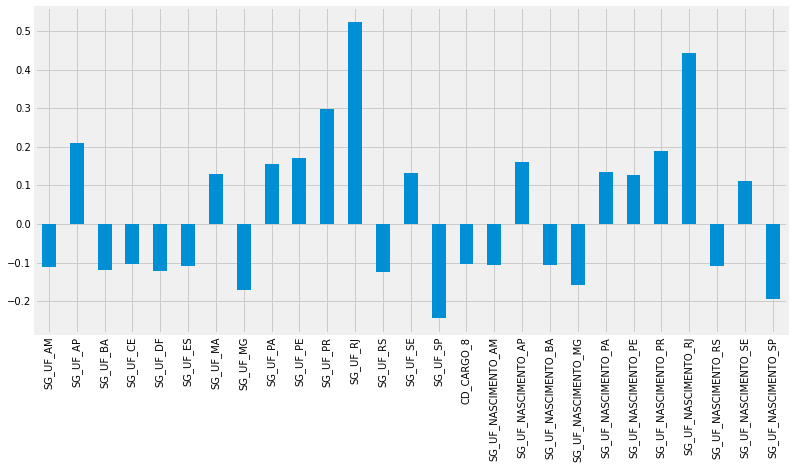

In [36]:
corr_series = pd.Series(corr_dict)
filt = ((corr_series)**2)**(1/2) > 0.1 
plt.figure(figsize=(12, 6))
corr_series.loc[filt].plot(kind='bar')
plt.show()

In [125]:
corr_df = X.corr()
pickling(corr_df, 'corr_df')

'pickle_jar\\corr_df'

<AxesSubplot:>

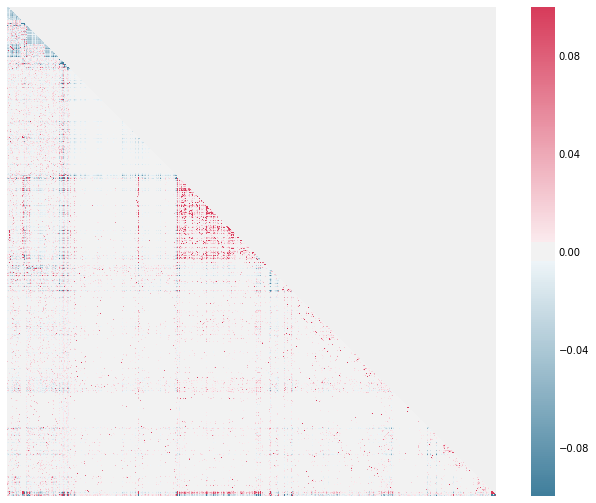

In [126]:
#corr_df = unpickling('corr_df')

# Generates a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 5, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.1, vmin=-0.1, center=0,
            square=True, 
            xticklabels=False, yticklabels=False
            #linewidths=.5,
            #cbar_kws={"shrink": .5}
           )
plt.show()

# Classification Model - XGBoost

## Training

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1988)

In [162]:
estimators_xg = [#('pca', PCA(n_components=500)), 
              ('clf', xgb.XGBClassifier())]



param_grid_xg = dict(clf__class_weight = [dict({0:1, 1:1}),
                                         ],
                     clf__max_depth = [4], 
                     clf__subsample= [0.8], 
                     clf__n_estimators= [100],
                     clf__min_child_weight=[2],
                     clf__gamma = [0],
                     clf__n_jobs = [4],
                     #clf__verbosity = [1],
                     clf__booster= ['gbtree'],
                     
                    )
pipe_xg = Pipeline(estimators_xg)

cv_xg = GridSearchCV(pipe_xg, 
                     param_grid_xg, 
                     scoring = 'f1')

cv_xg.fit(X_train, y_train)

y_train_hat_xg = cv_xg.predict(X_train)
print('best training score:',f1_score(y_train, y_train_hat_xg))

y_test_hat_xg = cv_xg.predict(X_test)
print('best test score:',f1_score(y_test, y_test_hat_xg))

best training score: 0.8645048203330412
best test score: 0.8752032520325203


In [139]:
best_parameters = cv_xg.best_params_
print(best_parameters)

{'clf__booster': 'gbtree', 'clf__class_weight': {0: 1, 1: 1}, 'clf__gamma': 0, 'clf__max_depth': 4, 'clf__min_child_weight': 2, 'clf__n_estimators': 100, 'clf__n_jobs': 4, 'clf__subsample': 0.8}


## Model Evaluation

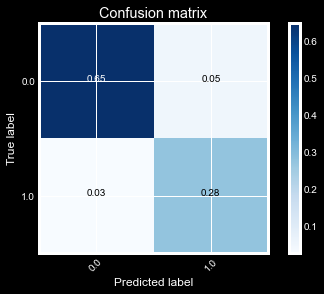

In [163]:
# Confusion Matrix
y_hat_xg = cv_xg.predict(X_test)
plot_confusion_matrix(y_hat_xg, y_test,
                          normalize=True,
                          title='Confusion matrix',
                          )

AUC: 90.13%


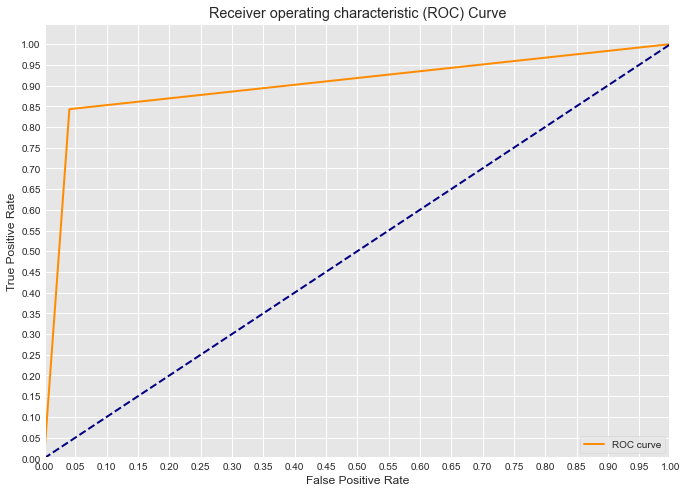

In [170]:
# Calculates Area Under Curve
y_score = cv_xg.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
area_inder_curve = auc(fpr, tpr)
print('AUC: {}%'.format(round(area_inder_curve, 4)*100))


# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

#print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [171]:
pd.DataFrame(classification_report(y_test, y_hat_xg, output_dict=True))

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.926543,0.909975,0.921534,0.918259,0.921135
recall,0.959590,0.842991,0.921534,0.901291,0.921534
f1-score,0.942777,0.875203,0.921534,0.908990,0.920722
support,5271.000000,2554.000000,0.921534,7825.000000,7825.000000


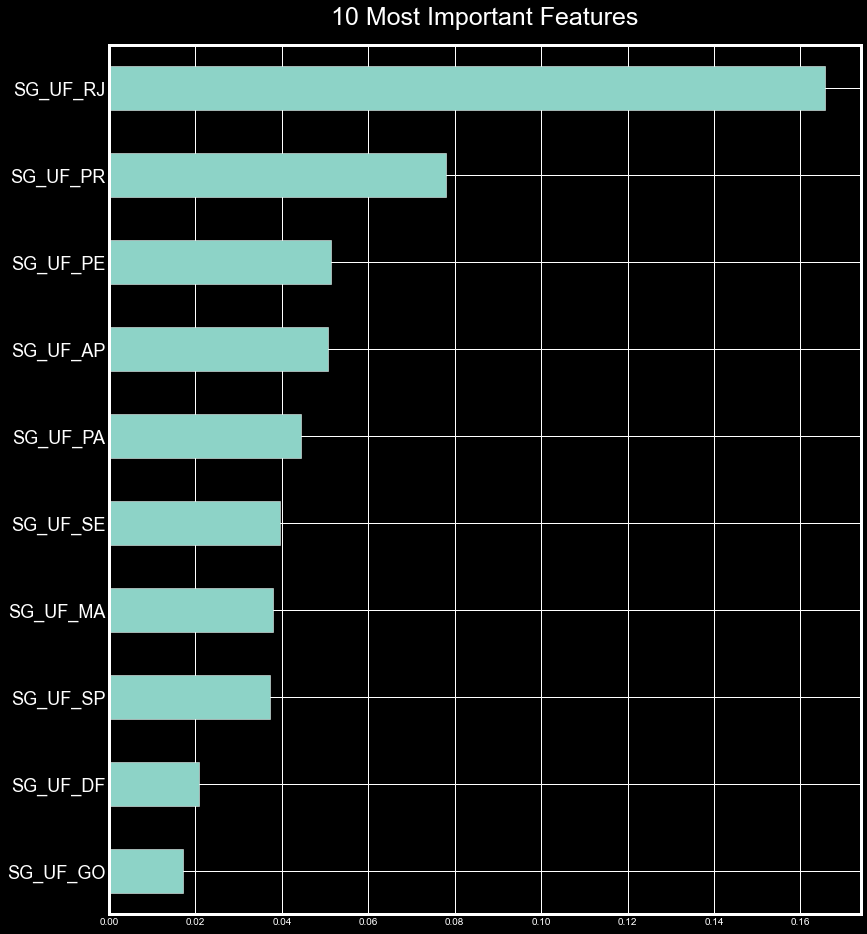

In [178]:
feat_imp_dict = dict()
for col, feat_imp in zip(list(X.columns), cv_xg.best_estimator_._final_estimator.feature_importances_):
    feat_imp_dict[col] = feat_imp

feat_imp_df = pd.Series(feat_imp_dict, name='feature importance')


filt = feat_imp_df != 0
feat_imp_df.loc[filt].nlargest(n=10).sort_values(ascending=True).plot(kind='barh', figsize=(12,16), 
                                                                       legend=False, 
                                                                       yticks=range(len(feat_imp_df.loc[filt])))
plt.title('10 Most Important Features', pad=20, fontsize=25)
plt.yticks(fontsize=18)
style.use('dark_background')
plt.show()

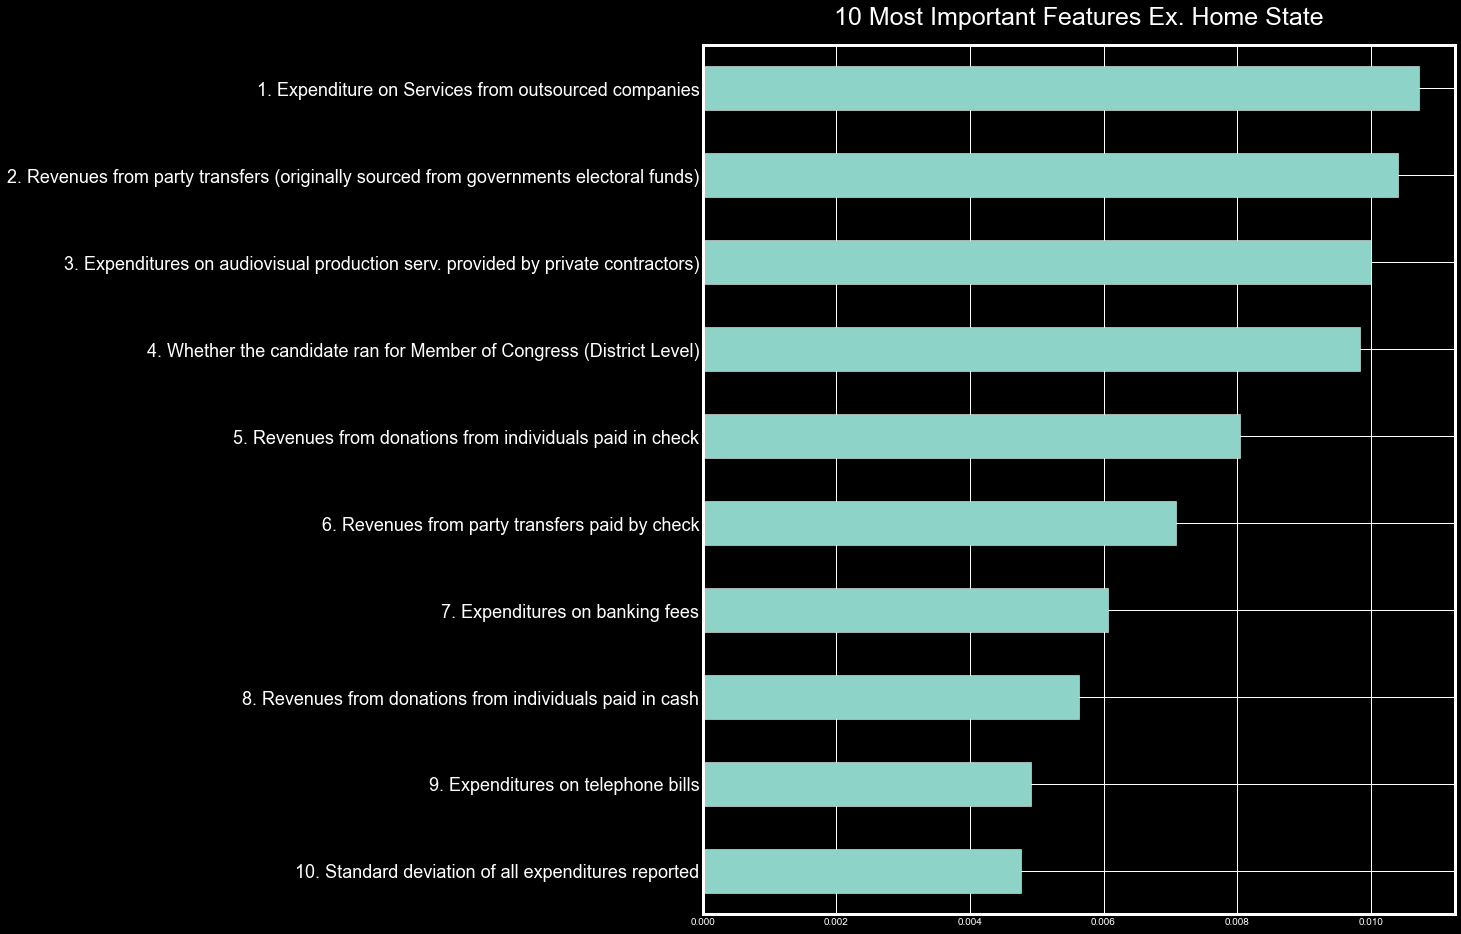

In [198]:
filt = feat_imp_df.index.str.startswith('SG_')
feat_imp_df.loc[~filt].nlargest(n=10).sort_values(ascending=True).plot(kind='barh',
                                                                       figsize=(12, 16), 
                                                                       legend=False, 
                                                                       yticks=range(len(feat_imp_df.loc[filt])))
plt.title('10 Most Important Features Ex. Home State', pad=20, fontsize=25)
plt.yticks(ticks= np.linspace(9, 0, 10),
    labels=[
    '1. Expenditure on Services from outsourced companies',
    '2. Revenues from party transfers (originally sourced from governments electoral funds)',
    '3. Expenditures on audiovisual production serv. provided by private contractors)',
    '4. Whether the candidate ran for Member of Congress (District Level)',
    '5. Revenues from donations from individuals paid in check',
    '6. Revenues from party transfers paid by check',
    '7. Expenditures on banking fees',
    '8. Revenues from donations from individuals paid in cash',
    '9. Expenditures on telephone bills',
    '10. Standard deviation of all expenditures reported'
], fontsize=18)
style.use('dark_background')
plt.show()

We see that apart from a candidate's geographic profile, the top features mostly relate to the revenue and expenditure profiles fo the campaigns. 

In [156]:
filt = feat_imp_df == 0
print('Out of {} features, {} were found to have no importance at all.'.format(len(feat_imp_df), 
                                                                              len(feat_imp_df[filt])))

Out of 984 features, 809 were found to have no importance at all.


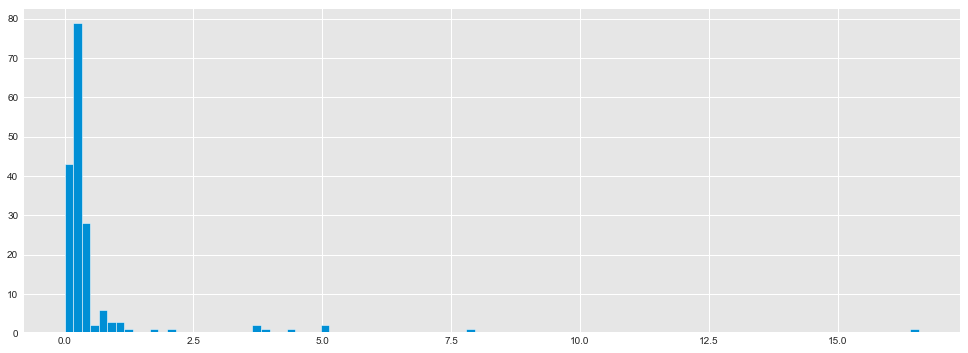

In [158]:
plt.figure( figsize=(15, 6))
plt.hist(feat_imp_df.loc[~filt]*100, bins=100)
plt.title()
plt.show()

In [ ]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

plot_importance(model)
pyplot.show()

In [ ]:

# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()


# Future Research

- explore court cases with other subject matter. Scrape more and then analyze the description
- regroup the court cases with a NLP clustering model and use the clusters as new categories for classification models
- build unsupervised learning models that can reproduce or surpass level of results